In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
sys.path.append("..")
from dataloader import create_dataloader
from metric import Metric
import backbone
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
torch.cuda.empty_cache()


# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
embed_dim = 1024
num_labels = 21
thresholds = [0.5] * num_labels
in_channels = 3
num_classes = 21
omit = ['rfmid2','js']
data_dir = '../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train', omit = omit)
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val', omit = omit)
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test', omit = omit)

384
../../../data/GT-main/./set1/train.csv


384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [4]:
# # Create model and move to device
# model = backbone.backbone['densenet201'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# Create model and move to device
model = backbone.backbone['effnet-2'](num_classes=num_classes, embed_dim = embed_dim)
# model = backbone.backbone['resnet152d-2'](num_classes=num_classes, embed_dim = embed_dim)
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [6]:
# # Create model and move to device
# model = backbone.backbone['efficientnetv2_extralarge'](num_classes=num_classes)
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a=0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad(): metric.update(outputs, labels)
            
    scheduler.step()
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)  
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
        
    # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/2/dn121-rf-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh) 
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 

Epoch 1/200
----------


  0%|          | 0/132 [00:00<?, ?it/s]

100%|██████████| 132/132 [00:43<00:00,  3.04it/s]


Epoch [1/200], Loss: 0.7214, ML mAP: 0.0790, ML F1: 0.8330, ML AUC: 0.5179, ML Score: 0.2984, Bin AUC: 0.1974, Model Score: 0.2479, Bin F1: 1.0000
[0.59 0.89 0.83 0.82 0.78 0.73 0.9  0.88 0.92 0.87 0.99 0.81 0.86 0.88
 0.88 0.81 0.98 0.97 0.86 0.76 0.57]
Accuracy list: [0.7995238095238095, 0.9466666666666667, 0.9266666666666666, 0.9095238095238095, 0.9104761904761904, 0.8861904761904762, 0.9261904761904762, 0.9414285714285714, 0.9438095238095238, 0.939047619047619, 0.9395238095238095, 0.9376190476190476, 0.9519047619047619, 0.9504761904761905, 0.9366666666666666, 0.9152380952380952, 0.9342857142857143, 0.94, 0.9552380952380952, 0.8976190476190476, 0.9119047619047619]
Specificity list: [0.9112458654906285, 0.9994972347913524, 0.9994863893168978, 0.9994767137624281, 0.9994772608468374, 0.9994629430719656, 0.9994861253854059, 0.9994944388270981, 0.998991935483871, 0.9994931576279777, 0.9994934143870314, 0.999492385786802, 0.9995, 0.99949924887331, 0.9994918699186992, 0.95370831259333, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [1/200], Loss: 26.7818, ML mAP: 0.0853, ML F1: 0.8233, ML AUC: 0.5063, ML Score: 0.2958, Bin AUC: 0.2500, Model Score: 0.2729, Bin F1: 0.0000
[0.56 0.51 0.59 0.5  0.6  0.55 0.58 0.6  0.64 0.58 0.55 0.58 0.56 0.58
 0.59 0.61 0.6  0.68 0.6  0.66 0.54]
Accuracy list: [0.765625, 0.7611607142857143, 0.9419642857142857, 0.8995535714285714, 0.9486607142857143, 0.9241071428571429, 0.9419642857142857, 0.9508928571428571, 0.9553571428571429, 0.9821428571428571, 0.9397321428571429, 0.9776785714285714, 0.9754464285714286, 0.9709821428571429, 0.96875, 0.9732142857142857, 0.9776785714285714, 0.984375, 0.9866071428571429, 0.8816964285714286, 0.9553571428571429]
Specificity list: [0.9299719887955182, 0.9256198347107438, 0.9976359338061466, 0.9950617283950617, 0.9976525821596244, 0.9975903614457832, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9541284403669725, 0.9954545454545455, 0.997716894977169, 0.9977064220183486, 0.9977011494252873, 0.9886621315192

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Test - Epoch [1/200], Loss: 26.7754, ML mAP: 0.0992, ML F1: 0.5734, ML AUC: 0.5450, ML Score: 0.3221, Bin AUC: 0.2250, Model Score: 0.2736, Bin F1: 0.0000

[0.56 0.51 0.59 0.5  0.6  0.55 0.58 0.6  0.64 0.58 0.55 0.58 0.56 0.58
 0.59 0.61 0.6  0.68 0.6  0.66 0.54]
Accuracy list: [0.7545045045045045, 0.7657657657657657, 0.9346846846846847, 0.8941441441441441, 0.9414414414414415, 0.9099099099099099, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9481981981981982, 0.9774774774774775, 0.9684684684684685, 0.972972972972973, 0.9819819819819819, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.8648648648648649, 0.9527027027027027]
Specificity list: [0.9297752808988764, 0.9180327868852459, 1.0, 0.9974874371859297, 0.9976133651551312, 0.9901960784313726, 1.0, 1.0, 1.0, 1.0, 0.9654377880184332, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9954337899543378, 0.9908256880733946, 0.9908883826879271, 0.9977272727272727,

100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [2/200], Loss: 0.7188, ML mAP: 0.0777, ML F1: 0.8679, ML AUC: 0.5205, ML Score: 0.2991, Bin AUC: 0.9474, Model Score: 0.6232, Bin F1: 0.0000
[0.59 0.57 0.56 0.5  0.52 0.51 0.57 0.6  0.63 0.56 0.59 0.59 0.56 0.55
 0.58 0.62 0.62 0.62 0.57 0.6  0.53]
Accuracy list: [0.8747619047619047, 0.9466666666666667, 0.9057142857142857, 0.9028571428571428, 0.9133333333333333, 0.790952380952381, 0.9271428571428572, 0.9347619047619048, 0.9371428571428572, 0.9404761904761905, 0.950952380952381, 0.93, 0.9547619047619048, 0.9480952380952381, 0.9466666666666667, 0.9542857142857143, 0.9338095238095238, 0.939047619047619, 0.95, 0.9228571428571428, 0.959047619047619]
Specificity list: [0.999455930359086, 0.9994972347913524, 0.999474513925381, 1.0, 0.9994788952579469, 0.8841131664853101, 0.9994866529774127, 0.9994908350305499, 0.9994921279837481, 0.9994939271255061, 0.9994994994994995, 0.9994882292732856, 0.9990034877927254, 0.9994979919678715, 0.9989949748743718, 0.9995012468827931, 0.9994903160040775,

100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [2/200], Loss: 26.7034, ML mAP: 0.0759, ML F1: 0.7617, ML AUC: 0.5330, ML Score: 0.3044, Bin AUC: 0.3000, Model Score: 0.3022, Bin F1: 0.0000
[0.55 0.51 0.53 0.5  0.5  0.52 0.55 0.56 0.57 0.52 0.52 0.56 0.53 0.54
 0.54 0.57 0.58 0.62 0.57 0.6  0.51]
Accuracy list: [0.6741071428571429, 0.8013392857142857, 0.9151785714285714, 0.9040178571428571, 0.9464285714285714, 0.921875, 0.9419642857142857, 0.9486607142857143, 0.9553571428571429, 0.9709821428571429, 0.9352678571428571, 0.9799107142857143, 0.9732142857142857, 0.9709821428571429, 0.96875, 0.9754464285714286, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.8816964285714286, 0.9308035714285714]
Specificity list: [0.7815126050420168, 0.9889807162534435, 0.9645390070921985, 1.0, 0.9953051643192489, 0.9951807228915662, 0.9976359338061466, 0.9953161592505855, 0.9976689976689976, 0.9863945578231292, 0.9495412844036697, 0.9977272727272727, 0.9954337899543378, 0.9977064220183486, 0.9977011494252873, 0.9909297052154195, 0.9954648

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [2/200], Loss: 26.6965, ML mAP: 0.0963, ML F1: 0.4912, ML AUC: 0.5604, ML Score: 0.3284, Bin AUC: 0.2750, Model Score: 0.3017, Bin F1: 0.0000

[0.55 0.51 0.53 0.5  0.5  0.52 0.55 0.56 0.57 0.52 0.52 0.56 0.53 0.54
 0.54 0.57 0.58 0.62 0.57 0.6  0.51]
Accuracy list: [0.7094594594594594, 0.8220720720720721, 0.8941441441441441, 0.8963963963963963, 0.9324324324324325, 0.8986486486486487, 0.9527027027027027, 0.9527027027027027, 0.9617117117117117, 0.9617117117117117, 0.9076576576576577, 0.9774774774774775, 0.9662162162162162, 0.9752252252252253, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.9864864864864865, 0.9842342342342343, 0.8671171171171171, 0.9414414414414415]
Specificity list: [0.8202247191011236, 0.994535519125683, 0.9542168674698795, 1.0, 0.9880668257756563, 0.9779411764705882, 1.0, 1.0, 0.993006993006993, 0.9861111111111112, 0.9262672811059908, 0.9977011494252873, 0.9953596287703016, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954441913439636, 0.99

100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [3/200], Loss: 0.7095, ML mAP: 0.0779, ML F1: 0.6868, ML AUC: 0.5280, ML Score: 0.3029, Bin AUC: 0.2250, Model Score: 0.2640, Bin F1: 1.0000
[0.56 0.53 0.52 0.5  0.5  0.52 0.52 0.55 0.58 0.52 0.55 0.57 0.55 0.51
 0.56 0.57 0.58 0.56 0.53 0.54 0.5 ]
Accuracy list: [0.8776190476190476, 0.9452380952380952, 0.88, 0.900952380952381, 0.9071428571428571, 0.8923809523809524, 0.8919047619047619, 0.9433333333333334, 0.9395238095238095, 0.940952380952381, 0.9304761904761905, 0.9385714285714286, 0.9528571428571428, 0.9466666666666667, 0.9323809523809524, 0.9528571428571428, 0.9333333333333333, 0.94, 0.9023809523809524, 0.9219047619047619, 0.9285714285714286]
Specificity list: [0.9983748645720477, 0.9994962216624685, 0.9447314049586777, 1.0, 1.0, 0.9978700745473909, 0.9554303278688525, 0.9994954591321897, 0.9989873417721519, 0.9974760222110045, 0.9989775051124744, 0.9989863152559554, 0.9995004995004995, 0.9994972347913524, 0.9994895354772844, 0.9995004995004995, 0.9979633401221996, 0.99445843

100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


Val - Epoch [3/200], Loss: 26.6539, ML mAP: 0.0754, ML F1: 0.6862, ML AUC: 0.5310, ML Score: 0.3032, Bin AUC: 0.3000, Model Score: 0.3016, Bin F1: 0.0000
[0.55 0.51 0.53 0.5  0.5  0.5  0.52 0.53 0.56 0.5  0.52 0.55 0.52 0.54
 0.52 0.56 0.57 0.59 0.56 0.57 0.5 ]
Accuracy list: [0.796875, 0.7991071428571429, 0.9419642857142857, 0.9040178571428571, 0.9486607142857143, 0.9263392857142857, 0.9375, 0.9508928571428571, 0.9508928571428571, 0.984375, 0.9330357142857143, 0.9799107142857143, 0.9754464285714286, 0.9709821428571429, 0.9553571428571429, 0.9821428571428571, 0.984375, 0.984375, 0.9866071428571429, 0.8816964285714286, 0.9575892857142857]
Specificity list: [0.9971988795518207, 0.9862258953168044, 0.9976359338061466, 1.0, 0.9976525821596244, 1.0, 0.9929078014184397, 0.9976580796252927, 0.993006993006993, 1.0, 0.9518348623853211, 0.9977272727272727, 0.997716894977169, 0.9977064220183486, 0.9839080459770115, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9954954954954955, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [3/200], Loss: 26.6492, ML mAP: 0.0832, ML F1: 0.4182, ML AUC: 0.5329, ML Score: 0.3080, Bin AUC: 0.3250, Model Score: 0.3165, Bin F1: 0.0000

[0.55 0.51 0.53 0.5  0.5  0.5  0.52 0.53 0.56 0.5  0.52 0.55 0.52 0.54
 0.52 0.56 0.57 0.59 0.56 0.57 0.5 ]
Accuracy list: [0.7995495495495496, 0.8085585585585585, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9572072072072072, 0.9707207207207207, 0.9211711711711712, 0.9774774774774775, 0.9662162162162162, 0.9752252252252253, 0.9594594594594594, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.8671171171171171, 0.9504504504504504]
Specificity list: [0.9971910112359551, 0.9781420765027322, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.986013986013986, 0.9976851851851852, 0.9354838709677419, 0.9977011494252873, 0.9953596287703016, 1.0, 0.9726027397260274, 1.0, 0.9977220956719818, 0.9954545454545455, 0.997716894977169, 0.9922680412371134, 0.99

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [4/200], Loss: 0.7066, ML mAP: 0.0768, ML F1: 0.4496, ML AUC: 0.5143, ML Score: 0.2956, Bin AUC: 0.3250, Model Score: 0.3103, Bin F1: 1.0000
[0.55 0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.54 0.5  0.52 0.54 0.52 0.5
 0.5  0.56 0.57 0.53 0.53 0.53 0.5 ]
Accuracy list: [0.8709523809523809, 0.950952380952381, 0.8371428571428572, 0.909047619047619, 0.9147619047619048, 0.8809523809523809, 0.9333333333333333, 0.86, 0.9495238095238095, 0.92, 0.9371428571428572, 0.9295238095238095, 0.9504761904761905, 0.9561904761904761, 0.9276190476190476, 0.9457142857142857, 0.93, 0.8757142857142857, 0.9485714285714286, 0.8785714285714286, 0.9561904761904761]
Specificity list: [1.0, 1.0, 0.8915167095115681, 1.0, 1.0, 1.0, 0.9994900560938297, 0.9105691056910569, 0.9994987468671679, 1.0, 0.9994921279837481, 0.9994879672299027, 0.99949924887331, 0.9995022399203584, 0.9938744257274119, 0.9994967287367891, 0.9994882292732856, 0.9266428935303107, 0.9989969909729187, 0.9414483821263482, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [4/200], Loss: 26.6073, ML mAP: 0.0566, ML F1: 0.4965, ML AUC: 0.5498, ML Score: 0.3032, Bin AUC: 0.3750, Model Score: 0.3391, Bin F1: 0.0000
[0.53 0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.51 0.54 0.52 0.53
 0.5  0.54 0.56 0.59 0.55 0.58 0.5 ]
Accuracy list: [0.6517857142857143, 0.8102678571428571, 0.9419642857142857, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9419642857142857, 0.953125, 0.9486607142857143, 0.984375, 0.9620535714285714, 0.9776785714285714, 0.9754464285714286, 0.9709821428571429, 0.9665178571428571, 0.84375, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.8794642857142857, 0.9575892857142857]
Specificity list: [0.7647058823529411, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 0.9952718676122931, 1.0, 0.9883449883449883, 1.0, 0.9885321100917431, 0.9954545454545455, 0.997716894977169, 0.9977064220183486, 0.9954022988505747, 0.8503401360544217, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Test - Epoch [4/200], Loss: 26.5998, ML mAP: 0.0601, ML F1: 0.2106, ML AUC: 0.5301, ML Score: 0.2951, Bin AUC: 0.3500, Model Score: 0.3225, Bin F1: 1.0000

[0.53 0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.51 0.54 0.52 0.53
 0.5  0.54 0.56 0.59 0.55 0.58 0.5 ]
Accuracy list: [0.7004504504504504, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9414414414414415, 0.9527027027027027, 0.9572072072072072, 0.972972972972973, 0.9707207207207207, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.8423423423423423, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.8626126126126126, 0.9481981981981982]
Specificity list: [0.8117977528089888, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9881796690307328, 1.0, 0.9883449883449883, 1.0, 0.9930875576036866, 1.0, 1.0, 1.0, 1.0, 0.8509174311926605, 1.0, 1.0, 0.997716894977169, 0.9871134020618557, 1.0]
Epoch 5/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.30it/s]


Epoch [5/200], Loss: 0.6938, ML mAP: 0.0721, ML F1: 0.5259, ML AUC: 0.5042, ML Score: 0.2881, Bin AUC: 0.3684, Model Score: 0.3283, Bin F1: 0.0000
[0.53 0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.52 0.5  0.5  0.53 0.53 0.53
 0.5  0.54 0.58 0.55 0.51 0.57 0.5 ]
Accuracy list: [0.871904761904762, 0.9528571428571428, 0.919047619047619, 0.9119047619047619, 0.9180952380952381, 0.8833333333333333, 0.9338095238095238, 0.94, 0.9423809523809524, 0.9371428571428572, 0.939047619047619, 0.93, 0.9480952380952381, 0.9428571428571428, 0.9428571428571428, 0.9442857142857143, 0.9314285714285714, 0.9357142857142857, 0.9514285714285714, 0.9271428571428572, 0.9523809523809523]
Specificity list: [0.9913373037357878, 1.0, 0.9989642672190575, 1.0, 1.0, 1.0, 0.9989811512990321, 1.0, 0.9989904088844018, 1.0, 0.9994931576279777, 0.9989769820971867, 0.9984954864593781, 0.9994952044422009, 1.0, 0.993480441323972, 0.9989785495403473, 0.9994913530010173, 0.9994997498749375, 0.9979497693490518, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [5/200], Loss: 26.5153, ML mAP: 0.0530, ML F1: 0.4286, ML AUC: 0.5152, ML Score: 0.2841, Bin AUC: 0.4250, Model Score: 0.3546, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.51 0.53
 0.5  0.51 0.54 0.54 0.5  0.57 0.5 ]
Accuracy list: [0.7946428571428571, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9799107142857143, 0.96875, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9821428571428571, 0.9776785714285714, 0.9866071428571429, 0.8794642857142857, 0.9575892857142857]
Specificity list: [0.9971988795518207, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977272727272727, 0.9908675799086758, 0.9977064220183486, 1.0, 0.9977324263038548, 0.9977324263038548, 0.9909502262443439, 0.9954954954954955, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [5/200], Loss: 26.5076, ML mAP: 0.0543, ML F1: 0.2434, ML AUC: 0.5229, ML Score: 0.2886, Bin AUC: 0.4750, Model Score: 0.3818, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.51 0.53
 0.5  0.51 0.54 0.54 0.5  0.57 0.5 ]
Accuracy list: [0.7995495495495496, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9774774774774775, 0.963963963963964, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [0.9971910112359551, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977011494252873, 0.9907192575406032, 1.0, 1.0, 0.9977064220183486, 0.9977220956719818, 0.9954545454545455, 1.0, 1.0, 1.0]
Epoch 6/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [6/200], Loss: 0.6932, ML mAP: 0.0708, ML F1: 0.2885, ML AUC: 0.5058, ML Score: 0.2883, Bin AUC: 0.4500, Model Score: 0.3691, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.52
 0.5  0.5  0.54 0.52 0.5  0.55 0.5 ]
Accuracy list: [0.8857142857142857, 0.9485714285714286, 0.9214285714285714, 0.9066666666666666, 0.9185714285714286, 0.8766666666666667, 0.93, 0.9442857142857143, 0.9366666666666666, 0.9347619047619048, 0.94, 0.9071428571428571, 0.949047619047619, 0.9557142857142857, 0.9433333333333334, 0.9433333333333334, 0.9347619047619048, 0.9319047619047619, 0.9461904761904761, 0.9323809523809524, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9763496143958869, 0.9950074887668497, 0.9990044798407167, 1.0, 0.9924849699398798, 0.9994908350305499, 0.9984693877551021, 1.0, 0.9994895354772844, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [6/200], Loss: 26.5020, ML mAP: 0.0525, ML F1: 0.3333, ML AUC: 0.5133, ML Score: 0.2829, Bin AUC: 0.4500, Model Score: 0.3665, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.53 0.52 0.5  0.54 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9732142857142857, 0.9665178571428571, 0.9709821428571429, 0.9821428571428571, 0.9754464285714286, 0.9799107142857143, 0.9888392857142857, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954337899543378, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195, 0.9932126696832579, 0.9977477477477478, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.12it/s]


Test - Epoch [6/200], Loss: 26.4946, ML mAP: 0.0541, ML F1: 0.2381, ML AUC: 0.5143, ML Score: 0.2842, Bin AUC: 0.5000, Model Score: 0.3921, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.53 0.52 0.5  0.54 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9774774774774775, 0.9662162162162162, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977011494252873, 0.9953596287703016, 0.9976905311778291, 1.0, 1.0, 0.9954441913439636, 0.9954545454545455, 1.0, 1.0, 1.0]
Epoch 7/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [7/200], Loss: 0.6935, ML mAP: 0.0717, ML F1: 0.1109, ML AUC: 0.5030, ML Score: 0.2873, Bin AUC: 0.5000, Model Score: 0.3937, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8728571428571429, 0.949047619047619, 0.9223809523809524, 0.8990476190476191, 0.9142857142857143, 0.8857142857142857, 0.9261904761904762, 0.9319047619047619, 0.9438095238095238, 0.9338095238095238, 0.9480952380952381, 0.9376190476190476, 0.9604761904761905, 0.93, 0.9395238095238095, 0.9466666666666667, 0.8480952380952381, 0.929047619047619, 0.95, 0.878095238095238, 0.9533333333333334]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9934310257705912, 0.9995044598612488, 0.9853535353535353, 1.0, 0.9979919678714859, 0.8963227783452502, 0.989821882951654, 1.0, 0.9401534526854219, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [7/200], Loss: 26.5009, ML mAP: 0.0518, ML F1: 0.3333, ML AUC: 0.5119, ML Score: 0.2818, Bin AUC: 0.4750, Model Score: 0.3784, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.54 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9799107142857143, 0.9732142857142857, 0.9665178571428571, 0.9709821428571429, 0.9821428571428571, 0.9821428571428571, 0.9754464285714286, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977272727272727, 0.9954337899543378, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9977324263038548, 0.9886877828054299, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Test - Epoch [7/200], Loss: 26.4935, ML mAP: 0.0517, ML F1: 0.2381, ML AUC: 0.5059, ML Score: 0.2788, Bin AUC: 0.5000, Model Score: 0.3894, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.54 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9774774774774775, 0.963963963963964, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977011494252873, 0.9930394431554525, 0.9976905311778291, 1.0, 1.0, 1.0, 0.9954545454545455, 1.0, 0.9948453608247423, 1.0]
Epoch 8/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [8/200], Loss: 0.6932, ML mAP: 0.0676, ML F1: 0.3333, ML AUC: 0.5013, ML Score: 0.2845, Bin AUC: 0.5000, Model Score: 0.3922, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.52 0.51
 0.5  0.51 0.52 0.51 0.5  0.52 0.5 ]
Accuracy list: [0.8823809523809524, 0.95, 0.9257142857142857, 0.9076190476190477, 0.9171428571428571, 0.8909523809523809, 0.9314285714285714, 0.940952380952381, 0.9419047619047619, 0.9419047619047619, 0.9404761904761905, 0.9342857142857143, 0.9442857142857143, 0.9519047619047619, 0.9457142857142857, 0.9504761904761905, 0.9423809523809524, 0.9376190476190476, 0.9471428571428572, 0.930952380952381, 0.9452380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 0.9994959677419355, 0.9995, 1.0, 0.99949924887331, 0.9994949494949495, 0.997467071935157, 1.0, 0.9989780275932549, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [8/200], Loss: 26.5005, ML mAP: 0.0518, ML F1: 0.3333, ML AUC: 0.5131, ML Score: 0.2825, Bin AUC: 0.4500, Model Score: 0.3662, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9754464285714286, 0.9665178571428571, 0.9709821428571429, 0.9821428571428571, 0.9732142857142857, 0.9821428571428571, 0.9888392857142857, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9886621315192744, 0.995475113122172, 0.9977477477477478, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [8/200], Loss: 26.4931, ML mAP: 0.0534, ML F1: 0.2857, ML AUC: 0.5138, ML Score: 0.2836, Bin AUC: 0.5000, Model Score: 0.3918, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9774774774774775, 0.9684684684684685, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9774774774774775, 0.9887387387387387, 0.9864864864864865, 0.8716216216216216, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 1.0, 1.0, 0.9886104783599089, 0.9977272727272727, 1.0, 0.9974226804123711, 1.0]
Epoch 9/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [9/200], Loss: 0.6931, ML mAP: 0.0713, ML F1: 0.2876, ML AUC: 0.5024, ML Score: 0.2869, Bin AUC: 0.5000, Model Score: 0.3934, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.51
 0.5  0.5  0.52 0.51 0.5  0.52 0.5 ]
Accuracy list: [0.8809523809523809, 0.9533333333333334, 0.9304761904761905, 0.8957142857142857, 0.9133333333333333, 0.8752380952380953, 0.9276190476190476, 0.9447619047619048, 0.9280952380952381, 0.9371428571428572, 0.9395238095238095, 0.9304761904761905, 0.9495238095238095, 0.9547619047619048, 0.9428571428571428, 0.9419047619047619, 0.9342857142857143, 0.9319047619047619, 0.9504761904761905, 0.9347619047619048, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979539641943734, 0.998997995991984, 0.9995014955134596, 1.0, 0.9994946942900454, 0.9984732824427481, 0.9984693877551021, 1.0, 0.9994908350305499, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [9/200], Loss: 26.5003, ML mAP: 0.0519, ML F1: 0.2381, ML AUC: 0.5137, ML Score: 0.2828, Bin AUC: 0.4750, Model Score: 0.3789, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.96875, 0.9709821428571429, 0.9821428571428571, 0.9776785714285714, 0.9821428571428571, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [9/200], Loss: 26.4931, ML mAP: 0.0526, ML F1: 0.2857, ML AUC: 0.5075, ML Score: 0.2801, Bin AUC: 0.5000, Model Score: 0.3900, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9684684684684685, 0.972972972972973, 0.9864864864864865, 0.9752252252252253, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976798143851509, 0.9976905311778291, 1.0, 0.9931192660550459, 0.9931662870159453, 0.9931818181818182, 1.0, 0.9948453608247423, 1.0]
Epoch 10/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [10/200], Loss: 0.6931, ML mAP: 0.0729, ML F1: 0.2408, ML AUC: 0.5050, ML Score: 0.2889, Bin AUC: 0.5000, Model Score: 0.3945, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5
 0.5  0.5  0.52 0.52 0.5  0.52 0.5 ]
Accuracy list: [0.8776190476190476, 0.9528571428571428, 0.919047619047619, 0.8976190476190476, 0.9133333333333333, 0.8819047619047619, 0.930952380952381, 0.9376190476190476, 0.9380952380952381, 0.9338095238095238, 0.9428571428571428, 0.9338095238095238, 0.9552380952380952, 0.9366666666666666, 0.9438095238095238, 0.94, 0.9371428571428572, 0.9471428571428572, 0.949047619047619, 0.9271428571428572, 0.9495238095238095]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974541751527495, 0.999003984063745, 0.9894259818731118, 1.0, 0.9984825493171472, 0.9994921279837481, 0.9994974874371859, 1.0, 0.9994866529774127, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Val - Epoch [10/200], Loss: 26.5000, ML mAP: 0.0515, ML F1: 0.3333, ML AUC: 0.5106, ML Score: 0.2811, Bin AUC: 0.4750, Model Score: 0.3780, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9799107142857143, 0.9754464285714286, 0.953125, 0.9709821428571429, 0.9799107142857143, 0.9754464285714286, 0.984375, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977272727272727, 0.997716894977169, 0.9793577981651376, 1.0, 0.9954648526077098, 0.9909297052154195, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [10/200], Loss: 26.4928, ML mAP: 0.0532, ML F1: 0.2381, ML AUC: 0.5146, ML Score: 0.2839, Bin AUC: 0.5000, Model Score: 0.3919, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9662162162162162, 0.954954954954955, 0.9864864864864865, 0.9797297297297297, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953596287703016, 0.9792147806004619, 1.0, 0.9977064220183486, 0.9931662870159453, 0.9977272727272727, 1.0, 1.0, 1.0]
Epoch 11/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [11/200], Loss: 0.6931, ML mAP: 0.0721, ML F1: 0.2944, ML AUC: 0.5040, ML Score: 0.2880, Bin AUC: 0.5000, Model Score: 0.3940, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.51 0.52
 0.5  0.5  0.5  0.51 0.5  0.53 0.5 ]
Accuracy list: [0.87, 0.9576190476190476, 0.9185714285714286, 0.9066666666666666, 0.9166666666666666, 0.8771428571428571, 0.9380952380952381, 0.9347619047619048, 0.9414285714285714, 0.9357142857142857, 0.9419047619047619, 0.9242857142857143, 0.9542857142857143, 0.9414285714285714, 0.9395238095238095, 0.9561904761904761, 0.9147619047619048, 0.9371428571428572, 0.9471428571428572, 0.9252380952380952, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994850669412977, 0.9995012468827931, 0.9994944388270981, 1.0, 0.9995022399203584, 0.9644850329781837, 0.9994921279837481, 1.0, 0.9994855967078189, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.53it/s]


Val - Epoch [11/200], Loss: 26.4994, ML mAP: 0.0514, ML F1: 0.2381, ML AUC: 0.5089, ML Score: 0.2801, Bin AUC: 0.5000, Model Score: 0.3901, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.51 0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9799107142857143, 0.9799107142857143, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 0.9977324263038548, 0.9954648526077098, 0.9932126696832579, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Test - Epoch [11/200], Loss: 26.4922, ML mAP: 0.0530, ML F1: 0.1429, ML AUC: 0.5096, ML Score: 0.2813, Bin AUC: 0.5000, Model Score: 0.3906, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.51 0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9774774774774775, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954441913439636, 0.9931818181818182, 1.0, 1.0, 1.0]
Epoch 12/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [12/200], Loss: 0.6931, ML mAP: 0.0716, ML F1: 0.1985, ML AUC: 0.5020, ML Score: 0.2868, Bin AUC: 0.5000, Model Score: 0.3934, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8795238095238095, 0.9433333333333334, 0.9166666666666666, 0.8909523809523809, 0.9176190476190477, 0.8742857142857143, 0.9328571428571428, 0.9333333333333333, 0.9442857142857143, 0.9366666666666666, 0.9504761904761905, 0.9261904761904762, 0.9480952380952381, 0.9480952380952381, 0.9471428571428572, 0.9523809523809523, 0.9261904761904762, 0.94, 0.950952380952381, 0.9280952380952381, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989727786337956, 0.9969954932398598, 0.9974949899799599, 1.0, 1.0, 0.9811991869918699, 0.9984817813765182, 1.0, 0.9938806731259562, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [12/200], Loss: 26.4992, ML mAP: 0.0592, ML F1: 0.2024, ML AUC: 0.5124, ML Score: 0.2858, Bin AUC: 0.5000, Model Score: 0.3929, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.51 0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [12/200], Loss: 26.4920, ML mAP: 0.0532, ML F1: 0.1071, ML AUC: 0.5029, ML Score: 0.2781, Bin AUC: 0.5000, Model Score: 0.3890, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.51 0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954441913439636, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 13/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [13/200], Loss: 0.6931, ML mAP: 0.0721, ML F1: 0.1032, ML AUC: 0.5023, ML Score: 0.2872, Bin AUC: 0.5000, Model Score: 0.3936, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8728571428571429, 0.9519047619047619, 0.9261904761904762, 0.9066666666666666, 0.9223809523809524, 0.8823809523809524, 0.9338095238095238, 0.940952380952381, 0.9295238095238095, 0.9252380952380952, 0.9438095238095238, 0.9314285714285714, 0.9485714285714286, 0.9442857142857143, 0.939047619047619, 0.9528571428571428, 0.9428571428571428, 0.9433333333333334, 0.9466666666666667, 0.9280952380952381, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989969909729187, 0.998992443324937, 1.0, 1.0, 0.9894472361809046, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [13/200], Loss: 26.4992, ML mAP: 0.0568, ML F1: 0.2500, ML AUC: 0.5057, ML Score: 0.2812, Bin AUC: 0.5000, Model Score: 0.3906, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.51 0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9754464285714286, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8772321428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997716894977169, 0.9977064220183486, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Test - Epoch [13/200], Loss: 26.4918, ML mAP: 0.0549, ML F1: 0.1565, ML AUC: 0.5032, ML Score: 0.2790, Bin AUC: 0.5000, Model Score: 0.3895, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.51 0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8716216216216216, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953810623556582, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 14/200
----------


100%|██████████| 132/132 [00:41<00:00,  3.19it/s]


Epoch [14/200], Loss: 0.6931, ML mAP: 0.0730, ML F1: 0.2456, ML AUC: 0.5021, ML Score: 0.2875, Bin AUC: 0.5000, Model Score: 0.3938, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8723809523809524, 0.9552380952380952, 0.9271428571428572, 0.91, 0.9152380952380952, 0.8847619047619047, 0.9357142857142857, 0.9276190476190476, 0.9323809523809524, 0.9395238095238095, 0.9385714285714286, 0.9357142857142857, 0.9476190476190476, 0.949047619047619, 0.9461904761904761, 0.949047619047619, 0.9338095238095238, 0.9361904761904762, 0.95, 0.9280952380952381, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974937343358395, 0.9989974937343359, 1.0, 0.9989974937343359, 0.9903406202338587, 1.0, 1.0, 0.9994871794871795, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [14/200], Loss: 26.4994, ML mAP: 0.0565, ML F1: 0.2024, ML AUC: 0.5051, ML Score: 0.2808, Bin AUC: 0.4750, Model Score: 0.3779, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.51 0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.9799107142857143, 0.9866071428571429, 0.9799107142857143, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 0.9954648526077098, 1.0, 0.9932126696832579, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Test - Epoch [14/200], Loss: 26.4920, ML mAP: 0.0562, ML F1: 0.2517, ML AUC: 0.5087, ML Score: 0.2824, Bin AUC: 0.5000, Model Score: 0.3912, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.52 0.51 0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9842342342342343, 0.9842342342342343, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953810623556582, 1.0, 0.9977064220183486, 0.9977220956719818, 0.9931818181818182, 0.997716894977169, 0.9948453608247423, 1.0]
Epoch 15/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [15/200], Loss: 0.6931, ML mAP: 0.0742, ML F1: 0.2952, ML AUC: 0.5028, ML Score: 0.2885, Bin AUC: 0.5000, Model Score: 0.3942, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8757142857142857, 0.9519047619047619, 0.9323809523809524, 0.9023809523809524, 0.920952380952381, 0.8847619047619047, 0.9338095238095238, 0.9419047619047619, 0.9371428571428572, 0.9404761904761905, 0.94, 0.9357142857142857, 0.9447619047619048, 0.9485714285714286, 0.9271428571428572, 0.9433333333333334, 0.9280952380952381, 0.9376190476190476, 0.960952380952381, 0.9285714285714286, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 0.9994962216624685, 0.9979959919839679, 1.0, 0.9994954591321897, 0.9887410440122825, 0.9994921279837481, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.70it/s]


Val - Epoch [15/200], Loss: 26.4991, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5025, ML Score: 0.2791, Bin AUC: 0.5000, Model Score: 0.3895, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9799107142857143, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 0.995475113122172, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [15/200], Loss: 26.4918, ML mAP: 0.0600, ML F1: 0.1548, ML AUC: 0.5045, ML Score: 0.2823, Bin AUC: 0.5000, Model Score: 0.3911, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9954128440366973, 0.9954441913439636, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 16/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [16/200], Loss: 0.6931, ML mAP: 0.0705, ML F1: 0.1491, ML AUC: 0.5017, ML Score: 0.2861, Bin AUC: 0.5000, Model Score: 0.3931, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8804761904761905, 0.9495238095238095, 0.9119047619047619, 0.9033333333333333, 0.9185714285714286, 0.8852380952380953, 0.9223809523809524, 0.9423809523809524, 0.9419047619047619, 0.9466666666666667, 0.9428571428571428, 0.9357142857142857, 0.9428571428571428, 0.9561904761904761, 0.9461904761904761, 0.9547619047619048, 0.9371428571428572, 0.9495238095238095, 0.9514285714285714, 0.9366666666666666, 0.9447619047619048]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999484004127967, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990034877927254, 0.9929006085192698, 1.0, 1.0, 0.9994918699186992, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [16/200], Loss: 26.4991, ML mAP: 0.0567, ML F1: 0.1548, ML AUC: 0.5060, ML Score: 0.2813, Bin AUC: 0.5000, Model Score: 0.3907, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9799107142857143, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 0.995475113122172, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Test - Epoch [16/200], Loss: 26.4918, ML mAP: 0.0599, ML F1: 0.2041, ML AUC: 0.5041, ML Score: 0.2820, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.8716216216216216, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9977220956719818, 0.9977272727272727, 1.0, 0.9974226804123711, 1.0]
Epoch 17/200
----------


100%|██████████| 132/132 [00:43<00:00,  3.02it/s]


Epoch [17/200], Loss: 0.6931, ML mAP: 0.0731, ML F1: 0.2455, ML AUC: 0.5020, ML Score: 0.2876, Bin AUC: 0.5000, Model Score: 0.3938, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.878095238095238, 0.9476190476190476, 0.9233333333333333, 0.91, 0.9138095238095238, 0.8828571428571429, 0.939047619047619, 0.9328571428571428, 0.9371428571428572, 0.9285714285714286, 0.9423809523809524, 0.9380952380952381, 0.95, 0.9423809523809524, 0.9457142857142857, 0.9457142857142857, 0.9376190476190476, 0.9395238095238095, 0.95, 0.9285714285714286, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994931576279777, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 0.9994967287367891, 0.994410569105691, 0.9994934143870314, 1.0, 0.9984639016897081, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


Val - Epoch [17/200], Loss: 26.4990, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5027, ML Score: 0.2792, Bin AUC: 0.5000, Model Score: 0.3896, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Test - Epoch [17/200], Loss: 26.4917, ML mAP: 0.0599, ML F1: 0.1565, ML AUC: 0.5037, ML Score: 0.2818, Bin AUC: 0.5000, Model Score: 0.3909, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8716216216216216, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 18/200
----------


100%|██████████| 132/132 [00:42<00:00,  3.13it/s]


Epoch [18/200], Loss: 0.6931, ML mAP: 0.0737, ML F1: 0.1513, ML AUC: 0.5024, ML Score: 0.2881, Bin AUC: 0.5000, Model Score: 0.3940, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8752380952380953, 0.9514285714285714, 0.9266666666666666, 0.9066666666666666, 0.9219047619047619, 0.8852380952380953, 0.9195238095238095, 0.9347619047619048, 0.9423809523809524, 0.9347619047619048, 0.9471428571428572, 0.9328571428571428, 0.9542857142857143, 0.9457142857142857, 0.9433333333333334, 0.9457142857142857, 0.9385714285714286, 0.9447619047619048, 0.9433333333333334, 0.9280952380952381, 0.9461904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989653388515262, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995012468827931, 1.0, 1.0, 0.9984917043740573, 0.994410569105691, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [18/200], Loss: 26.4991, ML mAP: 0.0569, ML F1: 0.2024, ML AUC: 0.5061, ML Score: 0.2815, Bin AUC: 0.5000, Model Score: 0.3907, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 0.9977324263038548, 1.0, 0.995475113122172, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Test - Epoch [18/200], Loss: 26.4918, ML mAP: 0.0599, ML F1: 0.2024, ML AUC: 0.5036, ML Score: 0.2817, Bin AUC: 0.5000, Model Score: 0.3909, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.8716216216216216, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953810623556582, 1.0, 0.9954128440366973, 0.9954441913439636, 0.9977272727272727, 1.0, 0.9974226804123711, 1.0]
Epoch 19/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [19/200], Loss: 0.6933, ML mAP: 0.0741, ML F1: 0.2486, ML AUC: 0.5034, ML Score: 0.2887, Bin AUC: 0.5000, Model Score: 0.3944, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8785714285714286, 0.9566666666666667, 0.9185714285714286, 0.9038095238095238, 0.9047619047619048, 0.8809523809523809, 0.9371428571428572, 0.9347619047619048, 0.9414285714285714, 0.9333333333333333, 0.9347619047619048, 0.9385714285714286, 0.9447619047619048, 0.9571428571428572, 0.9461904761904761, 0.949047619047619, 0.9328571428571428, 0.9480952380952381, 0.9495238095238095, 0.9238095238095239, 0.9495238095238095]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994929006085193, 0.9994962216624685, 1.0, 1.0, 0.9994984954864594, 0.9867684478371501, 0.9989964877069744, 1.0, 0.9994848016486347, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Val - Epoch [19/200], Loss: 26.4990, ML mAP: 0.0568, ML F1: 0.1548, ML AUC: 0.5062, ML Score: 0.2815, Bin AUC: 0.5000, Model Score: 0.3907, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [19/200], Loss: 26.4918, ML mAP: 0.0599, ML F1: 0.1088, ML AUC: 0.5039, ML Score: 0.2819, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 20/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.33it/s]


Epoch [20/200], Loss: 0.6931, ML mAP: 0.0750, ML F1: 0.2956, ML AUC: 0.5029, ML Score: 0.2889, Bin AUC: 0.5000, Model Score: 0.3945, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8738095238095238, 0.9557142857142857, 0.9138095238095238, 0.8928571428571429, 0.919047619047619, 0.8942857142857142, 0.9242857142857143, 0.940952380952381, 0.9357142857142857, 0.9457142857142857, 0.9461904761904761, 0.9442857142857143, 0.9447619047619048, 0.9461904761904761, 0.9380952380952381, 0.9495238095238095, 0.9380952380952381, 0.9338095238095238, 0.9476190476190476, 0.9157142857142857, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994850669412977, 1.0, 1.0, 1.0, 1.0, 0.9994959677419355, 0.9994962216624685, 0.9994969818913481, 1.0, 0.9994987468671679, 0.9923780487804879, 1.0, 1.0, 0.9984423676012462, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [20/200], Loss: 26.4990, ML mAP: 0.0569, ML F1: 0.2024, ML AUC: 0.5061, ML Score: 0.2815, Bin AUC: 0.5000, Model Score: 0.3907, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.96875, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977324263038548, 1.0, 0.995475113122172, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Test - Epoch [20/200], Loss: 26.4918, ML mAP: 0.0599, ML F1: 0.2041, ML AUC: 0.5039, ML Score: 0.2819, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.8716216216216216, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953810623556582, 1.0, 0.9977064220183486, 0.9977220956719818, 0.9977272727272727, 1.0, 0.9974226804123711, 1.0]
Epoch 21/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [21/200], Loss: 0.6931, ML mAP: 0.0767, ML F1: 0.2028, ML AUC: 0.5039, ML Score: 0.2903, Bin AUC: 0.5000, Model Score: 0.3951, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8723809523809524, 0.9566666666666667, 0.9157142857142857, 0.8966666666666666, 0.9095238095238095, 0.8838095238095238, 0.9304761904761905, 0.9352380952380952, 0.9395238095238095, 0.9357142857142857, 0.9380952380952381, 0.9295238095238095, 0.95, 0.9519047619047619, 0.9352380952380952, 0.949047619047619, 0.9452380952380952, 0.9476190476190476, 0.9476190476190476, 0.9285714285714286, 0.9576190476190476]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994884910485934, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995, 1.0, 0.9974974974974975, 0.9929257200606367, 1.0, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [21/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5031, ML Score: 0.2794, Bin AUC: 0.5000, Model Score: 0.3897, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Test - Epoch [21/200], Loss: 26.4916, ML mAP: 0.0599, ML F1: 0.0612, ML AUC: 0.5043, ML Score: 0.2821, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 22/200
----------


100%|██████████| 132/132 [00:41<00:00,  3.19it/s]


Epoch [22/200], Loss: 0.6931, ML mAP: 0.0756, ML F1: 0.1572, ML AUC: 0.5049, ML Score: 0.2902, Bin AUC: 0.5000, Model Score: 0.3951, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8714285714285714, 0.9433333333333334, 0.9223809523809524, 0.9080952380952381, 0.9233333333333333, 0.8933333333333333, 0.9338095238095238, 0.9457142857142857, 0.9414285714285714, 0.9452380952380952, 0.9357142857142857, 0.9404761904761905, 0.949047619047619, 0.9557142857142857, 0.9319047619047619, 0.9533333333333334, 0.9404761904761905, 0.9361904761904762, 0.9466666666666667, 0.9195238095238095, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989811512990321, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975087194818136, 0.9878296146044625, 1.0, 1.0, 0.9994824016563147, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [22/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5029, ML Score: 0.2793, Bin AUC: 0.5000, Model Score: 0.3896, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [22/200], Loss: 26.4917, ML mAP: 0.0599, ML F1: 0.1058, ML AUC: 0.5040, ML Score: 0.2819, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 23/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [23/200], Loss: 0.6931, ML mAP: 0.0786, ML F1: 0.1121, ML AUC: 0.5053, ML Score: 0.2920, Bin AUC: 0.5000, Model Score: 0.3960, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8747619047619047, 0.9547619047619048, 0.919047619047619, 0.9085714285714286, 0.910952380952381, 0.8861904761904762, 0.9157142857142857, 0.939047619047619, 0.9433333333333334, 0.9347619047619048, 0.950952380952381, 0.9280952380952381, 0.94, 0.9547619047619048, 0.9380952380952381, 0.9461904761904761, 0.9428571428571428, 0.9447619047619048, 0.9580952380952381, 0.9247619047619048, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994802494802495, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989944695827049, 0.9913793103448276, 1.0, 1.0, 0.9958868894601542, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [23/200], Loss: 26.4990, ML mAP: 0.0574, ML F1: 0.1548, ML AUC: 0.5063, ML Score: 0.2818, Bin AUC: 0.5000, Model Score: 0.3909, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Test - Epoch [23/200], Loss: 26.4919, ML mAP: 0.0602, ML F1: 0.1088, ML AUC: 0.5044, ML Score: 0.2823, Bin AUC: 0.5000, Model Score: 0.3912, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 24/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [24/200], Loss: 0.6931, ML mAP: 0.0733, ML F1: 0.1996, ML AUC: 0.5027, ML Score: 0.2880, Bin AUC: 0.5000, Model Score: 0.3940, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8790476190476191, 0.9428571428571428, 0.919047619047619, 0.8942857142857142, 0.9119047619047619, 0.8857142857142857, 0.9247619047619048, 0.940952380952381, 0.9347619047619048, 0.9442857142857143, 0.940952380952381, 0.9285714285714286, 0.9519047619047619, 0.9533333333333334, 0.9419047619047619, 0.95, 0.9357142857142857, 0.9447619047619048, 0.9495238095238095, 0.9438095238095238, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995007488766849, 1.0, 0.99899849774662, 0.991353001017294, 1.0, 1.0, 0.998991935483871, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [24/200], Loss: 26.4989, ML mAP: 0.0576, ML F1: 0.1071, ML AUC: 0.5066, ML Score: 0.2821, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Test - Epoch [24/200], Loss: 26.4917, ML mAP: 0.0607, ML F1: 0.0612, ML AUC: 0.5046, ML Score: 0.2826, Bin AUC: 0.5000, Model Score: 0.3913, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954441913439636, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 25/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.30it/s]


Epoch [25/200], Loss: 0.6933, ML mAP: 0.0761, ML F1: 0.1532, ML AUC: 0.5033, ML Score: 0.2897, Bin AUC: 0.5000, Model Score: 0.3948, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8728571428571429, 0.9533333333333334, 0.9242857142857143, 0.9023809523809524, 0.9076190476190477, 0.8804761904761905, 0.9247619047619048, 0.9371428571428572, 0.939047619047619, 0.9261904761904762, 0.9428571428571428, 0.9276190476190476, 0.960952380952381, 0.9538095238095238, 0.9423809523809524, 0.9466666666666667, 0.9385714285714286, 0.9414285714285714, 0.950952380952381, 0.9304761904761905, 0.9466666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994972347913524, 0.987360970677452, 1.0, 1.0, 0.996938775510204, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [25/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5029, ML Score: 0.2793, Bin AUC: 0.5000, Model Score: 0.3896, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Test - Epoch [25/200], Loss: 26.4916, ML mAP: 0.0599, ML F1: 0.0582, ML AUC: 0.5041, ML Score: 0.2820, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 26/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.23it/s]


Epoch [26/200], Loss: 0.6931, ML mAP: 0.0742, ML F1: 0.1531, ML AUC: 0.5031, ML Score: 0.2887, Bin AUC: 0.5000, Model Score: 0.3943, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.878095238095238, 0.9471428571428572, 0.9228571428571428, 0.8909523809523809, 0.919047619047619, 0.8790476190476191, 0.9280952380952381, 0.9280952380952381, 0.9338095238095238, 0.9280952380952381, 0.9271428571428572, 0.9276190476190476, 0.9571428571428572, 0.9628571428571429, 0.9480952380952381, 0.9580952380952381, 0.9266666666666666, 0.9376190476190476, 0.9519047619047619, 0.9419047619047619, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994871794871795, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995032290114257, 0.9897172236503856, 1.0, 1.0, 0.9994946942900454, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [26/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5030, ML Score: 0.2794, Bin AUC: 0.5000, Model Score: 0.3897, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [26/200], Loss: 26.4916, ML mAP: 0.0599, ML F1: 0.1111, ML AUC: 0.5042, ML Score: 0.2821, Bin AUC: 0.5000, Model Score: 0.3910, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 27/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [27/200], Loss: 0.6946, ML mAP: 0.0756, ML F1: 0.2497, ML AUC: 0.5037, ML Score: 0.2897, Bin AUC: 0.5000, Model Score: 0.3948, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.53 0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8823809523809524, 0.9566666666666667, 0.9233333333333333, 0.9038095238095238, 0.9276190476190476, 0.8885714285714286, 0.9271428571428572, 0.9328571428571428, 0.9333333333333333, 0.9452380952380952, 0.9428571428571428, 0.93, 0.9542857142857143, 0.9485714285714286, 0.9461904761904761, 0.9480952380952381, 0.929047619047619, 0.9380952380952381, 0.9471428571428572, 0.920952380952381, 0.9442857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994866529774127, 1.0, 1.0, 1.0, 1.0, 0.9994882292732856, 0.9990029910269193, 0.9994982438534872, 1.0, 0.9989964877069744, 0.9882051282051282, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [27/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1548, ML AUC: 0.5034, ML Score: 0.2796, Bin AUC: 0.5000, Model Score: 0.3898, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.8772321428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 0.997737556561086, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [27/200], Loss: 26.4915, ML mAP: 0.0601, ML F1: 0.0612, ML AUC: 0.5047, ML Score: 0.2824, Bin AUC: 0.5000, Model Score: 0.3912, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 28/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [28/200], Loss: 0.6931, ML mAP: 0.0760, ML F1: 0.1057, ML AUC: 0.5031, ML Score: 0.2895, Bin AUC: 0.5000, Model Score: 0.3948, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8666666666666667, 0.9557142857142857, 0.9138095238095238, 0.9114285714285715, 0.9214285714285714, 0.8890476190476191, 0.9252380952380952, 0.9295238095238095, 0.9380952380952381, 0.9214285714285714, 0.9461904761904761, 0.9419047619047619, 0.9480952380952381, 0.9438095238095238, 0.9323809523809524, 0.9504761904761905, 0.9414285714285714, 0.9433333333333334, 0.9495238095238095, 0.9295238095238095, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994855967078189, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998998998998999, 0.9964430894308943, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [28/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1071, ML AUC: 0.5032, ML Score: 0.2794, Bin AUC: 0.5000, Model Score: 0.3897, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8794642857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [28/200], Loss: 26.4916, ML mAP: 0.0601, ML F1: 0.1104, ML AUC: 0.5045, ML Score: 0.2823, Bin AUC: 0.5000, Model Score: 0.3912, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8693693693693694, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 29/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [29/200], Loss: 0.6931, ML mAP: 0.0723, ML F1: 0.0543, ML AUC: 0.5019, ML Score: 0.2871, Bin AUC: 0.5000, Model Score: 0.3936, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8685714285714285, 0.9461904761904761, 0.9219047619047619, 0.9028571428571428, 0.909047619047619, 0.8861904761904762, 0.92, 0.9319047619047619, 0.9428571428571428, 0.9352380952380952, 0.949047619047619, 0.9361904761904762, 0.95, 0.9604761904761905, 0.9404761904761905, 0.9485714285714286, 0.9419047619047619, 0.9357142857142857, 0.9533333333333334, 0.9247619047619048, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9939393939393939, 1.0, 1.0, 0.9989711934156379, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [29/200], Loss: 26.4989, ML mAP: 0.0557, ML F1: 0.1071, ML AUC: 0.5031, ML Score: 0.2794, Bin AUC: 0.5000, Model Score: 0.3897, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Test - Epoch [29/200], Loss: 26.4917, ML mAP: 0.0602, ML F1: 0.1111, ML AUC: 0.5047, ML Score: 0.2825, Bin AUC: 0.5000, Model Score: 0.3912, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 30/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [30/200], Loss: 0.6931, ML mAP: 0.0746, ML F1: 0.0575, ML AUC: 0.5029, ML Score: 0.2887, Bin AUC: 0.5000, Model Score: 0.3944, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8761904761904762, 0.96, 0.9166666666666666, 0.9061904761904762, 0.9138095238095238, 0.8847619047619047, 0.9247619047619048, 0.9385714285714286, 0.9442857142857143, 0.9238095238095239, 0.9414285714285714, 0.9319047619047619, 0.9566666666666667, 0.95, 0.9414285714285714, 0.9461904761904761, 0.940952380952381, 0.9433333333333334, 0.9471428571428572, 0.9295238095238095, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984924623115577, 0.994421906693712, 1.0, 1.0, 0.9989759344598055, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [30/200], Loss: 26.4989, ML mAP: 0.0559, ML F1: 0.1071, ML AUC: 0.5036, ML Score: 0.2797, Bin AUC: 0.5000, Model Score: 0.3899, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8816964285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [30/200], Loss: 26.4916, ML mAP: 0.0602, ML F1: 0.1058, ML AUC: 0.5048, ML Score: 0.2825, Bin AUC: 0.5000, Model Score: 0.3913, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953810623556582, 1.0, 0.9977064220183486, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 31/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.30it/s]


Epoch [31/200], Loss: 0.6934, ML mAP: 0.0744, ML F1: 0.1551, ML AUC: 0.5040, ML Score: 0.2892, Bin AUC: 0.5000, Model Score: 0.3946, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8847619047619047, 0.9576190476190476, 0.9261904761904762, 0.9066666666666666, 0.9066666666666666, 0.8857142857142857, 0.9366666666666666, 0.9280952380952381, 0.9376190476190476, 0.9314285714285714, 0.9447619047619048, 0.9419047619047619, 0.9480952380952381, 0.9547619047619048, 0.9466666666666667, 0.9438095238095238, 0.9366666666666666, 0.9414285714285714, 0.9480952380952381, 0.9280952380952381, 0.9452380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994957135653051, 0.9863013698630136, 1.0, 1.0, 0.9979518689196109, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Val - Epoch [31/200], Loss: 26.4997, ML mAP: 0.0586, ML F1: 0.1548, ML AUC: 0.5112, ML Score: 0.2849, Bin AUC: 0.5000, Model Score: 0.3925, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9419642857142857, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9553571428571429, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8839285714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.981651376146789, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Test - Epoch [31/200], Loss: 26.4928, ML mAP: 0.0603, ML F1: 0.1548, ML AUC: 0.5091, ML Score: 0.2847, Bin AUC: 0.5000, Model Score: 0.3924, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9504504504504504, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9572072072072072, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9815242494226328, 1.0, 0.9977064220183486, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 32/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [32/200], Loss: 0.6931, ML mAP: 0.0745, ML F1: 0.2980, ML AUC: 0.5033, ML Score: 0.2889, Bin AUC: 0.5000, Model Score: 0.3945, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8771428571428571, 0.9519047619047619, 0.9195238095238095, 0.9042857142857142, 0.9138095238095238, 0.8876190476190476, 0.9280952380952381, 0.9457142857142857, 0.9295238095238095, 0.9328571428571428, 0.949047619047619, 0.9295238095238095, 0.9461904761904761, 0.9552380952380952, 0.9461904761904761, 0.9466666666666667, 0.9242857142857143, 0.9380952380952381, 0.9495238095238095, 0.93, 0.9557142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994871794871795, 1.0, 1.0, 1.0, 1.0, 0.9989764585465711, 0.9989944695827049, 0.9995017438963627, 1.0, 0.9994972347913524, 0.990745501285347, 0.9994926433282597, 1.0, 0.9938650306748467, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.68it/s]


Val - Epoch [32/200], Loss: 26.4997, ML mAP: 0.0594, ML F1: 0.1071, ML AUC: 0.5141, ML Score: 0.2868, Bin AUC: 0.5000, Model Score: 0.3934, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.9821428571428571, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8839285714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Test - Epoch [32/200], Loss: 26.4928, ML mAP: 0.0599, ML F1: 0.1088, ML AUC: 0.4997, ML Score: 0.2798, Bin AUC: 0.5000, Model Score: 0.3899, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8738738738738738, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9977064220183486, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 33/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.29it/s]


Epoch [33/200], Loss: 0.6931, ML mAP: 0.0825, ML F1: 0.2141, ML AUC: 0.5079, ML Score: 0.2952, Bin AUC: 0.5000, Model Score: 0.3976, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8876190476190476, 0.9528571428571428, 0.9271428571428572, 0.9080952380952381, 0.909047619047619, 0.8733333333333333, 0.9295238095238095, 0.9371428571428572, 0.9357142857142857, 0.9352380952380952, 0.9380952380952381, 0.9328571428571428, 0.9495238095238095, 0.9504761904761905, 0.9447619047619048, 0.94, 0.9252380952380952, 0.9519047619047619, 0.9514285714285714, 0.9280952380952381, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998997995991984, 0.99949924887331, 1.0, 0.9984825493171472, 0.9795291709314228, 1.0, 1.0, 0.9861821903787104, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [33/200], Loss: 26.4984, ML mAP: 0.0644, ML F1: 0.0280, ML AUC: 0.5087, ML Score: 0.2865, Bin AUC: 0.5000, Model Score: 0.3933, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9040178571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [33/200], Loss: 26.4907, ML mAP: 0.0693, ML F1: 0.0320, ML AUC: 0.5102, ML Score: 0.2897, Bin AUC: 0.5000, Model Score: 0.3949, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.8941441441441441, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 34/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.24it/s]


Epoch [34/200], Loss: 0.6916, ML mAP: 0.0799, ML F1: 0.2580, ML AUC: 0.5061, ML Score: 0.2930, Bin AUC: 0.5000, Model Score: 0.3965, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.52 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8861904761904762, 0.9547619047619048, 0.9195238095238095, 0.8957142857142857, 0.9252380952380952, 0.8838095238095238, 0.9204761904761904, 0.9323809523809524, 0.9404761904761905, 0.9376190476190476, 0.9323809523809524, 0.9338095238095238, 0.9485714285714286, 0.9442857142857143, 0.9471428571428572, 0.9480952380952381, 0.9428571428571428, 0.9404761904761905, 0.9533333333333334, 0.9238095238095239, 0.9595238095238096]
Specificity list: [1.0, 1.0, 0.9994824016563147, 1.0, 1.0, 1.0, 0.999482936918304, 1.0, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 0.998992443324937, 1.0, 0.9994979919678715, 0.9934243803743045, 1.0, 1.0, 0.9881565396498455, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [34/200], Loss: 26.4983, ML mAP: 0.0608, ML F1: 0.0218, ML AUC: 0.5063, ML Score: 0.2836, Bin AUC: 0.5000, Model Score: 0.3918, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.8973214285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [34/200], Loss: 26.4904, ML mAP: 0.0693, ML F1: 0.0327, ML AUC: 0.5103, ML Score: 0.2898, Bin AUC: 0.5000, Model Score: 0.3949, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9009009009009009, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 35/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [35/200], Loss: 0.6931, ML mAP: 0.0824, ML F1: 0.2153, ML AUC: 0.5082, ML Score: 0.2953, Bin AUC: 0.5000, Model Score: 0.3977, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.53 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8795238095238095, 0.9476190476190476, 0.920952380952381, 0.9038095238095238, 0.9147619047619048, 0.8733333333333333, 0.9338095238095238, 0.9495238095238095, 0.9504761904761905, 0.9419047619047619, 0.9357142857142857, 0.9347619047619048, 0.9519047619047619, 0.939047619047619, 0.940952380952381, 0.9514285714285714, 0.9319047619047619, 0.9466666666666667, 0.9442857142857143, 0.9357142857142857, 0.9519047619047619]
Specificity list: [1.0, 1.0, 0.999483204134367, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 0.99949924887331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9841997961264016, 1.0, 1.0, 0.9898063200815495, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [35/200], Loss: 26.4977, ML mAP: 0.0676, ML F1: 0.1275, ML AUC: 0.5119, ML Score: 0.2897, Bin AUC: 0.5000, Model Score: 0.3949, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.57 0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9419642857142857, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.90625, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931972789115646, 0.995475113122172, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Test - Epoch [35/200], Loss: 26.4897, ML mAP: 0.0700, ML F1: 0.1724, ML AUC: 0.5099, ML Score: 0.2900, Bin AUC: 0.5000, Model Score: 0.3950, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.57 0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9504504504504504, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9684684684684685, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9009009009009009, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9930715935334873, 1.0, 1.0, 0.9954441913439636, 0.9954545454545455, 1.0, 0.9974226804123711, 1.0]
Epoch 36/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [36/200], Loss: 0.6931, ML mAP: 0.0832, ML F1: 0.3115, ML AUC: 0.5086, ML Score: 0.2959, Bin AUC: 0.5000, Model Score: 0.3979, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.51 0.5  0.51
 0.5  0.5  0.5  0.53 0.5  0.51 0.5 ]
Accuracy list: [0.871904761904762, 0.9480952380952381, 0.9304761904761905, 0.9052380952380953, 0.9223809523809524, 0.8819047619047619, 0.9328571428571428, 0.9328571428571428, 0.9466666666666667, 0.93, 0.9414285714285714, 0.9333333333333333, 0.9566666666666667, 0.9414285714285714, 0.9271428571428572, 0.9471428571428572, 0.9419047619047619, 0.9414285714285714, 0.9504761904761905, 0.9319047619047619, 0.9628571428571429]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 0.9994972347913524, 1.0, 1.0, 0.9994900560938297, 1.0, 0.9994944388270981, 1.0, 0.9994974874371859, 0.9853461344113188, 0.9994944388270981, 1.0, 0.9943502824858758, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [36/200], Loss: 26.4965, ML mAP: 0.0650, ML F1: 0.1235, ML AUC: 0.5086, ML Score: 0.2868, Bin AUC: 0.5000, Model Score: 0.3934, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9419642857142857, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9419642857142857, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.90625, 0.9575892857142857]
Specificity list: [1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Test - Epoch [36/200], Loss: 26.4879, ML mAP: 0.0700, ML F1: 0.0303, ML AUC: 0.5105, ML Score: 0.2902, Bin AUC: 0.5000, Model Score: 0.3951, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.8918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 37/200
----------


100%|██████████| 132/132 [00:42<00:00,  3.11it/s]


Epoch [37/200], Loss: 0.6931, ML mAP: 0.0886, ML F1: 0.3181, ML AUC: 0.5110, ML Score: 0.2998, Bin AUC: 0.5000, Model Score: 0.3999, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.5  0.52 0.5  0.57 0.5 ]
Accuracy list: [0.8666666666666667, 0.9480952380952381, 0.9266666666666666, 0.9104761904761904, 0.9147619047619048, 0.8861904761904762, 0.9328571428571428, 0.939047619047619, 0.9433333333333334, 0.9342857142857143, 0.9438095238095238, 0.93, 0.9542857142857143, 0.9457142857142857, 0.9347619047619048, 0.9380952380952381, 0.9328571428571428, 0.9323809523809524, 0.9514285714285714, 0.9395238095238095, 0.9595238095238096]
Specificity list: [1.0, 0.9994979919678715, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 0.9994954591321897, 1.0, 1.0, 0.9994882292732856, 1.0, 0.9994967287367891, 1.0, 1.0, 0.9821154828819622, 0.9994895354772844, 1.0, 0.9984567901234568, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [37/200], Loss: 26.4978, ML mAP: 0.0660, ML F1: 0.0771, ML AUC: 0.5092, ML Score: 0.2876, Bin AUC: 0.5000, Model Score: 0.3938, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.55 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.9084821428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [37/200], Loss: 26.4901, ML mAP: 0.0708, ML F1: 0.1288, ML AUC: 0.5107, ML Score: 0.2907, Bin AUC: 0.5000, Model Score: 0.3954, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.55 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9774774774774775, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9009009009009009, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954128440366973, 1.0, 0.9977272727272727, 1.0, 0.9974226804123711, 1.0]
Epoch 38/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [38/200], Loss: 0.6931, ML mAP: 0.0870, ML F1: 0.2688, ML AUC: 0.5109, ML Score: 0.2989, Bin AUC: 0.5000, Model Score: 0.3995, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5
 0.5  0.5  0.5  0.51 0.5  0.53 0.5 ]
Accuracy list: [0.8676190476190476, 0.9528571428571428, 0.9295238095238095, 0.910952380952381, 0.9214285714285714, 0.8866666666666667, 0.93, 0.9342857142857143, 0.9371428571428572, 0.9361904761904762, 0.95, 0.9342857142857143, 0.9514285714285714, 0.9447619047619048, 0.9361904761904762, 0.9466666666666667, 0.940952380952381, 0.9414285714285714, 0.9495238095238095, 0.9485714285714286, 0.9457142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994882292732856, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 0.9994997498749375, 0.9994962216624685, 1.0, 1.0, 0.983358547655068, 0.9994944388270981, 1.0, 0.9959411466260781, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [38/200], Loss: 26.4958, ML mAP: 0.0663, ML F1: 0.0304, ML AUC: 0.5096, ML Score: 0.2880, Bin AUC: 0.5000, Model Score: 0.3940, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9084821428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [38/200], Loss: 26.4866, ML mAP: 0.0721, ML F1: 0.0339, ML AUC: 0.5119, ML Score: 0.2920, Bin AUC: 0.5000, Model Score: 0.3960, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9031531531531531, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 39/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.28it/s]


Epoch [39/200], Loss: 0.6931, ML mAP: 0.0918, ML F1: 0.2267, ML AUC: 0.5137, ML Score: 0.3028, Bin AUC: 0.5000, Model Score: 0.4014, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8790476190476191, 0.9361904761904762, 0.9223809523809524, 0.8985714285714286, 0.9119047619047619, 0.8966666666666666, 0.9304761904761905, 0.9342857142857143, 0.9519047619047619, 0.9276190476190476, 0.9480952380952381, 0.9442857142857143, 0.9414285714285714, 0.9480952380952381, 0.9457142857142857, 0.949047619047619, 0.9295238095238095, 0.940952380952381, 0.9566666666666667, 0.9404761904761905, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994884910485934, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 0.9748330765279918, 0.9994941831057157, 0.9995024875621891, 0.9928461931527849, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [39/200], Loss: 26.4965, ML mAP: 0.0663, ML F1: 0.0298, ML AUC: 0.5094, ML Score: 0.2879, Bin AUC: 0.5000, Model Score: 0.3939, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9040178571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [39/200], Loss: 26.4872, ML mAP: 0.0755, ML F1: 0.0292, ML AUC: 0.5157, ML Score: 0.2956, Bin AUC: 0.5000, Model Score: 0.3978, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.8896396396396397, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9819587628865979, 1.0]
Epoch 40/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [40/200], Loss: 0.6931, ML mAP: 0.0990, ML F1: 0.3752, ML AUC: 0.5164, ML Score: 0.3077, Bin AUC: 0.5000, Model Score: 0.4038, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.52 0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8752380952380953, 0.9442857142857143, 0.9276190476190476, 0.8942857142857142, 0.9123809523809524, 0.8809523809523809, 0.9366666666666666, 0.930952380952381, 0.940952380952381, 0.9433333333333334, 0.9395238095238095, 0.9380952380952381, 0.9523809523809523, 0.9504761904761905, 0.9419047619047619, 0.9504761904761905, 0.96, 0.9347619047619048, 0.95, 0.9385714285714286, 0.9571428571428572]
Specificity list: [1.0, 1.0, 0.9994869163673679, 1.0, 0.9994783515910276, 1.0, 0.9989842559674962, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 0.99949924887331, 0.9954128440366973, 0.9994908350305499, 1.0, 0.9969262295081968, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Val - Epoch [40/200], Loss: 26.4951, ML mAP: 0.0684, ML F1: 0.0810, ML AUC: 0.5108, ML Score: 0.2896, Bin AUC: 0.5000, Model Score: 0.3948, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [40/200], Loss: 26.4861, ML mAP: 0.0899, ML F1: 0.0905, ML AUC: 0.5274, ML Score: 0.3086, Bin AUC: 0.5000, Model Score: 0.4043, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9031531531531531, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 41/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [41/200], Loss: 0.6931, ML mAP: 0.1026, ML F1: 0.3789, ML AUC: 0.5182, ML Score: 0.3104, Bin AUC: 0.5000, Model Score: 0.4052, Bin F1: 0.0000
[0.5  0.5  0.53 0.5  0.5  0.5  0.57 0.5  0.56 0.5  0.5  0.5  0.5  0.5
 0.5  0.52 0.56 0.54 0.5  0.57 0.5 ]
Accuracy list: [0.8814285714285715, 0.9480952380952381, 0.9271428571428572, 0.9042857142857142, 0.9152380952380952, 0.88, 0.9285714285714286, 0.9495238095238095, 0.9361904761904762, 0.94, 0.9461904761904761, 0.9357142857142857, 0.959047619047619, 0.9442857142857143, 0.9433333333333334, 0.9438095238095238, 0.959047619047619, 0.9366666666666666, 0.950952380952381, 0.9347619047619048, 0.9442857142857143]
Specificity list: [1.0, 0.9994979919678715, 0.9994866529774127, 1.0, 1.0, 1.0, 0.9994874423372629, 1.0, 0.9994916115912558, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 1.0, 0.9994957135653051, 0.9933435739887353, 0.9994918699186992, 1.0, 0.9989648033126294, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [41/200], Loss: 26.4944, ML mAP: 0.0675, ML F1: 0.0318, ML AUC: 0.5102, ML Score: 0.2888, Bin AUC: 0.5000, Model Score: 0.3944, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.07it/s]


Test - Epoch [41/200], Loss: 26.4857, ML mAP: 0.0871, ML F1: 0.0420, ML AUC: 0.5219, ML Score: 0.3045, Bin AUC: 0.5000, Model Score: 0.4023, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 42/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [42/200], Loss: 0.6931, ML mAP: 0.1037, ML F1: 0.2834, ML AUC: 0.5184, ML Score: 0.3110, Bin AUC: 0.5000, Model Score: 0.4055, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.57
 0.5  0.5  0.6  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8747619047619047, 0.9604761904761905, 0.9171428571428571, 0.8976190476190476, 0.9185714285714286, 0.8871428571428571, 0.93, 0.9361904761904762, 0.9357142857142857, 0.9366666666666666, 0.9442857142857143, 0.9366666666666666, 0.9457142857142857, 0.9523809523809523, 0.9371428571428572, 0.9519047619047619, 0.9623809523809523, 0.9404761904761905, 0.9523809523809523, 0.9366666666666666, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994882292732856, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994967287367891, 0.9995002498750625, 1.0, 0.9995, 0.995895330938943, 1.0, 0.9995002498750625, 0.9979434447300771, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [42/200], Loss: 26.4934, ML mAP: 0.0745, ML F1: 0.0887, ML AUC: 0.5136, ML Score: 0.2940, Bin AUC: 0.5000, Model Score: 0.3970, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [42/200], Loss: 26.4846, ML mAP: 0.0908, ML F1: 0.1447, ML AUC: 0.5233, ML Score: 0.3070, Bin AUC: 0.5000, Model Score: 0.4035, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.963963963963964, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976689976689976, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 0.9886363636363636, 1.0, 0.9974226804123711, 1.0]
Epoch 43/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.26it/s]


Epoch [43/200], Loss: 0.6931, ML mAP: 0.1082, ML F1: 0.2855, ML AUC: 0.5205, ML Score: 0.3143, Bin AUC: 0.5000, Model Score: 0.4072, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8790476190476191, 0.959047619047619, 0.9133333333333333, 0.8923809523809524, 0.910952380952381, 0.8747619047619047, 0.9347619047619048, 0.9395238095238095, 0.9380952380952381, 0.9319047619047619, 0.9357142857142857, 0.9352380952380952, 0.9504761904761905, 0.9423809523809524, 0.9433333333333334, 0.9480952380952381, 0.9733333333333334, 0.9328571428571428, 0.9533333333333334, 0.9438095238095238, 0.9542857142857143]
Specificity list: [1.0, 1.0, 0.9994788952579469, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 0.99949924887331, 1.0, 1.0, 0.9994979919678715, 0.9959636730575177, 0.9994897959183674, 1.0, 0.9959328927300457, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [43/200], Loss: 26.4952, ML mAP: 0.0675, ML F1: 0.0315, ML AUC: 0.5102, ML Score: 0.2888, Bin AUC: 0.5000, Model Score: 0.3944, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Test - Epoch [43/200], Loss: 26.4871, ML mAP: 0.0889, ML F1: 0.0508, ML AUC: 0.5225, ML Score: 0.3057, Bin AUC: 0.5000, Model Score: 0.4029, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 44/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [44/200], Loss: 0.6931, ML mAP: 0.1060, ML F1: 0.2875, ML AUC: 0.5198, ML Score: 0.3129, Bin AUC: 0.5000, Model Score: 0.4065, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.58 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8766666666666667, 0.9528571428571428, 0.9161904761904762, 0.8957142857142857, 0.9095238095238095, 0.8861904761904762, 0.9352380952380952, 0.94, 0.9385714285714286, 0.9347619047619048, 0.9466666666666667, 0.9371428571428572, 0.9471428571428572, 0.9471428571428572, 0.94, 0.9547619047619048, 0.9742857142857143, 0.9433333333333334, 0.9466666666666667, 0.9361904761904762, 0.9523809523809523]
Specificity list: [1.0, 1.0, 0.9994805194805195, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994974874371859, 1.0, 1.0, 0.9995014955134596, 0.997979797979798, 0.9994954591321897, 1.0, 0.9958826556870818, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [44/200], Loss: 26.4955, ML mAP: 0.0659, ML F1: 0.0298, ML AUC: 0.5091, ML Score: 0.2875, Bin AUC: 0.5000, Model Score: 0.3938, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.84 0.5  0.5  0.63 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Test - Epoch [44/200], Loss: 26.4865, ML mAP: 0.0914, ML F1: 0.0418, ML AUC: 0.5256, ML Score: 0.3085, Bin AUC: 0.5000, Model Score: 0.4043, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.84 0.5  0.5  0.63 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9031531531531531, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 45/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [45/200], Loss: 0.6931, ML mAP: 0.1048, ML F1: 0.2387, ML AUC: 0.5190, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4059, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.54 0.56 0.53 0.5  0.5  0.5 ]
Accuracy list: [0.8661904761904762, 0.95, 0.9223809523809524, 0.9047619047619048, 0.9104761904761904, 0.8895238095238095, 0.9247619047619048, 0.9352380952380952, 0.94, 0.9347619047619048, 0.9442857142857143, 0.9328571428571428, 0.9457142857142857, 0.949047619047619, 0.9366666666666666, 0.9547619047619048, 0.9685714285714285, 0.9419047619047619, 0.959047619047619, 0.9385714285714286, 0.959047619047619]
Specificity list: [1.0, 0.999498997995992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999493670886076, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995014955134596, 0.9969403365629781, 0.9994946942900454, 1.0, 0.9959016393442623, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [45/200], Loss: 26.4937, ML mAP: 0.0667, ML F1: 0.0310, ML AUC: 0.5097, ML Score: 0.2882, Bin AUC: 0.5000, Model Score: 0.3941, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.92 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [45/200], Loss: 26.4835, ML mAP: 0.0897, ML F1: 0.0476, ML AUC: 0.5229, ML Score: 0.3063, Bin AUC: 0.5000, Model Score: 0.4032, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.92 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9054054054054054, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 46/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [46/200], Loss: 0.6931, ML mAP: 0.1065, ML F1: 0.1928, ML AUC: 0.5208, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4068, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.8  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8776190476190476, 0.9447619047619048, 0.92, 0.8990476190476191, 0.9085714285714286, 0.8914285714285715, 0.9219047619047619, 0.9419047619047619, 0.9457142857142857, 0.9352380952380952, 0.94, 0.9319047619047619, 0.9495238095238095, 0.9461904761904761, 0.9442857142857143, 0.950952380952381, 0.97, 0.9452380952380952, 0.950952380952381, 0.9457142857142857, 0.9542857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994837377387713, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984977466199298, 1.0, 1.0, 0.9994994994994995, 0.9959349593495935, 0.998992950654582, 1.0, 0.9979623025980642, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [46/200], Loss: 26.4929, ML mAP: 0.0667, ML F1: 0.0310, ML AUC: 0.5097, ML Score: 0.2882, Bin AUC: 0.5000, Model Score: 0.3941, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.67 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Test - Epoch [46/200], Loss: 26.4846, ML mAP: 0.0896, ML F1: 0.0439, ML AUC: 0.5219, ML Score: 0.3058, Bin AUC: 0.5000, Model Score: 0.4029, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.67 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908883826879271, 1.0, 1.0, 1.0, 1.0]
Epoch 47/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.30it/s]


Epoch [47/200], Loss: 0.6931, ML mAP: 0.1045, ML F1: 0.1434, ML AUC: 0.5189, ML Score: 0.3117, Bin AUC: 0.5000, Model Score: 0.4058, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8704761904761905, 0.9585714285714285, 0.9304761904761905, 0.9128571428571428, 0.9204761904761904, 0.8861904761904762, 0.9266666666666666, 0.9323809523809524, 0.9342857142857143, 0.9395238095238095, 0.9347619047619048, 0.9352380952380952, 0.9519047619047619, 0.9504761904761905, 0.9333333333333333, 0.9485714285714286, 0.9676190476190476, 0.9314285714285714, 0.9528571428571428, 0.9347619047619048, 0.9595238095238096]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994855967078189, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 0.9949057564951604, 0.9989785495403473, 1.0, 0.9953751284686536, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.71it/s]


Val - Epoch [47/200], Loss: 26.4926, ML mAP: 0.0738, ML F1: 0.0402, ML AUC: 0.5133, ML Score: 0.2935, Bin AUC: 0.5000, Model Score: 0.3968, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.6  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Test - Epoch [47/200], Loss: 26.4845, ML mAP: 0.0951, ML F1: 0.1490, ML AUC: 0.5235, ML Score: 0.3093, Bin AUC: 0.5000, Model Score: 0.4047, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.6  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9324324324324325, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 0.9975903614457832, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954441913439636, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 48/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [48/200], Loss: 0.6931, ML mAP: 0.1127, ML F1: 0.2453, ML AUC: 0.5229, ML Score: 0.3178, Bin AUC: 0.5000, Model Score: 0.4089, Bin F1: 0.0000
[0.5  0.5  0.54 0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.5  0.51 0.55 0.5  0.5  0.58 0.5 ]
Accuracy list: [0.8761904761904762, 0.9519047619047619, 0.9266666666666666, 0.9023809523809524, 0.9123809523809524, 0.8761904761904762, 0.919047619047619, 0.940952380952381, 0.9461904761904761, 0.9338095238095238, 0.9385714285714286, 0.9328571428571428, 0.9533333333333334, 0.9480952380952381, 0.9347619047619048, 0.9538095238095238, 0.979047619047619, 0.9433333333333334, 0.9442857142857143, 0.9414285714285714, 0.9495238095238095]
Specificity list: [1.0, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 0.9989626556016598, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 0.9995009980039921, 0.9974515800203874, 0.9994954591321897, 1.0, 0.9994879672299027, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [48/200], Loss: 26.4933, ML mAP: 0.0800, ML F1: 0.0940, ML AUC: 0.5164, ML Score: 0.2982, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997737556561086, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Test - Epoch [48/200], Loss: 26.4852, ML mAP: 0.0944, ML F1: 0.0951, ML AUC: 0.5232, ML Score: 0.3088, Bin AUC: 0.5000, Model Score: 0.4044, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9842342342342343, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9886104783599089, 1.0, 0.997716894977169, 1.0, 1.0]
Epoch 49/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.35it/s]


Epoch [49/200], Loss: 0.6868, ML mAP: 0.1097, ML F1: 0.1494, ML AUC: 0.5218, ML Score: 0.3157, Bin AUC: 0.5000, Model Score: 0.4079, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.51 0.5  0.5  0.5 ]
Accuracy list: [0.8766666666666667, 0.9466666666666667, 0.9280952380952381, 0.9042857142857142, 0.9171428571428571, 0.8857142857142857, 0.9257142857142857, 0.930952380952381, 0.9395238095238095, 0.9347619047619048, 0.9419047619047619, 0.9285714285714286, 0.9442857142857143, 0.9580952380952381, 0.9419047619047619, 0.9504761904761905, 0.9738095238095238, 0.9395238095238095, 0.9547619047619048, 0.9447619047619048, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994858611825193, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99949924887331, 0.9969403365629781, 1.0, 1.0, 0.9974450689831375, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [49/200], Loss: 26.4937, ML mAP: 0.0789, ML F1: 0.1397, ML AUC: 0.5166, ML Score: 0.2978, Bin AUC: 0.5000, Model Score: 0.3989, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9553571428571429, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9084821428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976689976689976, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [49/200], Loss: 26.4831, ML mAP: 0.0937, ML F1: 0.1461, ML AUC: 0.5226, ML Score: 0.3081, Bin AUC: 0.5000, Model Score: 0.4041, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9617117117117117, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953379953379954, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 0.997716894977169, 0.9922680412371134, 1.0]
Epoch 50/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [50/200], Loss: 0.6931, ML mAP: 0.1158, ML F1: 0.2488, ML AUC: 0.5244, ML Score: 0.3201, Bin AUC: 0.5000, Model Score: 0.4101, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.63 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.51 0.5  0.52 0.5 ]
Accuracy list: [0.8890476190476191, 0.949047619047619, 0.9233333333333333, 0.9047619047619048, 0.9076190476190477, 0.8614285714285714, 0.9328571428571428, 0.930952380952381, 0.940952380952381, 0.9376190476190476, 0.9438095238095238, 0.9233333333333333, 0.949047619047619, 0.9547619047619048, 0.9457142857142857, 0.9485714285714286, 0.9785714285714285, 0.9385714285714286, 0.9533333333333334, 0.9404761904761905, 0.9485714285714286]
Specificity list: [1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994982438534872, 0.9979695431472081, 0.9994929006085193, 1.0, 0.9969024264326277, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [50/200], Loss: 26.4935, ML mAP: 0.0814, ML F1: 0.0482, ML AUC: 0.5173, ML Score: 0.2994, Bin AUC: 0.5000, Model Score: 0.3997, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [50/200], Loss: 26.4823, ML mAP: 0.0945, ML F1: 0.0595, ML AUC: 0.5234, ML Score: 0.3090, Bin AUC: 0.5000, Model Score: 0.4045, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 51/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [51/200], Loss: 0.6931, ML mAP: 0.1137, ML F1: 0.1544, ML AUC: 0.5241, ML Score: 0.3189, Bin AUC: 0.5000, Model Score: 0.4094, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8833333333333333, 0.95, 0.9285714285714286, 0.8928571428571429, 0.9133333333333333, 0.8847619047619047, 0.9385714285714286, 0.9476190476190476, 0.9438095238095238, 0.9319047619047619, 0.9285714285714286, 0.9423809523809524, 0.9514285714285714, 0.959047619047619, 0.9442857142857143, 0.9495238095238095, 0.9785714285714285, 0.9342857142857143, 0.9447619047619048, 0.9333333333333333, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989832231825114, 1.0, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 1.0, 0.9994987468671679, 0.9974424552429667, 1.0, 1.0, 0.9994807892004154, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [51/200], Loss: 26.4934, ML mAP: 0.0789, ML F1: 0.0924, ML AUC: 0.5168, ML Score: 0.2979, Bin AUC: 0.5000, Model Score: 0.3989, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [51/200], Loss: 26.4834, ML mAP: 0.0920, ML F1: 0.0497, ML AUC: 0.5234, ML Score: 0.3077, Bin AUC: 0.5000, Model Score: 0.4039, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 52/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.40it/s]


Epoch [52/200], Loss: 0.6931, ML mAP: 0.1163, ML F1: 0.2960, ML AUC: 0.5253, ML Score: 0.3208, Bin AUC: 0.5000, Model Score: 0.4104, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.63 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8690476190476191, 0.9523809523809523, 0.9342857142857143, 0.8985714285714286, 0.9138095238095238, 0.8838095238095238, 0.9342857142857143, 0.9347619047619048, 0.9433333333333334, 0.9395238095238095, 0.9442857142857143, 0.9361904761904762, 0.9538095238095238, 0.9495238095238095, 0.9442857142857143, 0.94, 0.9847619047619047, 0.9371428571428572, 0.9466666666666667, 0.94, 0.9504761904761905]
Specificity list: [1.0, 0.9995002498750625, 0.999490575649516, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 1.0, 0.9995009980039921, 1.0, 1.0, 1.0, 0.9964628600303184, 0.9994921279837481, 1.0, 0.995895330938943, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [52/200], Loss: 26.4944, ML mAP: 0.0812, ML F1: 0.0954, ML AUC: 0.5180, ML Score: 0.2996, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.67 0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Test - Epoch [52/200], Loss: 26.4828, ML mAP: 0.0950, ML F1: 0.0538, ML AUC: 0.5245, ML Score: 0.3098, Bin AUC: 0.5000, Model Score: 0.4049, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.67 0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 53/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.29it/s]


Epoch [53/200], Loss: 0.6931, ML mAP: 0.1122, ML F1: 0.1500, ML AUC: 0.5234, ML Score: 0.3178, Bin AUC: 0.5000, Model Score: 0.4089, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8647619047619047, 0.9428571428571428, 0.9242857142857143, 0.9004761904761904, 0.910952380952381, 0.8890476190476191, 0.9328571428571428, 0.9352380952380952, 0.9476190476190476, 0.9447619047619048, 0.9471428571428572, 0.9404761904761905, 0.9542857142857143, 0.9495238095238095, 0.9314285714285714, 0.9495238095238095, 0.9842857142857143, 0.9452380952380952, 0.9476190476190476, 0.94, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995012468827931, 1.0, 1.0, 0.9994987468671679, 0.9984810126582279, 1.0, 1.0, 0.998467824310521, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [53/200], Loss: 26.4935, ML mAP: 0.0782, ML F1: 0.0438, ML AUC: 0.5164, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Test - Epoch [53/200], Loss: 26.4847, ML mAP: 0.0919, ML F1: 0.0541, ML AUC: 0.5233, ML Score: 0.3076, Bin AUC: 0.5000, Model Score: 0.4038, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 54/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.27it/s]


Epoch [54/200], Loss: 0.6931, ML mAP: 0.1140, ML F1: 0.1054, ML AUC: 0.5245, ML Score: 0.3193, Bin AUC: 0.5000, Model Score: 0.4096, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.68 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8704761904761905, 0.9480952380952381, 0.9157142857142857, 0.9023809523809524, 0.9171428571428571, 0.8928571428571429, 0.9371428571428572, 0.9361904761904762, 0.9404761904761905, 0.939047619047619, 0.9304761904761905, 0.940952380952381, 0.950952380952381, 0.9552380952380952, 0.9333333333333333, 0.9576190476190476, 0.9795238095238096, 0.9428571428571428, 0.9533333333333334, 0.9419047619047619, 0.9571428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 1.0, 1.0, 0.9989775051124744, 1.0, 1.0, 0.9989743589743589, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [54/200], Loss: 26.4926, ML mAP: 0.0808, ML F1: 0.0476, ML AUC: 0.5169, ML Score: 0.2988, Bin AUC: 0.5000, Model Score: 0.3994, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [54/200], Loss: 26.4827, ML mAP: 0.0935, ML F1: 0.0592, ML AUC: 0.5242, ML Score: 0.3088, Bin AUC: 0.5000, Model Score: 0.4044, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 55/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [55/200], Loss: 0.6931, ML mAP: 0.1150, ML F1: 0.3417, ML AUC: 0.5239, ML Score: 0.3195, Bin AUC: 0.5000, Model Score: 0.4097, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.6  0.52 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8785714285714286, 0.9561904761904761, 0.909047619047619, 0.9057142857142857, 0.9152380952380952, 0.8804761904761905, 0.9323809523809524, 0.930952380952381, 0.9357142857142857, 0.940952380952381, 0.9357142857142857, 0.9352380952380952, 0.949047619047619, 0.9476190476190476, 0.9371428571428572, 0.9528571428571428, 0.9828571428571429, 0.9371428571428572, 0.9414285714285714, 0.9419047619047619, 0.9623809523809523]
Specificity list: [1.0, 1.0, 0.9994764397905759, 1.0, 1.0, 1.0, 0.9984646878198568, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 0.9994977398292315, 1.0, 0.9995004995004995, 0.9974358974358974, 0.9994921279837481, 0.9994944388270981, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [55/200], Loss: 26.4928, ML mAP: 0.0787, ML F1: 0.0434, ML AUC: 0.5173, ML Score: 0.2980, Bin AUC: 0.5000, Model Score: 0.3990, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [55/200], Loss: 26.4824, ML mAP: 0.0935, ML F1: 0.0535, ML AUC: 0.5241, ML Score: 0.3088, Bin AUC: 0.5000, Model Score: 0.4044, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 56/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.29it/s]


Epoch [56/200], Loss: 0.6931, ML mAP: 0.1174, ML F1: 0.1571, ML AUC: 0.5258, ML Score: 0.3216, Bin AUC: 0.5000, Model Score: 0.4108, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8761904761904762, 0.9571428571428572, 0.9223809523809524, 0.8985714285714286, 0.9185714285714286, 0.8890476190476191, 0.9419047619047619, 0.9385714285714286, 0.9352380952380952, 0.94, 0.939047619047619, 0.9338095238095238, 0.9485714285714286, 0.9514285714285714, 0.9404761904761905, 0.9485714285714286, 0.981904761904762, 0.9323809523809524, 0.9423809523809524, 0.9466666666666667, 0.9571428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 1.0, 1.0, 0.9994982438534872, 0.998470168281489, 1.0, 1.0, 0.9994866529774127, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.73it/s]


Val - Epoch [56/200], Loss: 26.4935, ML mAP: 0.0794, ML F1: 0.0445, ML AUC: 0.5177, ML Score: 0.2985, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Test - Epoch [56/200], Loss: 26.4830, ML mAP: 0.0974, ML F1: 0.0567, ML AUC: 0.5249, ML Score: 0.3111, Bin AUC: 0.5000, Model Score: 0.4056, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 57/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [57/200], Loss: 0.6931, ML mAP: 0.1187, ML F1: 0.1572, ML AUC: 0.5271, ML Score: 0.3229, Bin AUC: 0.5000, Model Score: 0.4114, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8714285714285714, 0.9519047619047619, 0.9295238095238095, 0.9023809523809524, 0.920952380952381, 0.8814285714285715, 0.9323809523809524, 0.939047619047619, 0.9419047619047619, 0.9376190476190476, 0.9457142857142857, 0.9338095238095238, 0.9595238095238096, 0.9461904761904761, 0.9342857142857143, 0.9538095238095238, 0.9857142857142858, 0.9352380952380952, 0.9552380952380952, 0.9419047619047619, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995009980039921, 0.9989743589743589, 0.9989827060020345, 1.0, 0.9948665297741273, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [57/200], Loss: 26.4933, ML mAP: 0.0804, ML F1: 0.0467, ML AUC: 0.5177, ML Score: 0.2990, Bin AUC: 0.5000, Model Score: 0.3995, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [57/200], Loss: 26.4831, ML mAP: 0.0968, ML F1: 0.0558, ML AUC: 0.5245, ML Score: 0.3106, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 58/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


Epoch [58/200], Loss: 0.6914, ML mAP: 0.1202, ML F1: 0.1609, ML AUC: 0.5280, ML Score: 0.3241, Bin AUC: 0.5000, Model Score: 0.4120, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.53 0.63 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8795238095238095, 0.94, 0.929047619047619, 0.9138095238095238, 0.9238095238095239, 0.8809523809523809, 0.9304761904761905, 0.9328571428571428, 0.9395238095238095, 0.9371428571428572, 0.9357142857142857, 0.9328571428571428, 0.959047619047619, 0.9504761904761905, 0.939047619047619, 0.9471428571428572, 0.9852380952380952, 0.9371428571428572, 0.9452380952380952, 0.9447619047619048, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994974874371859, 1.0, 1.0, 1.0, 0.9898115129903209, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [58/200], Loss: 26.4937, ML mAP: 0.0766, ML F1: 0.0447, ML AUC: 0.5167, ML Score: 0.2967, Bin AUC: 0.5000, Model Score: 0.3983, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.74 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [58/200], Loss: 26.4830, ML mAP: 0.0966, ML F1: 0.0558, ML AUC: 0.5244, ML Score: 0.3105, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.74 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 59/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [59/200], Loss: 0.6931, ML mAP: 0.1200, ML F1: 0.1599, ML AUC: 0.5275, ML Score: 0.3238, Bin AUC: 0.5000, Model Score: 0.4119, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.78 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8680952380952381, 0.9476190476190476, 0.9347619047619048, 0.9033333333333333, 0.9242857142857143, 0.87, 0.9319047619047619, 0.9319047619047619, 0.9514285714285714, 0.9414285714285714, 0.9404761904761905, 0.9352380952380952, 0.9423809523809524, 0.9538095238095238, 0.9428571428571428, 0.9514285714285714, 0.9880952380952381, 0.9466666666666667, 0.9476190476190476, 0.9452380952380952, 0.9471428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 0.9994972347913524, 1.0, 0.9974385245901639, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [59/200], Loss: 26.4938, ML mAP: 0.0788, ML F1: 0.0954, ML AUC: 0.5180, ML Score: 0.2984, Bin AUC: 0.5000, Model Score: 0.3992, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.53 0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Test - Epoch [59/200], Loss: 26.4832, ML mAP: 0.0973, ML F1: 0.0567, ML AUC: 0.5249, ML Score: 0.3111, Bin AUC: 0.5000, Model Score: 0.4055, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.53 0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 60/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [60/200], Loss: 0.6887, ML mAP: 0.1194, ML F1: 0.1112, ML AUC: 0.5271, ML Score: 0.3232, Bin AUC: 0.5000, Model Score: 0.4116, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8609523809523809, 0.9571428571428572, 0.9204761904761904, 0.9085714285714286, 0.9195238095238095, 0.8890476190476191, 0.9376190476190476, 0.9466666666666667, 0.9466666666666667, 0.9376190476190476, 0.9471428571428572, 0.9276190476190476, 0.949047619047619, 0.9480952380952381, 0.9323809523809524, 0.95, 0.9885714285714285, 0.9438095238095238, 0.9438095238095238, 0.9385714285714286, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 0.9994869163673679, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 1.0, 1.0, 0.9984512132163139, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [60/200], Loss: 26.4939, ML mAP: 0.0812, ML F1: 0.0954, ML AUC: 0.5181, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.995475113122172, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Test - Epoch [60/200], Loss: 26.4833, ML mAP: 0.0972, ML F1: 0.0564, ML AUC: 0.5248, ML Score: 0.3110, Bin AUC: 0.5000, Model Score: 0.4055, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 61/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [61/200], Loss: 0.6931, ML mAP: 0.1233, ML F1: 0.1611, ML AUC: 0.5286, ML Score: 0.3260, Bin AUC: 0.5000, Model Score: 0.4130, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.52 0.69 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8709523809523809, 0.9561904761904761, 0.9319047619047619, 0.8947619047619048, 0.9219047619047619, 0.8795238095238095, 0.9442857142857143, 0.9352380952380952, 0.9457142857142857, 0.9314285714285714, 0.9357142857142857, 0.9333333333333333, 0.9533333333333334, 0.9585714285714285, 0.9380952380952381, 0.94, 0.99, 0.939047619047619, 0.9442857142857143, 0.9447619047619048, 0.9452380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995034756703078, 1.0, 0.999493670886076, 1.0, 1.0, 1.0, 0.9994869163673679, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [61/200], Loss: 26.4936, ML mAP: 0.0812, ML F1: 0.0954, ML AUC: 0.5181, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.54 0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Test - Epoch [61/200], Loss: 26.4841, ML mAP: 0.0966, ML F1: 0.0529, ML AUC: 0.5244, ML Score: 0.3105, Bin AUC: 0.5000, Model Score: 0.4052, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.54 0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9054054054054054, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 62/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [62/200], Loss: 0.6877, ML mAP: 0.1167, ML F1: 0.1084, ML AUC: 0.5257, ML Score: 0.3212, Bin AUC: 0.5000, Model Score: 0.4106, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8971428571428571, 0.95, 0.9223809523809524, 0.8985714285714286, 0.9071428571428571, 0.8833333333333333, 0.9266666666666666, 0.9338095238095238, 0.9404761904761905, 0.9338095238095238, 0.9414285714285714, 0.93, 0.959047619047619, 0.9566666666666667, 0.9471428571428572, 0.9438095238095238, 0.981904761904762, 0.9466666666666667, 0.949047619047619, 0.940952380952381, 0.9438095238095238]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984591679506933, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979591836734694, 0.9994972347913524, 1.0, 0.9989669421487604, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [62/200], Loss: 26.4933, ML mAP: 0.0812, ML F1: 0.0477, ML AUC: 0.5183, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3999, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [62/200], Loss: 26.4823, ML mAP: 0.0968, ML F1: 0.0561, ML AUC: 0.5245, ML Score: 0.3106, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 63/200
----------


100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [63/200], Loss: 0.6931, ML mAP: 0.1217, ML F1: 0.0660, ML AUC: 0.5282, ML Score: 0.3249, Bin AUC: 0.5000, Model Score: 0.4125, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8833333333333333, 0.959047619047619, 0.9242857142857143, 0.9033333333333333, 0.9233333333333333, 0.878095238095238, 0.9371428571428572, 0.9414285714285714, 0.9314285714285714, 0.9371428571428572, 0.9485714285714286, 0.9252380952380952, 0.9466666666666667, 0.950952380952381, 0.9347619047619048, 0.949047619047619, 0.9895238095238095, 0.9471428571428572, 0.9452380952380952, 0.9366666666666666, 0.9533333333333334]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994895354772844, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 0.9963898916967509, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [63/200], Loss: 26.4934, ML mAP: 0.0812, ML F1: 0.0477, ML AUC: 0.5182, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [63/200], Loss: 26.4839, ML mAP: 0.0955, ML F1: 0.0567, ML AUC: 0.5253, ML Score: 0.3104, Bin AUC: 0.5000, Model Score: 0.4052, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 64/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [64/200], Loss: 0.6931, ML mAP: 0.1256, ML F1: 0.1664, ML AUC: 0.5302, ML Score: 0.3279, Bin AUC: 0.5000, Model Score: 0.4140, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.6  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8733333333333333, 0.9395238095238095, 0.920952380952381, 0.9047619047619048, 0.9152380952380952, 0.8828571428571429, 0.9347619047619048, 0.9361904761904762, 0.939047619047619, 0.9357142857142857, 0.9404761904761905, 0.9304761904761905, 0.9533333333333334, 0.9519047619047619, 0.9266666666666666, 0.9533333333333334, 0.9890476190476191, 0.9461904761904761, 0.9557142857142857, 0.9495238095238095, 0.9538095238095238]
Specificity list: [1.0, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 0.9984670413898825, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995007488766849, 1.0, 1.0, 1.0, 0.9989738327347357, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [64/200], Loss: 26.4934, ML mAP: 0.0812, ML F1: 0.0477, ML AUC: 0.5183, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3999, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [64/200], Loss: 26.4838, ML mAP: 0.0948, ML F1: 0.1494, ML AUC: 0.5247, ML Score: 0.3098, Bin AUC: 0.5000, Model Score: 0.4049, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9774774774774775, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977011494252873, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9931662870159453, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 65/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [65/200], Loss: 0.6931, ML mAP: 0.1262, ML F1: 0.1639, ML AUC: 0.5299, ML Score: 0.3280, Bin AUC: 0.5000, Model Score: 0.4140, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.56 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8709523809523809, 0.9604761904761905, 0.92, 0.8985714285714286, 0.919047619047619, 0.8833333333333333, 0.9357142857142857, 0.9266666666666666, 0.94, 0.94, 0.9461904761904761, 0.9342857142857143, 0.9423809523809524, 0.9466666666666667, 0.939047619047619, 0.9538095238095238, 0.9923809523809524, 0.9428571428571428, 0.940952380952381, 0.9395238095238095, 0.9595238095238096]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999493670886076, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995009980039921, 1.0, 1.0, 1.0, 0.9974133471288154, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [65/200], Loss: 26.4933, ML mAP: 0.0812, ML F1: 0.0477, ML AUC: 0.5181, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.08it/s]


Test - Epoch [65/200], Loss: 26.4840, ML mAP: 0.0974, ML F1: 0.0538, ML AUC: 0.5248, ML Score: 0.3111, Bin AUC: 0.5000, Model Score: 0.4056, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 66/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [66/200], Loss: 0.6931, ML mAP: 0.1227, ML F1: 0.1145, ML AUC: 0.5290, ML Score: 0.3258, Bin AUC: 0.7500, Model Score: 0.5379, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.88, 0.9523809523809523, 0.92, 0.9052380952380953, 0.9185714285714286, 0.8866666666666667, 0.9295238095238095, 0.94, 0.9271428571428572, 0.9419047619047619, 0.9471428571428572, 0.9419047619047619, 0.950952380952381, 0.9485714285714286, 0.9371428571428572, 0.9514285714285714, 0.99, 0.9447619047619048, 0.9476190476190476, 0.9447619047619048, 0.949047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994879672299027, 1.0, 1.0, 0.9974437627811861, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [66/200], Loss: 26.4935, ML mAP: 0.0812, ML F1: 0.0954, ML AUC: 0.5180, ML Score: 0.2996, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.995475113122172, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Test - Epoch [66/200], Loss: 26.4835, ML mAP: 0.0934, ML F1: 0.0570, ML AUC: 0.5249, ML Score: 0.3092, Bin AUC: 0.5000, Model Score: 0.4046, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 67/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.37it/s]


Epoch [67/200], Loss: 0.6931, ML mAP: 0.1200, ML F1: 0.1107, ML AUC: 0.5274, ML Score: 0.3237, Bin AUC: 0.5000, Model Score: 0.4118, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8742857142857143, 0.949047619047619, 0.9357142857142857, 0.8961904761904762, 0.9257142857142857, 0.89, 0.9338095238095238, 0.9338095238095238, 0.9376190476190476, 0.9338095238095238, 0.9380952380952381, 0.9266666666666666, 0.9461904761904761, 0.9533333333333334, 0.9385714285714286, 0.950952380952381, 0.9895238095238095, 0.9385714285714286, 0.9480952380952381, 0.9457142857142857, 0.9538095238095238]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 0.9994929006085193, 1.0, 0.996439471007121, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [67/200], Loss: 26.4934, ML mAP: 0.0812, ML F1: 0.0954, ML AUC: 0.5181, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.995475113122172, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [67/200], Loss: 26.4832, ML mAP: 0.0934, ML F1: 0.0544, ML AUC: 0.5249, ML Score: 0.3091, Bin AUC: 0.5000, Model Score: 0.4046, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 68/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.37it/s]


Epoch [68/200], Loss: 0.6931, ML mAP: 0.1194, ML F1: 0.1095, ML AUC: 0.5267, ML Score: 0.3231, Bin AUC: 0.5000, Model Score: 0.4115, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.88, 0.9542857142857143, 0.920952380952381, 0.8852380952380953, 0.9161904761904762, 0.8923809523809524, 0.9361904761904762, 0.9461904761904761, 0.9338095238095238, 0.93, 0.9419047619047619, 0.9442857142857143, 0.9404761904761905, 0.9471428571428572, 0.9395238095238095, 0.9442857142857143, 0.9880952380952381, 0.9414285714285714, 0.9461904761904761, 0.9476190476190476, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994959677419355, 1.0, 1.0, 1.0, 1.0, 0.9989811512990321, 1.0, 1.0, 0.9984740590030519, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.74it/s]


Val - Epoch [68/200], Loss: 26.4933, ML mAP: 0.0812, ML F1: 0.0477, ML AUC: 0.5182, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Test - Epoch [68/200], Loss: 26.4830, ML mAP: 0.0993, ML F1: 0.0573, ML AUC: 0.5261, ML Score: 0.3127, Bin AUC: 0.5000, Model Score: 0.4064, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 69/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [69/200], Loss: 0.6931, ML mAP: 0.1201, ML F1: 0.2081, ML AUC: 0.5277, ML Score: 0.3239, Bin AUC: 0.5000, Model Score: 0.4119, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8823809523809524, 0.9528571428571428, 0.9242857142857143, 0.8919047619047619, 0.9176190476190477, 0.8795238095238095, 0.9328571428571428, 0.9328571428571428, 0.9423809523809524, 0.9328571428571428, 0.9542857142857143, 0.9361904761904762, 0.9538095238095238, 0.9514285714285714, 0.9504761904761905, 0.9419047619047619, 0.9909523809523809, 0.9457142857142857, 0.9476190476190476, 0.9457142857142857, 0.949047619047619]
Specificity list: [1.0, 1.0, 0.9994850669412977, 1.0, 0.9994813278008299, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 1.0, 0.9979623025980642, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [69/200], Loss: 26.4937, ML mAP: 0.0812, ML F1: 0.0954, ML AUC: 0.5180, ML Score: 0.2996, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.52 0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [69/200], Loss: 26.4840, ML mAP: 0.0986, ML F1: 0.0576, ML AUC: 0.5257, ML Score: 0.3122, Bin AUC: 0.5000, Model Score: 0.4061, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.52 0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 70/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [70/200], Loss: 0.6931, ML mAP: 0.1238, ML F1: 0.1639, ML AUC: 0.5293, ML Score: 0.3266, Bin AUC: 0.5000, Model Score: 0.4133, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8771428571428571, 0.9476190476190476, 0.9161904761904762, 0.8995238095238095, 0.9142857142857143, 0.8866666666666667, 0.9428571428571428, 0.9257142857142857, 0.9514285714285714, 0.9371428571428572, 0.9476190476190476, 0.9352380952380952, 0.949047619047619, 0.9528571428571428, 0.9380952380952381, 0.9423809523809524, 0.9895238095238095, 0.949047619047619, 0.9504761904761905, 0.9357142857142857, 0.9542857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995004995004995, 1.0, 0.9994949494949495, 0.9984763839512443, 1.0, 1.0, 0.998960498960499, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


Val - Epoch [70/200], Loss: 26.4935, ML mAP: 0.0812, ML F1: 0.0477, ML AUC: 0.5183, ML Score: 0.2997, Bin AUC: 0.5000, Model Score: 0.3999, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [70/200], Loss: 26.4825, ML mAP: 0.0967, ML F1: 0.0561, ML AUC: 0.5245, ML Score: 0.3106, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 71/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [71/200], Loss: 0.6931, ML mAP: 0.1209, ML F1: 0.4890, ML AUC: 0.5272, ML Score: 0.3241, Bin AUC: 0.8333, Model Score: 0.5787, Bin F1: 0.5000
[0.5  0.5  0.5  0.5  0.5  0.5  0.96 0.5  0.51 0.5  0.5  0.51 0.5  0.5
 0.5  0.5  0.52 0.5  0.51 0.62 0.5 ]
Accuracy list: [0.8752380952380953, 0.9566666666666667, 0.9157142857142857, 0.8976190476190476, 0.9047619047619048, 0.8971428571428571, 0.9347619047619048, 0.940952380952381, 0.9371428571428572, 0.9266666666666666, 0.9366666666666666, 0.9419047619047619, 0.9442857142857143, 0.9523809523809523, 0.9352380952380952, 0.9476190476190476, 0.9880952380952381, 0.9404761904761905, 0.9466666666666667, 0.9442857142857143, 0.9519047619047619]
Specificity list: [1.0, 0.9995024875621891, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 1.0, 0.9994921279837481, 1.0, 1.0, 0.9994946942900454, 0.998992443324937, 0.9995002498750625, 1.0, 0.9994977398292315, 0.9969818913480886, 0.9989883662114315, 0.9994972347913524, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [71/200], Loss: 26.4939, ML mAP: 0.0869, ML F1: 0.0976, ML AUC: 0.5213, ML Score: 0.3041, Bin AUC: 0.5000, Model Score: 0.4020, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 0.997737556561086, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Test - Epoch [71/200], Loss: 26.4840, ML mAP: 0.1002, ML F1: 0.0477, ML AUC: 0.5278, ML Score: 0.3140, Bin AUC: 0.5000, Model Score: 0.4070, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9076576576576577, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9863325740318907, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 72/200
----------


100%|██████████| 132/132 [00:43<00:00,  3.04it/s]


Epoch [72/200], Loss: 0.6931, ML mAP: 0.1123, ML F1: 0.1967, ML AUC: 0.5229, ML Score: 0.3176, Bin AUC: 0.5000, Model Score: 0.4088, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.53 0.5  0.53 0.5 ]
Accuracy list: [0.8709523809523809, 0.9523809523809523, 0.9157142857142857, 0.9028571428571428, 0.91, 0.8804761904761905, 0.930952380952381, 0.930952380952381, 0.9376190476190476, 0.9304761904761905, 0.9385714285714286, 0.9328571428571428, 0.9566666666666667, 0.9542857142857143, 0.9438095238095238, 0.9557142857142857, 0.9738095238095238, 0.9385714285714286, 0.9561904761904761, 0.940952380952381, 0.9438095238095238]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 0.9995024875621891, 1.0, 1.0, 1.0, 0.9933875890132248, 0.9994929006085193, 1.0, 0.9984567901234568, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [72/200], Loss: 26.4941, ML mAP: 0.0666, ML F1: 0.0307, ML AUC: 0.5097, ML Score: 0.2881, Bin AUC: 0.5000, Model Score: 0.3941, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.76 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Test - Epoch [72/200], Loss: 26.4827, ML mAP: 0.0905, ML F1: 0.0527, ML AUC: 0.5234, ML Score: 0.3069, Bin AUC: 0.5000, Model Score: 0.4035, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.76 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 73/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [73/200], Loss: 0.6931, ML mAP: 0.1125, ML F1: 0.1974, ML AUC: 0.5238, ML Score: 0.3181, Bin AUC: 0.5000, Model Score: 0.4091, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.52 0.5  0.53 0.5 ]
Accuracy list: [0.8814285714285715, 0.9447619047619048, 0.920952380952381, 0.8947619047619048, 0.9223809523809524, 0.8914285714285715, 0.930952380952381, 0.9352380952380952, 0.9395238095238095, 0.940952380952381, 0.9457142857142857, 0.9361904761904762, 0.9561904761904761, 0.9471428571428572, 0.930952380952381, 0.949047619047619, 0.9814285714285714, 0.9404761904761905, 0.9557142857142857, 0.9380952380952381, 0.950952380952381]
Specificity list: [1.0, 1.0, 0.999483204134367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 0.9954430379746836, 0.9994939271255061, 1.0, 0.9989701338825953, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [73/200], Loss: 26.4930, ML mAP: 0.0729, ML F1: 0.0866, ML AUC: 0.5127, ML Score: 0.2928, Bin AUC: 0.5000, Model Score: 0.3964, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954954954954955, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [73/200], Loss: 26.4847, ML mAP: 0.0879, ML F1: 0.0946, ML AUC: 0.5226, ML Score: 0.3052, Bin AUC: 0.5000, Model Score: 0.4026, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908883826879271, 1.0, 0.9908675799086758, 1.0, 1.0]
Epoch 74/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [74/200], Loss: 0.6931, ML mAP: 0.1141, ML F1: 0.2455, ML AUC: 0.5248, ML Score: 0.3194, Bin AUC: 0.5000, Model Score: 0.4097, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.7 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8866666666666667, 0.9452380952380952, 0.919047619047619, 0.9095238095238095, 0.9214285714285714, 0.8809523809523809, 0.9314285714285714, 0.9423809523809524, 0.9438095238095238, 0.9404761904761905, 0.9452380952380952, 0.9223809523809524, 0.9528571428571428, 0.949047619047619, 0.9428571428571428, 0.9452380952380952, 0.9833333333333333, 0.940952380952381, 0.9528571428571428, 0.9319047619047619, 0.9561904761904761]
Specificity list: [1.0, 0.999496475327291, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994957135653051, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994837377387713, 1.0, 0.9995004995004995, 0.9984480082772892, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [74/200], Loss: 26.4964, ML mAP: 0.0767, ML F1: 0.1354, ML AUC: 0.5161, ML Score: 0.2964, Bin AUC: 0.5000, Model Score: 0.3982, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.93 0.5  0.5  0.74 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9486607142857143, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9709821428571429, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9976525821596244, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Test - Epoch [74/200], Loss: 26.4902, ML mAP: 0.0932, ML F1: 0.0948, ML AUC: 0.5270, ML Score: 0.3101, Bin AUC: 0.5000, Model Score: 0.4051, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.93 0.5  0.5  0.74 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9707207207207207, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953810623556582, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 75/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [75/200], Loss: 0.6931, ML mAP: 0.1241, ML F1: 0.4451, ML AUC: 0.5292, ML Score: 0.3266, Bin AUC: 1.0000, Model Score: 0.6633, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.67 0.52 0.5  0.52 0.5 ]
Accuracy list: [0.8561904761904762, 0.9533333333333334, 0.9238095238095239, 0.91, 0.919047619047619, 0.8847619047619047, 0.9228571428571428, 0.9571428571428572, 0.9395238095238095, 0.9295238095238095, 0.9438095238095238, 0.9252380952380952, 0.9452380952380952, 0.9552380952380952, 0.9457142857142857, 0.9585714285714285, 0.9914285714285714, 0.9295238095238095, 0.9480952380952381, 0.9471428571428572, 0.950952380952381]
Specificity list: [1.0, 1.0, 0.9994848016486347, 1.0, 1.0, 1.0, 0.999484270242393, 1.0, 0.9994934143870314, 1.0, 1.0, 0.9989717223650385, 1.0, 0.9995017438963627, 1.0, 0.9995034756703078, 0.9989775051124744, 0.9994879672299027, 0.9994979919678715, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [75/200], Loss: 26.4941, ML mAP: 0.0751, ML F1: 0.0419, ML AUC: 0.5141, ML Score: 0.2946, Bin AUC: 0.5000, Model Score: 0.3973, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.74 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [75/200], Loss: 26.4839, ML mAP: 0.0983, ML F1: 0.0504, ML AUC: 0.5291, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.74 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 76/200
----------


100%|██████████| 132/132 [00:43<00:00,  3.03it/s]


Epoch [76/200], Loss: 0.6931, ML mAP: 0.1191, ML F1: 0.1097, ML AUC: 0.5272, ML Score: 0.3231, Bin AUC: 0.5000, Model Score: 0.4116, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8761904761904762, 0.9542857142857143, 0.9304761904761905, 0.9076190476190477, 0.9095238095238095, 0.8866666666666667, 0.9314285714285714, 0.9366666666666666, 0.9461904761904761, 0.9395238095238095, 0.9414285714285714, 0.9295238095238095, 0.9495238095238095, 0.9523809523809523, 0.9385714285714286, 0.949047619047619, 0.9857142857142858, 0.9423809523809524, 0.9442857142857143, 0.9376190476190476, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989974937343359, 0.9974476773864216, 1.0, 1.0, 0.9948373773877129, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [76/200], Loss: 26.4923, ML mAP: 0.0753, ML F1: 0.0422, ML AUC: 0.5143, ML Score: 0.2948, Bin AUC: 0.5000, Model Score: 0.3974, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Test - Epoch [76/200], Loss: 26.4828, ML mAP: 0.0944, ML F1: 0.0498, ML AUC: 0.5234, ML Score: 0.3089, Bin AUC: 0.5000, Model Score: 0.4045, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 77/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [77/200], Loss: 0.6931, ML mAP: 0.1199, ML F1: 0.0617, ML AUC: 0.5268, ML Score: 0.3234, Bin AUC: 0.5000, Model Score: 0.4117, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8747619047619047, 0.9538095238095238, 0.9223809523809524, 0.9076190476190477, 0.9085714285714286, 0.8823809523809524, 0.9271428571428572, 0.9395238095238095, 0.9447619047619048, 0.9352380952380952, 0.9314285714285714, 0.930952380952381, 0.9485714285714286, 0.9480952380952381, 0.9471428571428572, 0.9485714285714286, 0.9880952380952381, 0.939047619047619, 0.9571428571428572, 0.9404761904761905, 0.949047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9958932238193019, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [77/200], Loss: 26.4934, ML mAP: 0.0782, ML F1: 0.0438, ML AUC: 0.5164, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3986, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Test - Epoch [77/200], Loss: 26.4869, ML mAP: 0.0952, ML F1: 0.0454, ML AUC: 0.5236, ML Score: 0.3094, Bin AUC: 0.5000, Model Score: 0.4047, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9840546697038725, 1.0, 1.0, 1.0, 1.0]
Epoch 78/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [78/200], Loss: 0.6931, ML mAP: 0.1234, ML F1: 0.1133, ML AUC: 0.5292, ML Score: 0.3263, Bin AUC: 0.5000, Model Score: 0.4132, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8828571428571429, 0.9447619047619048, 0.9157142857142857, 0.8938095238095238, 0.9080952380952381, 0.8714285714285714, 0.9338095238095238, 0.9295238095238095, 0.9380952380952381, 0.939047619047619, 0.9466666666666667, 0.9376190476190476, 0.960952380952381, 0.9514285714285714, 0.9466666666666667, 0.9519047619047619, 0.9928571428571429, 0.9380952380952381, 0.9519047619047619, 0.9471428571428572, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989790709545686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995, 0.9989863152559554, 1.0, 1.0, 0.9979570990806946, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [78/200], Loss: 26.4932, ML mAP: 0.0846, ML F1: 0.0472, ML AUC: 0.5199, ML Score: 0.3023, Bin AUC: 0.5000, Model Score: 0.4011, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Test - Epoch [78/200], Loss: 26.4857, ML mAP: 0.0912, ML F1: 0.0422, ML AUC: 0.5229, ML Score: 0.3070, Bin AUC: 0.5000, Model Score: 0.4035, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9840546697038725, 1.0, 1.0, 1.0, 1.0]
Epoch 79/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [79/200], Loss: 0.6851, ML mAP: 0.1251, ML F1: 0.1151, ML AUC: 0.5299, ML Score: 0.3275, Bin AUC: 0.5000, Model Score: 0.4137, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8876190476190476, 0.9566666666666667, 0.910952380952381, 0.8966666666666666, 0.92, 0.8838095238095238, 0.9257142857142857, 0.9238095238095239, 0.9376190476190476, 0.9452380952380952, 0.940952380952381, 0.9280952380952381, 0.9423809523809524, 0.9619047619047619, 0.9433333333333334, 0.9504761904761905, 0.9933333333333333, 0.940952380952381, 0.9495238095238095, 0.9538095238095238, 0.9580952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99949924887331, 1.0, 1.0, 1.0, 0.9979664463650229, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [79/200], Loss: 26.4930, ML mAP: 0.0827, ML F1: 0.0977, ML AUC: 0.5181, ML Score: 0.3004, Bin AUC: 0.5000, Model Score: 0.4002, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997737556561086, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [79/200], Loss: 26.4840, ML mAP: 0.0950, ML F1: 0.1484, ML AUC: 0.5247, ML Score: 0.3099, Bin AUC: 0.5000, Model Score: 0.4049, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9908883826879271, 0.990909090909091, 1.0, 1.0, 1.0]
Epoch 80/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [80/200], Loss: 0.6931, ML mAP: 0.1215, ML F1: 0.3031, ML AUC: 0.5276, ML Score: 0.3245, Bin AUC: 1.0000, Model Score: 0.6623, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.58 0.5  0.5
 0.5  0.53 0.62 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8757142857142857, 0.9466666666666667, 0.9138095238095238, 0.9042857142857142, 0.9, 0.8761904761904762, 0.9371428571428572, 0.9323809523809524, 0.9457142857142857, 0.9319047619047619, 0.9495238095238095, 0.9314285714285714, 0.9485714285714286, 0.9528571428571428, 0.940952380952381, 0.9523809523809523, 0.9866666666666667, 0.9452380952380952, 0.9533333333333334, 0.9457142857142857, 0.9471428571428572]
Specificity list: [1.0, 1.0, 0.9994791666666667, 1.0, 0.9994711792702274, 1.0, 0.9994900560938297, 1.0, 1.0, 1.0, 1.0, 0.9994890137966275, 1.0, 1.0, 1.0, 0.9995002498750625, 0.9994871794871795, 0.999496475327291, 1.0, 0.996938775510204, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [80/200], Loss: 26.4931, ML mAP: 0.0803, ML F1: 0.0473, ML AUC: 0.5169, ML Score: 0.2986, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.78 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [80/200], Loss: 26.4833, ML mAP: 0.0897, ML F1: 0.0517, ML AUC: 0.5229, ML Score: 0.3063, Bin AUC: 0.5000, Model Score: 0.4032, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.78 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 81/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [81/200], Loss: 0.6931, ML mAP: 0.1256, ML F1: 0.1629, ML AUC: 0.5300, ML Score: 0.3278, Bin AUC: 0.5000, Model Score: 0.4139, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8757142857142857, 0.9495238095238095, 0.9195238095238095, 0.9057142857142857, 0.9023809523809524, 0.8714285714285714, 0.9333333333333333, 0.9380952380952381, 0.9419047619047619, 0.9414285714285714, 0.9442857142857143, 0.9276190476190476, 0.950952380952381, 0.9561904761904761, 0.939047619047619, 0.9461904761904761, 0.991904761904762, 0.9438095238095238, 0.9557142857142857, 0.9338095238095238, 0.95]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994884910485934, 1.0, 1.0, 1.0, 0.9994959677419355, 1.0, 1.0, 0.9995022399203584, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 0.9927234927234927, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [81/200], Loss: 26.4941, ML mAP: 0.0841, ML F1: 0.0473, ML AUC: 0.5202, ML Score: 0.3022, Bin AUC: 0.5000, Model Score: 0.4011, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.7 0.5
 0.5 0.6 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Test - Epoch [81/200], Loss: 26.4862, ML mAP: 0.0974, ML F1: 0.0485, ML AUC: 0.5290, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.7 0.5
 0.5 0.6 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9886104783599089, 1.0, 1.0, 1.0, 1.0]
Epoch 82/200
----------


100%|██████████| 132/132 [00:34<00:00,  3.82it/s]


Epoch [82/200], Loss: 0.6931, ML mAP: 0.1240, ML F1: 0.1129, ML AUC: 0.5291, ML Score: 0.3265, Bin AUC: 0.5000, Model Score: 0.4133, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.74 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8690476190476191, 0.950952380952381, 0.9223809523809524, 0.89, 0.92, 0.8695238095238095, 0.9338095238095238, 0.9385714285714286, 0.9395238095238095, 0.93, 0.940952380952381, 0.920952380952381, 0.950952380952381, 0.959047619047619, 0.939047619047619, 0.9547619047619048, 0.9928571428571429, 0.9380952380952381, 0.96, 0.9514285714285714, 0.96]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 0.9989832231825114, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [82/200], Loss: 26.4942, ML mAP: 0.0727, ML F1: 0.0387, ML AUC: 0.5129, ML Score: 0.2928, Bin AUC: 0.5000, Model Score: 0.3964, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9084821428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Test - Epoch [82/200], Loss: 26.4840, ML mAP: 0.0952, ML F1: 0.0551, ML AUC: 0.5237, ML Score: 0.3095, Bin AUC: 0.5000, Model Score: 0.4047, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 83/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [83/200], Loss: 0.6931, ML mAP: 0.1230, ML F1: 0.1177, ML AUC: 0.5297, ML Score: 0.3264, Bin AUC: 0.5000, Model Score: 0.4132, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8842857142857142, 0.9485714285714286, 0.9285714285714286, 0.9085714285714286, 0.9219047619047619, 0.888095238095238, 0.9471428571428572, 0.9233333333333333, 0.9442857142857143, 0.9352380952380952, 0.9376190476190476, 0.9480952380952381, 0.9480952380952381, 0.95, 0.9338095238095238, 0.9471428571428572, 0.9909523809523809, 0.9457142857142857, 0.9414285714285714, 0.9485714285714286, 0.95]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994974874371859, 1.0, 1.0, 1.0, 0.9969450101832994, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [83/200], Loss: 26.4930, ML mAP: 0.0806, ML F1: 0.0484, ML AUC: 0.5179, ML Score: 0.2992, Bin AUC: 0.5000, Model Score: 0.3996, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Test - Epoch [83/200], Loss: 26.4847, ML mAP: 0.0941, ML F1: 0.0501, ML AUC: 0.5245, ML Score: 0.3093, Bin AUC: 0.5000, Model Score: 0.4046, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9886104783599089, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 84/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.48it/s]


Epoch [84/200], Loss: 0.6931, ML mAP: 0.1236, ML F1: 0.1610, ML AUC: 0.5295, ML Score: 0.3266, Bin AUC: 0.5000, Model Score: 0.4133, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.58 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8795238095238095, 0.9447619047619048, 0.9285714285714286, 0.9061904761904762, 0.9185714285714286, 0.8771428571428571, 0.9319047619047619, 0.940952380952381, 0.9371428571428572, 0.9380952380952381, 0.9319047619047619, 0.9252380952380952, 0.9552380952380952, 0.9538095238095238, 0.939047619047619, 0.9557142857142857, 0.9933333333333333, 0.9428571428571428, 0.9514285714285714, 0.9447619047619048, 0.95]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994874423372629, 1.0, 1.0, 1.0, 1.0, 0.9994855967078189, 1.0, 1.0, 1.0, 0.9995019920318725, 0.9979726305119108, 1.0, 1.0, 0.99795605518651, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [84/200], Loss: 26.4936, ML mAP: 0.0735, ML F1: 0.0378, ML AUC: 0.5132, ML Score: 0.2933, Bin AUC: 0.5000, Model Score: 0.3967, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [84/200], Loss: 26.4836, ML mAP: 0.0967, ML F1: 0.0541, ML AUC: 0.5245, ML Score: 0.3106, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 85/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [85/200], Loss: 0.6931, ML mAP: 0.1206, ML F1: 0.1144, ML AUC: 0.5283, ML Score: 0.3244, Bin AUC: 0.5000, Model Score: 0.4122, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.67 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8909523809523809, 0.9476190476190476, 0.9195238095238095, 0.9038095238095238, 0.9223809523809524, 0.8790476190476191, 0.9442857142857143, 0.9314285714285714, 0.940952380952381, 0.9385714285714286, 0.9404761904761905, 0.9385714285714286, 0.949047619047619, 0.9504761904761905, 0.9485714285714286, 0.9485714285714286, 0.9890476190476191, 0.9404761904761905, 0.9457142857142857, 0.9371428571428572, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 0.9958741619391439, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [85/200], Loss: 26.4926, ML mAP: 0.0738, ML F1: 0.0402, ML AUC: 0.5132, ML Score: 0.2935, Bin AUC: 0.5000, Model Score: 0.3967, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.61 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Test - Epoch [85/200], Loss: 26.4843, ML mAP: 0.0968, ML F1: 0.0525, ML AUC: 0.5286, ML Score: 0.3127, Bin AUC: 0.5000, Model Score: 0.4064, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.61 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 86/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [86/200], Loss: 0.6931, ML mAP: 0.1228, ML F1: 0.0665, ML AUC: 0.5289, ML Score: 0.3259, Bin AUC: 0.5000, Model Score: 0.4129, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.62 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8809523809523809, 0.9514285714285714, 0.9285714285714286, 0.9071428571428571, 0.9133333333333333, 0.8857142857142857, 0.929047619047619, 0.9414285714285714, 0.9328571428571428, 0.9447619047619048, 0.9433333333333334, 0.930952380952381, 0.9514285714285714, 0.9438095238095238, 0.9366666666666666, 0.9542857142857143, 0.9890476190476191, 0.9419047619047619, 0.9547619047619048, 0.9461904761904761, 0.9442857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994850669412977, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [86/200], Loss: 26.4930, ML mAP: 0.0787, ML F1: 0.0476, ML AUC: 0.5162, ML Score: 0.2974, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.67 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Test - Epoch [86/200], Loss: 26.4826, ML mAP: 0.0905, ML F1: 0.0530, ML AUC: 0.5216, ML Score: 0.3061, Bin AUC: 0.5000, Model Score: 0.4030, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.67 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 87/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.31it/s]


Epoch [87/200], Loss: 0.6931, ML mAP: 0.1208, ML F1: 0.1121, ML AUC: 0.5282, ML Score: 0.3245, Bin AUC: 0.5000, Model Score: 0.4122, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8819047619047619, 0.9438095238095238, 0.9228571428571428, 0.9076190476190477, 0.9238095238095239, 0.8666666666666667, 0.9328571428571428, 0.9328571428571428, 0.9476190476190476, 0.9433333333333334, 0.95, 0.9223809523809524, 0.949047619047619, 0.9552380952380952, 0.94, 0.9547619047619048, 0.991904761904762, 0.9447619047619048, 0.9423809523809524, 0.94, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994861253854059, 1.0, 1.0, 1.0, 0.999498997995992, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984802431610942, 1.0, 1.0, 0.99846547314578, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Val - Epoch [87/200], Loss: 26.4972, ML mAP: 0.0670, ML F1: 0.0295, ML AUC: 0.5095, ML Score: 0.2882, Bin AUC: 0.5000, Model Score: 0.3941, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.8950892857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Test - Epoch [87/200], Loss: 26.4887, ML mAP: 0.0851, ML F1: 0.0424, ML AUC: 0.5179, ML Score: 0.3015, Bin AUC: 0.5000, Model Score: 0.4007, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.8828828828828829, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 88/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [88/200], Loss: 0.6852, ML mAP: 0.1171, ML F1: 0.1077, ML AUC: 0.5256, ML Score: 0.3213, Bin AUC: 0.5000, Model Score: 0.4107, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8652380952380953, 0.9542857142857143, 0.9214285714285714, 0.9066666666666666, 0.9052380952380953, 0.8861904761904762, 0.9276190476190476, 0.9338095238095238, 0.9423809523809524, 0.940952380952381, 0.9471428571428572, 0.9442857142857143, 0.9438095238095238, 0.9585714285714285, 0.939047619047619, 0.9476190476190476, 0.9876190476190476, 0.94, 0.9557142857142857, 0.9314285714285714, 0.9528571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999493670886076, 1.0, 0.9968944099378882, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [88/200], Loss: 26.4934, ML mAP: 0.0815, ML F1: 0.0485, ML AUC: 0.5174, ML Score: 0.2995, Bin AUC: 0.5000, Model Score: 0.3997, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [88/200], Loss: 26.4836, ML mAP: 0.0837, ML F1: 0.0514, ML AUC: 0.5178, ML Score: 0.3008, Bin AUC: 0.5000, Model Score: 0.4004, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9054054054054054, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 89/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.34it/s]


Epoch [89/200], Loss: 0.6931, ML mAP: 0.1226, ML F1: 0.1137, ML AUC: 0.5285, ML Score: 0.3256, Bin AUC: 0.5000, Model Score: 0.4128, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8757142857142857, 0.9495238095238095, 0.9204761904761904, 0.9033333333333333, 0.91, 0.8838095238095238, 0.929047619047619, 0.9442857142857143, 0.9352380952380952, 0.9342857142857143, 0.9476190476190476, 0.94, 0.960952380952381, 0.9485714285714286, 0.9433333333333334, 0.95, 0.9876190476190476, 0.9485714285714286, 0.94, 0.9347619047619048, 0.9442857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974502804691484, 1.0, 1.0, 0.9979242345614946, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [89/200], Loss: 26.4942, ML mAP: 0.0806, ML F1: 0.0949, ML AUC: 0.5167, ML Score: 0.2987, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.89 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997737556561086, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [89/200], Loss: 26.4870, ML mAP: 0.0958, ML F1: 0.1034, ML AUC: 0.5239, ML Score: 0.3099, Bin AUC: 0.5000, Model Score: 0.4049, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.89 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954441913439636, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 90/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [90/200], Loss: 0.6931, ML mAP: 0.1254, ML F1: 0.2586, ML AUC: 0.5292, ML Score: 0.3273, Bin AUC: 0.5000, Model Score: 0.4136, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.64 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8628571428571429, 0.9576190476190476, 0.9261904761904762, 0.9033333333333333, 0.9147619047619048, 0.8814285714285715, 0.929047619047619, 0.9376190476190476, 0.9504761904761905, 0.9276190476190476, 0.9442857142857143, 0.9304761904761905, 0.9357142857142857, 0.9538095238095238, 0.9338095238095238, 0.950952380952381, 0.99, 0.9333333333333333, 0.950952380952381, 0.9514285714285714, 0.9542857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994884910485934, 1.0, 0.9995009980039921, 1.0, 0.9994994994994995, 0.9994879672299027, 0.9994900560938297, 1.0, 0.9994910941475827, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [90/200], Loss: 26.4928, ML mAP: 0.0744, ML F1: 0.0411, ML AUC: 0.5138, ML Score: 0.2941, Bin AUC: 0.5000, Model Score: 0.3971, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [90/200], Loss: 26.4840, ML mAP: 0.0896, ML F1: 0.0497, ML AUC: 0.5221, ML Score: 0.3059, Bin AUC: 0.5000, Model Score: 0.4029, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 91/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [91/200], Loss: 0.6931, ML mAP: 0.1236, ML F1: 0.0682, ML AUC: 0.5296, ML Score: 0.3266, Bin AUC: 0.5000, Model Score: 0.4133, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8833333333333333, 0.9485714285714286, 0.9328571428571428, 0.9133333333333333, 0.92, 0.8823809523809524, 0.9357142857142857, 0.9352380952380952, 0.9371428571428572, 0.9328571428571428, 0.9423809523809524, 0.929047619047619, 0.9476190476190476, 0.9528571428571428, 0.9447619047619048, 0.9461904761904761, 0.9909523809523809, 0.940952380952381, 0.9547619047619048, 0.9466666666666667, 0.9385714285714286]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989888776541962, 1.0, 1.0, 0.9984599589322382, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [91/200], Loss: 26.4924, ML mAP: 0.0798, ML F1: 0.0459, ML AUC: 0.5173, ML Score: 0.2986, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [91/200], Loss: 26.4833, ML mAP: 0.0935, ML F1: 0.0589, ML AUC: 0.5241, ML Score: 0.3088, Bin AUC: 0.5000, Model Score: 0.4044, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 92/200
----------


100%|██████████| 132/132 [00:42<00:00,  3.14it/s]


Epoch [92/200], Loss: 0.6931, ML mAP: 0.1221, ML F1: 0.0674, ML AUC: 0.5284, ML Score: 0.3252, Bin AUC: 0.5000, Model Score: 0.4126, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8785714285714286, 0.9519047619047619, 0.9223809523809524, 0.9042857142857142, 0.9080952380952381, 0.8747619047619047, 0.9257142857142857, 0.9376190476190476, 0.9428571428571428, 0.9457142857142857, 0.9428571428571428, 0.9285714285714286, 0.9480952380952381, 0.9566666666666667, 0.9404761904761905, 0.9557142857142857, 0.9871428571428571, 0.9428571428571428, 0.9457142857142857, 0.9538095238095238, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 1.0, 0.9989837398373984, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [92/200], Loss: 26.4925, ML mAP: 0.0829, ML F1: 0.0498, ML AUC: 0.5192, ML Score: 0.3010, Bin AUC: 0.5000, Model Score: 0.4005, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Test - Epoch [92/200], Loss: 26.4837, ML mAP: 0.0955, ML F1: 0.0608, ML AUC: 0.5253, ML Score: 0.3104, Bin AUC: 0.5000, Model Score: 0.4052, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 93/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [93/200], Loss: 0.6931, ML mAP: 0.1257, ML F1: 0.1168, ML AUC: 0.5305, ML Score: 0.3281, Bin AUC: 0.5000, Model Score: 0.4140, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.61 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.6  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8666666666666667, 0.9523809523809523, 0.9252380952380952, 0.9019047619047619, 0.9214285714285714, 0.8895238095238095, 0.9333333333333333, 0.9342857142857143, 0.9257142857142857, 0.9371428571428572, 0.9561904761904761, 0.9347619047619048, 0.9495238095238095, 0.9471428571428572, 0.940952380952381, 0.9538095238095238, 0.9947619047619047, 0.9447619047619048, 0.9447619047619048, 0.9414285714285714, 0.9571428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994877049180327, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995009980039921, 0.9994962216624685, 1.0, 1.0, 0.9969135802469136, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [93/200], Loss: 26.4937, ML mAP: 0.0744, ML F1: 0.0411, ML AUC: 0.5136, ML Score: 0.2940, Bin AUC: 0.5000, Model Score: 0.3970, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Test - Epoch [93/200], Loss: 26.4853, ML mAP: 0.0919, ML F1: 0.0513, ML AUC: 0.5230, ML Score: 0.3075, Bin AUC: 0.5000, Model Score: 0.4037, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 94/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [94/200], Loss: 0.6931, ML mAP: 0.1283, ML F1: 0.2130, ML AUC: 0.5312, ML Score: 0.3297, Bin AUC: 0.5000, Model Score: 0.4149, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.63 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8795238095238095, 0.9514285714285714, 0.9185714285714286, 0.900952380952381, 0.909047619047619, 0.8809523809523809, 0.9257142857142857, 0.9338095238095238, 0.9485714285714286, 0.9233333333333333, 0.9457142857142857, 0.929047619047619, 0.9623809523809523, 0.9480952380952381, 0.9352380952380952, 0.9542857142857143, 0.9880952380952381, 0.9404761904761905, 0.9466666666666667, 0.95, 0.9557142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994764397905759, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989764585465711, 1.0, 0.9994972347913524, 0.9979381443298969, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [94/200], Loss: 26.4918, ML mAP: 0.0838, ML F1: 0.0517, ML AUC: 0.5188, ML Score: 0.3013, Bin AUC: 0.5000, Model Score: 0.4007, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Test - Epoch [94/200], Loss: 26.4827, ML mAP: 0.0909, ML F1: 0.0529, ML AUC: 0.5240, ML Score: 0.3075, Bin AUC: 0.5000, Model Score: 0.4037, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 95/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [95/200], Loss: 0.6931, ML mAP: 0.1276, ML F1: 0.0723, ML AUC: 0.5318, ML Score: 0.3297, Bin AUC: 0.5000, Model Score: 0.4149, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8671428571428571, 0.9504761904761905, 0.9280952380952381, 0.8980952380952381, 0.9214285714285714, 0.8871428571428571, 0.9385714285714286, 0.939047619047619, 0.9433333333333334, 0.9380952380952381, 0.9428571428571428, 0.9395238095238095, 0.9476190476190476, 0.9552380952380952, 0.9328571428571428, 0.9447619047619048, 0.9923809523809524, 0.9357142857142857, 0.9557142857142857, 0.9519047619047619, 0.9571428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994887525562373, 1.0, 1.0, 0.9984639016897081, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [95/200], Loss: 26.4922, ML mAP: 0.0761, ML F1: 0.0432, ML AUC: 0.5147, ML Score: 0.2954, Bin AUC: 0.5000, Model Score: 0.3977, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [95/200], Loss: 26.4812, ML mAP: 0.0968, ML F1: 0.0596, ML AUC: 0.5246, ML Score: 0.3107, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 96/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [96/200], Loss: 0.6931, ML mAP: 0.1229, ML F1: 0.2114, ML AUC: 0.5290, ML Score: 0.3259, Bin AUC: 0.5000, Model Score: 0.4130, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.69 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8790476190476191, 0.9504761904761905, 0.9314285714285714, 0.9033333333333333, 0.92, 0.8790476190476191, 0.9361904761904762, 0.9376190476190476, 0.9404761904761905, 0.9361904761904762, 0.9238095238095239, 0.9328571428571428, 0.9557142857142857, 0.950952380952381, 0.94, 0.9447619047619048, 0.9885714285714285, 0.9404761904761905, 0.9542857142857143, 0.9466666666666667, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 0.9994994994994995, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 0.9984623270117888, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [96/200], Loss: 26.4936, ML mAP: 0.0737, ML F1: 0.0399, ML AUC: 0.5133, ML Score: 0.2935, Bin AUC: 0.5000, Model Score: 0.3967, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.75 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Test - Epoch [96/200], Loss: 26.4834, ML mAP: 0.0944, ML F1: 0.0572, ML AUC: 0.5233, ML Score: 0.3089, Bin AUC: 0.5000, Model Score: 0.4044, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.75 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 97/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [97/200], Loss: 0.6931, ML mAP: 0.1223, ML F1: 0.1625, ML AUC: 0.5290, ML Score: 0.3257, Bin AUC: 0.5000, Model Score: 0.4128, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.878095238095238, 0.949047619047619, 0.93, 0.9052380952380953, 0.92, 0.8819047619047619, 0.94, 0.9333333333333333, 0.9457142857142857, 0.9304761904761905, 0.9452380952380952, 0.9319047619047619, 0.9523809523809523, 0.9561904761904761, 0.939047619047619, 0.950952380952381, 0.9904761904761905, 0.9419047619047619, 0.9423809523809524, 0.9552380952380952, 0.9428571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 1.0, 0.9994994994994995, 0.9994941831057157, 1.0, 1.0, 0.9989852866565195, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [97/200], Loss: 26.4923, ML mAP: 0.0754, ML F1: 0.0422, ML AUC: 0.5143, ML Score: 0.2949, Bin AUC: 0.5000, Model Score: 0.3974, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.08it/s]


Test - Epoch [97/200], Loss: 26.4826, ML mAP: 0.0950, ML F1: 0.0554, ML AUC: 0.5250, ML Score: 0.3100, Bin AUC: 0.5000, Model Score: 0.4050, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 98/200
----------


100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [98/200], Loss: 0.6931, ML mAP: 0.1275, ML F1: 0.1653, ML AUC: 0.5312, ML Score: 0.3293, Bin AUC: 0.5000, Model Score: 0.4147, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.59 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.61 0.5 ]
Accuracy list: [0.8657142857142858, 0.9504761904761905, 0.9238095238095239, 0.8928571428571429, 0.9171428571428571, 0.8961904761904762, 0.9433333333333334, 0.94, 0.9471428571428572, 0.9361904761904762, 0.9438095238095238, 0.9338095238095238, 0.9476190476190476, 0.9547619047619048, 0.9261904761904762, 0.9504761904761905, 0.9957142857142857, 0.9357142857142857, 0.9519047619047619, 0.9452380952380952, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994957135653051, 1.0, 1.0, 1.0, 1.0, 0.99949924887331, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [98/200], Loss: 26.4924, ML mAP: 0.0816, ML F1: 0.0485, ML AUC: 0.5174, ML Score: 0.2995, Bin AUC: 0.5000, Model Score: 0.3997, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [98/200], Loss: 26.4824, ML mAP: 0.0884, ML F1: 0.0515, ML AUC: 0.5205, ML Score: 0.3045, Bin AUC: 0.5000, Model Score: 0.4022, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 99/200
----------


100%|██████████| 132/132 [00:41<00:00,  3.21it/s]


Epoch [99/200], Loss: 0.6931, ML mAP: 0.1307, ML F1: 0.1258, ML AUC: 0.5336, ML Score: 0.3322, Bin AUC: 0.5000, Model Score: 0.4161, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8809523809523809, 0.9414285714285714, 0.9176190476190477, 0.909047619047619, 0.9285714285714286, 0.8766666666666667, 0.9414285714285714, 0.9423809523809524, 0.9442857142857143, 0.9347619047619048, 0.9414285714285714, 0.9319047619047619, 0.9461904761904761, 0.950952380952381, 0.9471428571428572, 0.9457142857142857, 0.9942857142857143, 0.9404761904761905, 0.949047619047619, 0.9447619047619048, 0.9614285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994900560938297, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 0.9979338842975206, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [99/200], Loss: 26.4923, ML mAP: 0.0829, ML F1: 0.0507, ML AUC: 0.5183, ML Score: 0.3006, Bin AUC: 0.5000, Model Score: 0.4003, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [99/200], Loss: 26.4831, ML mAP: 0.0933, ML F1: 0.0563, ML AUC: 0.5254, ML Score: 0.3094, Bin AUC: 0.5000, Model Score: 0.4047, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 100/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [100/200], Loss: 0.6850, ML mAP: 0.1205, ML F1: 0.1604, ML AUC: 0.5277, ML Score: 0.3241, Bin AUC: 0.5000, Model Score: 0.4120, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.878095238095238, 0.9523809523809523, 0.9204761904761904, 0.9004761904761904, 0.9233333333333333, 0.888095238095238, 0.930952380952381, 0.9276190476190476, 0.9352380952380952, 0.9395238095238095, 0.9428571428571428, 0.9380952380952381, 0.9504761904761905, 0.9566666666666667, 0.9438095238095238, 0.9552380952380952, 0.9880952380952381, 0.930952380952381, 0.9528571428571428, 0.9452380952380952, 0.949047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995017438963627, 1.0, 0.9994887525562373, 1.0, 0.9959141981613892, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [100/200], Loss: 26.4920, ML mAP: 0.0810, ML F1: 0.0496, ML AUC: 0.5178, ML Score: 0.2994, Bin AUC: 0.5000, Model Score: 0.3997, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [100/200], Loss: 26.4820, ML mAP: 0.0884, ML F1: 0.0515, ML AUC: 0.5205, ML Score: 0.3045, Bin AUC: 0.5000, Model Score: 0.4022, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 101/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [101/200], Loss: 0.6931, ML mAP: 0.1231, ML F1: 0.1598, ML AUC: 0.5284, ML Score: 0.3258, Bin AUC: 0.7500, Model Score: 0.5379, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8766666666666667, 0.950952380952381, 0.9185714285714286, 0.9023809523809524, 0.9104761904761904, 0.8809523809523809, 0.930952380952381, 0.9438095238095238, 0.9361904761904762, 0.9352380952380952, 0.9328571428571428, 0.9266666666666666, 0.9504761904761905, 0.9428571428571428, 0.939047619047619, 0.9480952380952381, 0.9942857142857143, 0.9395238095238095, 0.9647619047619047, 0.9457142857142857, 0.9566666666666667]
Specificity list: [1.0, 0.9994994994994995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994952044422009, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [101/200], Loss: 26.4920, ML mAP: 0.0745, ML F1: 0.0432, ML AUC: 0.5147, ML Score: 0.2946, Bin AUC: 0.5000, Model Score: 0.3973, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Test - Epoch [101/200], Loss: 26.4817, ML mAP: 0.0951, ML F1: 0.0572, ML AUC: 0.5259, ML Score: 0.3105, Bin AUC: 0.5000, Model Score: 0.4052, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 102/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [102/200], Loss: 0.6931, ML mAP: 0.1199, ML F1: 0.1114, ML AUC: 0.5275, ML Score: 0.3237, Bin AUC: 0.5000, Model Score: 0.4119, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8838095238095238, 0.9495238095238095, 0.920952380952381, 0.9061904761904762, 0.9114285714285715, 0.8747619047619047, 0.9266666666666666, 0.9366666666666666, 0.9357142857142857, 0.9419047619047619, 0.9423809523809524, 0.9276190476190476, 0.9533333333333334, 0.9604761904761905, 0.9461904761904761, 0.9519047619047619, 0.9876190476190476, 0.940952380952381, 0.9614285714285714, 0.939047619047619, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994871794871795, 0.9994941831057157, 1.0, 0.9974186886938565, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [102/200], Loss: 26.4931, ML mAP: 0.0737, ML F1: 0.0399, ML AUC: 0.5133, ML Score: 0.2935, Bin AUC: 0.5000, Model Score: 0.3968, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9107142857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Test - Epoch [102/200], Loss: 26.4860, ML mAP: 0.0904, ML F1: 0.0515, ML AUC: 0.5232, ML Score: 0.3068, Bin AUC: 0.5000, Model Score: 0.4034, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 103/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.35it/s]


Epoch [103/200], Loss: 0.6870, ML mAP: 0.1258, ML F1: 0.0710, ML AUC: 0.5309, ML Score: 0.3284, Bin AUC: 0.5000, Model Score: 0.4142, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8804761904761905, 0.9395238095238095, 0.9228571428571428, 0.8947619047619048, 0.9104761904761904, 0.8847619047619047, 0.9304761904761905, 0.9452380952380952, 0.9380952380952381, 0.9457142857142857, 0.940952380952381, 0.9276190476190476, 0.9571428571428572, 0.96, 0.9395238095238095, 0.9528571428571428, 0.991904761904762, 0.9433333333333334, 0.9466666666666667, 0.9438095238095238, 0.9547619047619048]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994866529774127, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974160206718347, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [103/200], Loss: 26.4917, ML mAP: 0.0757, ML F1: 0.0432, ML AUC: 0.5148, ML Score: 0.2953, Bin AUC: 0.5000, Model Score: 0.3976, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Test - Epoch [103/200], Loss: 26.4808, ML mAP: 0.0999, ML F1: 0.0638, ML AUC: 0.5264, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 104/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.33it/s]


Epoch [104/200], Loss: 0.6931, ML mAP: 0.1232, ML F1: 0.2118, ML AUC: 0.5292, ML Score: 0.3262, Bin AUC: 0.5000, Model Score: 0.4131, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8609523809523809, 0.9557142857142857, 0.9280952380952381, 0.9042857142857142, 0.9185714285714286, 0.8966666666666666, 0.9323809523809524, 0.9428571428571428, 0.9333333333333333, 0.9357142857142857, 0.9385714285714286, 0.9457142857142857, 0.9452380952380952, 0.949047619047619, 0.9414285714285714, 0.9547619047619048, 0.9895238095238095, 0.9352380952380952, 0.9480952380952381, 0.9414285714285714, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994929006085193, 1.0, 1.0, 0.9994984954864594, 1.0, 0.9995014955134596, 1.0, 1.0, 1.0, 0.9974266598044261, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [104/200], Loss: 26.4922, ML mAP: 0.0824, ML F1: 0.0496, ML AUC: 0.5178, ML Score: 0.3001, Bin AUC: 0.5000, Model Score: 0.4000, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [104/200], Loss: 26.4831, ML mAP: 0.0975, ML F1: 0.0611, ML AUC: 0.5251, ML Score: 0.3113, Bin AUC: 0.5000, Model Score: 0.4057, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 105/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [105/200], Loss: 0.6931, ML mAP: 0.1271, ML F1: 0.0710, ML AUC: 0.5312, ML Score: 0.3291, Bin AUC: 0.5000, Model Score: 0.4146, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.62 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8771428571428571, 0.9447619047619048, 0.9180952380952381, 0.9061904761904762, 0.9166666666666666, 0.8838095238095238, 0.9366666666666666, 0.9314285714285714, 0.9528571428571428, 0.9342857142857143, 0.9476190476190476, 0.9347619047619048, 0.9519047619047619, 0.9385714285714286, 0.9447619047619048, 0.9480952380952381, 0.991904761904762, 0.9304761904761905, 0.9538095238095238, 0.9552380952380952, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989806320081549, 1.0, 1.0, 0.9984748347737672, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [105/200], Loss: 26.4905, ML mAP: 0.0855, ML F1: 0.0537, ML AUC: 0.5198, ML Score: 0.3026, Bin AUC: 0.5000, Model Score: 0.4013, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Test - Epoch [105/200], Loss: 26.4797, ML mAP: 0.1007, ML F1: 0.0686, ML AUC: 0.5269, ML Score: 0.3138, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 106/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [106/200], Loss: 0.6849, ML mAP: 0.1304, ML F1: 0.1697, ML AUC: 0.5328, ML Score: 0.3316, Bin AUC: 0.5000, Model Score: 0.4158, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.63 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8671428571428571, 0.9480952380952381, 0.9261904761904762, 0.8957142857142857, 0.9061904761904762, 0.8847619047619047, 0.9338095238095238, 0.9395238095238095, 0.940952380952381, 0.9319047619047619, 0.9442857142857143, 0.9361904761904762, 0.9533333333333334, 0.9576190476190476, 0.9371428571428572, 0.9471428571428572, 0.9938095238095238, 0.9438095238095238, 0.9595238095238096, 0.9433333333333334, 0.9557142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994974874371859, 1.0, 0.9994957135653051, 1.0, 0.9963655244029076, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [106/200], Loss: 26.4914, ML mAP: 0.0771, ML F1: 0.0443, ML AUC: 0.5152, ML Score: 0.2961, Bin AUC: 0.5000, Model Score: 0.3981, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


Test - Epoch [106/200], Loss: 26.4805, ML mAP: 0.0908, ML F1: 0.0593, ML AUC: 0.5219, ML Score: 0.3063, Bin AUC: 0.5000, Model Score: 0.4032, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 107/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [107/200], Loss: 0.6931, ML mAP: 0.1259, ML F1: 0.0718, ML AUC: 0.5311, ML Score: 0.3285, Bin AUC: 0.5000, Model Score: 0.4142, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.65 0.5 ]
Accuracy list: [0.8771428571428571, 0.9480952380952381, 0.9314285714285714, 0.9057142857142857, 0.9157142857142857, 0.8819047619047619, 0.9323809523809524, 0.9485714285714286, 0.94, 0.9333333333333333, 0.950952380952381, 0.9323809523809524, 0.9514285714285714, 0.9571428571428572, 0.939047619047619, 0.9380952380952381, 0.991904761904762, 0.9466666666666667, 0.9519047619047619, 0.9519047619047619, 0.9471428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [107/200], Loss: 26.4913, ML mAP: 0.0856, ML F1: 0.0534, ML AUC: 0.5197, ML Score: 0.3027, Bin AUC: 0.5000, Model Score: 0.4013, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [107/200], Loss: 26.4790, ML mAP: 0.1021, ML F1: 0.1643, ML AUC: 0.5277, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.8018018018018018, 0.8220720720720721, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.963963963963964, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 0.9972677595628415, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976689976689976, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 108/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [108/200], Loss: 0.6931, ML mAP: 0.1281, ML F1: 0.0729, ML AUC: 0.5316, ML Score: 0.3299, Bin AUC: 0.5000, Model Score: 0.4149, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8776190476190476, 0.9547619047619048, 0.9261904761904762, 0.8895238095238095, 0.9142857142857143, 0.8947619047619048, 0.9395238095238095, 0.9357142857142857, 0.9366666666666666, 0.9371428571428572, 0.9404761904761905, 0.9404761904761905, 0.9466666666666667, 0.950952380952381, 0.9480952380952381, 0.9476190476190476, 0.9928571428571429, 0.9371428571428572, 0.9476190476190476, 0.950952380952381, 0.9461904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 0.9984646878198568, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Val - Epoch [108/200], Loss: 26.4906, ML mAP: 0.0849, ML F1: 0.0527, ML AUC: 0.5193, ML Score: 0.3021, Bin AUC: 0.5000, Model Score: 0.4011, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Test - Epoch [108/200], Loss: 26.4799, ML mAP: 0.1007, ML F1: 0.1162, ML AUC: 0.5268, ML Score: 0.3138, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9797297297297297, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977064220183486, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 109/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [109/200], Loss: 0.6931, ML mAP: 0.1276, ML F1: 0.1680, ML AUC: 0.5314, ML Score: 0.3295, Bin AUC: 0.5000, Model Score: 0.4147, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.74 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.888095238095238, 0.9504761904761905, 0.9261904761904762, 0.900952380952381, 0.9052380952380953, 0.8776190476190476, 0.9380952380952381, 0.9371428571428572, 0.9328571428571428, 0.9433333333333334, 0.940952380952381, 0.93, 0.95, 0.949047619047619, 0.9452380952380952, 0.9480952380952381, 0.9928571428571429, 0.9352380952380952, 0.95, 0.9495238095238095, 0.9614285714285714]
Specificity list: [1.0, 1.0, 1.0, 0.9994717379820391, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994979919678715, 0.9994913530010173, 1.0, 1.0, 0.9989775051124744, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [109/200], Loss: 26.4911, ML mAP: 0.0838, ML F1: 0.0527, ML AUC: 0.5193, ML Score: 0.3015, Bin AUC: 0.5000, Model Score: 0.4008, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Test - Epoch [109/200], Loss: 26.4798, ML mAP: 0.0999, ML F1: 0.0660, ML AUC: 0.5265, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 110/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [110/200], Loss: 0.6931, ML mAP: 0.1290, ML F1: 0.1213, ML AUC: 0.5321, ML Score: 0.3305, Bin AUC: 0.5000, Model Score: 0.4153, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8714285714285714, 0.9428571428571428, 0.920952380952381, 0.9, 0.9176190476190477, 0.8819047619047619, 0.9319047619047619, 0.94, 0.9285714285714286, 0.9352380952380952, 0.9361904761904762, 0.9314285714285714, 0.9533333333333334, 0.9566666666666667, 0.9442857142857143, 0.9547619047619048, 0.9938095238095238, 0.9466666666666667, 0.9514285714285714, 0.9552380952380952, 0.9495238095238095]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995014955134596, 1.0, 1.0, 1.0, 0.9984740590030519, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


Val - Epoch [110/200], Loss: 26.4911, ML mAP: 0.0875, ML F1: 0.0560, ML AUC: 0.5215, ML Score: 0.3045, Bin AUC: 0.5000, Model Score: 0.4022, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Test - Epoch [110/200], Loss: 26.4800, ML mAP: 0.1035, ML F1: 0.0657, ML AUC: 0.5284, ML Score: 0.3160, Bin AUC: 0.5000, Model Score: 0.4080, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9845360824742269, 1.0]
Epoch 111/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.40it/s]


Epoch [111/200], Loss: 0.6896, ML mAP: 0.1289, ML F1: 0.1227, ML AUC: 0.5322, ML Score: 0.3306, Bin AUC: 0.5000, Model Score: 0.4153, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8895238095238095, 0.950952380952381, 0.9252380952380952, 0.9076190476190477, 0.9185714285714286, 0.87, 0.9352380952380952, 0.9328571428571428, 0.9428571428571428, 0.9428571428571428, 0.9357142857142857, 0.9271428571428572, 0.9542857142857143, 0.9585714285714285, 0.9523809523809523, 0.9452380952380952, 0.9928571428571429, 0.9333333333333333, 0.949047619047619, 0.9514285714285714, 0.9461904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 0.9979508196721312, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.66it/s]


Val - Epoch [111/200], Loss: 26.4919, ML mAP: 0.0769, ML F1: 0.0443, ML AUC: 0.5153, ML Score: 0.2961, Bin AUC: 0.5000, Model Score: 0.3981, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Test - Epoch [111/200], Loss: 26.4805, ML mAP: 0.0983, ML F1: 0.0660, ML AUC: 0.5256, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4060, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 112/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.45it/s]


Epoch [112/200], Loss: 0.6872, ML mAP: 0.1326, ML F1: 0.1710, ML AUC: 0.5334, ML Score: 0.3330, Bin AUC: 0.5000, Model Score: 0.4165, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.878095238095238, 0.949047619047619, 0.9247619047619048, 0.8933333333333333, 0.9085714285714286, 0.8757142857142857, 0.939047619047619, 0.9333333333333333, 0.9247619047619048, 0.9357142857142857, 0.9442857142857143, 0.9271428571428572, 0.9542857142857143, 0.96, 0.940952380952381, 0.9519047619047619, 0.9933333333333333, 0.9376190476190476, 0.9561904761904761, 0.9476190476190476, 0.9542857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995, 0.9989821882951654, 0.999492385786802, 1.0, 0.9974160206718347, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [112/200], Loss: 26.4910, ML mAP: 0.0715, ML F1: 0.0847, ML AUC: 0.5126, ML Score: 0.2921, Bin AUC: 0.5000, Model Score: 0.3960, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.6 0.5]
Accuracy list: [0.796875, 0.8080357142857143, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 0.9972451790633609, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [112/200], Loss: 26.4785, ML mAP: 0.1022, ML F1: 0.1647, ML AUC: 0.5277, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.6 0.5]
Accuracy list: [0.8018018018018018, 0.8198198198198198, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.963963963963964, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 0.994535519125683, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976689976689976, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 113/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.33it/s]


Epoch [113/200], Loss: 0.6849, ML mAP: 0.1318, ML F1: 0.1229, ML AUC: 0.5336, ML Score: 0.3327, Bin AUC: 0.5000, Model Score: 0.4164, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.78 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8795238095238095, 0.9519047619047619, 0.9119047619047619, 0.8957142857142857, 0.9233333333333333, 0.878095238095238, 0.930952380952381, 0.93, 0.9476190476190476, 0.9404761904761905, 0.9433333333333334, 0.9385714285714286, 0.95, 0.9557142857142857, 0.9395238095238095, 0.9471428571428572, 0.9961904761904762, 0.940952380952381, 0.9447619047619048, 0.9576190476190476, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974683544303797, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [113/200], Loss: 26.4916, ML mAP: 0.0779, ML F1: 0.0453, ML AUC: 0.5157, ML Score: 0.2968, Bin AUC: 0.5000, Model Score: 0.3984, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [113/200], Loss: 26.4801, ML mAP: 0.1006, ML F1: 0.0683, ML AUC: 0.5269, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 114/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [114/200], Loss: 0.6931, ML mAP: 0.1298, ML F1: 0.0758, ML AUC: 0.5328, ML Score: 0.3313, Bin AUC: 0.5000, Model Score: 0.4157, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8857142857142857, 0.9404761904761905, 0.9214285714285714, 0.9080952380952381, 0.91, 0.8733333333333333, 0.940952380952381, 0.940952380952381, 0.9385714285714286, 0.94, 0.9357142857142857, 0.9304761904761905, 0.9538095238095238, 0.9571428571428572, 0.9414285714285714, 0.9457142857142857, 0.9942857142857143, 0.9366666666666666, 0.9561904761904761, 0.9538095238095238, 0.9461904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998470168281489, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [114/200], Loss: 26.4916, ML mAP: 0.0785, ML F1: 0.0460, ML AUC: 0.5162, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [114/200], Loss: 26.4797, ML mAP: 0.0999, ML F1: 0.0638, ML AUC: 0.5264, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 115/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [115/200], Loss: 0.6931, ML mAP: 0.1328, ML F1: 0.1271, ML AUC: 0.5345, ML Score: 0.3337, Bin AUC: 0.5000, Model Score: 0.4168, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.58 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8819047619047619, 0.9547619047619048, 0.9228571428571428, 0.9052380952380953, 0.9119047619047619, 0.8914285714285715, 0.9347619047619048, 0.9438095238095238, 0.9380952380952381, 0.9357142857142857, 0.9366666666666666, 0.940952380952381, 0.9480952380952381, 0.9466666666666667, 0.9438095238095238, 0.9485714285714286, 0.9947619047619047, 0.949047619047619, 0.9466666666666667, 0.9523809523809523, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 0.9994742376445847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989680082559339, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [115/200], Loss: 26.4914, ML mAP: 0.0794, ML F1: 0.0469, ML AUC: 0.5167, ML Score: 0.2981, Bin AUC: 0.5000, Model Score: 0.3990, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [115/200], Loss: 26.4792, ML mAP: 0.1006, ML F1: 0.0643, ML AUC: 0.5268, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 116/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.34it/s]


Epoch [116/200], Loss: 0.6931, ML mAP: 0.1305, ML F1: 0.0764, ML AUC: 0.5333, ML Score: 0.3319, Bin AUC: 0.5000, Model Score: 0.4159, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8685714285714285, 0.9552380952380952, 0.9223809523809524, 0.9076190476190477, 0.920952380952381, 0.888095238095238, 0.9342857142857143, 0.9423809523809524, 0.9352380952380952, 0.9438095238095238, 0.9476190476190476, 0.9333333333333333, 0.9461904761904761, 0.9528571428571428, 0.9414285714285714, 0.9571428571428572, 0.9938095238095238, 0.9419047619047619, 0.9466666666666667, 0.9528571428571428, 0.94]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984615384615385, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [116/200], Loss: 26.4909, ML mAP: 0.0786, ML F1: 0.0460, ML AUC: 0.5162, ML Score: 0.2974, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [116/200], Loss: 26.4795, ML mAP: 0.1007, ML F1: 0.0646, ML AUC: 0.5269, ML Score: 0.3138, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 117/200
----------


100%|██████████| 132/132 [00:43<00:00,  3.04it/s]


Epoch [117/200], Loss: 0.6931, ML mAP: 0.1270, ML F1: 0.0727, ML AUC: 0.5314, ML Score: 0.3292, Bin AUC: 1.0000, Model Score: 0.6646, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.63 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8819047619047619, 0.9504761904761905, 0.9252380952380952, 0.8957142857142857, 0.9047619047619048, 0.8814285714285715, 0.9347619047619048, 0.9304761904761905, 0.9338095238095238, 0.94, 0.9461904761904761, 0.940952380952381, 0.950952380952381, 0.950952380952381, 0.9414285714285714, 0.9547619047619048, 0.9914285714285714, 0.9433333333333334, 0.9523809523809523, 0.9557142857142857, 0.9576190476190476]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.70it/s]


Val - Epoch [117/200], Loss: 26.4909, ML mAP: 0.0785, ML F1: 0.0463, ML AUC: 0.5162, ML Score: 0.2974, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Test - Epoch [117/200], Loss: 26.4781, ML mAP: 0.1022, ML F1: 0.0694, ML AUC: 0.5277, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.79 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 118/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [118/200], Loss: 0.6931, ML mAP: 0.1303, ML F1: 0.0760, ML AUC: 0.5322, ML Score: 0.3312, Bin AUC: 0.5000, Model Score: 0.4156, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.63 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.54 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8723809523809524, 0.9552380952380952, 0.9271428571428572, 0.8957142857142857, 0.9185714285714286, 0.8809523809523809, 0.9357142857142857, 0.9404761904761905, 0.9380952380952381, 0.9385714285714286, 0.9371428571428572, 0.9304761904761905, 0.9514285714285714, 0.9528571428571428, 0.9376190476190476, 0.9552380952380952, 0.9909523809523809, 0.9342857142857143, 0.9447619047619048, 0.9476190476190476, 0.9528571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994834710743802, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [118/200], Loss: 26.4901, ML mAP: 0.0784, ML F1: 0.0463, ML AUC: 0.5162, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Test - Epoch [118/200], Loss: 26.4788, ML mAP: 0.1028, ML F1: 0.0663, ML AUC: 0.5281, ML Score: 0.3155, Bin AUC: 0.5000, Model Score: 0.4077, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 119/200
----------


100%|██████████| 132/132 [00:41<00:00,  3.19it/s]


Epoch [119/200], Loss: 0.6931, ML mAP: 0.1299, ML F1: 0.0762, ML AUC: 0.5327, ML Score: 0.3313, Bin AUC: 0.5000, Model Score: 0.4157, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.89, 0.9514285714285714, 0.9304761904761905, 0.8938095238095238, 0.9219047619047619, 0.8809523809523809, 0.9276190476190476, 0.9347619047619048, 0.94, 0.9419047619047619, 0.9461904761904761, 0.9295238095238095, 0.9538095238095238, 0.9576190476190476, 0.9419047619047619, 0.9447619047619048, 0.99, 0.9371428571428572, 0.9457142857142857, 0.9552380952380952, 0.9447619047619048]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979570990806946, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [119/200], Loss: 26.4911, ML mAP: 0.0776, ML F1: 0.0466, ML AUC: 0.5165, ML Score: 0.2970, Bin AUC: 0.5000, Model Score: 0.3985, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Test - Epoch [119/200], Loss: 26.4782, ML mAP: 0.1022, ML F1: 0.0691, ML AUC: 0.5277, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 120/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [120/200], Loss: 0.6931, ML mAP: 0.1321, ML F1: 0.0749, ML AUC: 0.5334, ML Score: 0.3328, Bin AUC: 0.5000, Model Score: 0.4164, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8661904761904762, 0.950952380952381, 0.9304761904761905, 0.8980952380952381, 0.9195238095238095, 0.8714285714285714, 0.9376190476190476, 0.9428571428571428, 0.9385714285714286, 0.9395238095238095, 0.9452380952380952, 0.9280952380952381, 0.9452380952380952, 0.9523809523809523, 0.9419047619047619, 0.9476190476190476, 0.9947619047619047, 0.9333333333333333, 0.9542857142857143, 0.949047619047619, 0.9561904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 0.9974173553719008, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [120/200], Loss: 26.4917, ML mAP: 0.0774, ML F1: 0.0450, ML AUC: 0.5156, ML Score: 0.2965, Bin AUC: 0.5000, Model Score: 0.3983, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [120/200], Loss: 26.4796, ML mAP: 0.0991, ML F1: 0.0666, ML AUC: 0.5260, ML Score: 0.3125, Bin AUC: 0.5000, Model Score: 0.4063, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 121/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [121/200], Loss: 0.6931, ML mAP: 0.1354, ML F1: 0.2226, ML AUC: 0.5349, ML Score: 0.3351, Bin AUC: 0.5000, Model Score: 0.4176, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.79 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8671428571428571, 0.9571428571428572, 0.9195238095238095, 0.8985714285714286, 0.9114285714285715, 0.8838095238095238, 0.929047619047619, 0.9366666666666666, 0.9385714285714286, 0.9328571428571428, 0.9433333333333334, 0.9366666666666666, 0.950952380952381, 0.9571428571428572, 0.9347619047619048, 0.9566666666666667, 0.9938095238095238, 0.9314285714285714, 0.9533333333333334, 0.9561904761904761, 0.9533333333333334]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995027349577325, 1.0, 0.9990054699154649, 1.0, 1.0, 0.9995007488766849, 0.9984631147540983, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [121/200], Loss: 26.4923, ML mAP: 0.0780, ML F1: 0.0456, ML AUC: 0.5161, ML Score: 0.2970, Bin AUC: 0.5000, Model Score: 0.3985, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Test - Epoch [121/200], Loss: 26.4797, ML mAP: 0.0998, ML F1: 0.0674, ML AUC: 0.5264, ML Score: 0.3131, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 122/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [122/200], Loss: 0.6931, ML mAP: 0.1319, ML F1: 0.1249, ML AUC: 0.5331, ML Score: 0.3325, Bin AUC: 0.5000, Model Score: 0.4163, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8809523809523809, 0.9504761904761905, 0.9242857142857143, 0.8952380952380953, 0.9152380952380952, 0.8733333333333333, 0.9438095238095238, 0.94, 0.9376190476190476, 0.9380952380952381, 0.9428571428571428, 0.9304761904761905, 0.9519047619047619, 0.9485714285714286, 0.940952380952381, 0.9476190476190476, 0.9938095238095238, 0.9419047619047619, 0.9519047619047619, 0.9442857142857143, 0.9452380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 0.9989653388515262, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [122/200], Loss: 26.4915, ML mAP: 0.0783, ML F1: 0.0460, ML AUC: 0.5161, ML Score: 0.2972, Bin AUC: 0.5000, Model Score: 0.3986, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Test - Epoch [122/200], Loss: 26.4795, ML mAP: 0.0998, ML F1: 0.0674, ML AUC: 0.5264, ML Score: 0.3131, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 123/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [123/200], Loss: 0.6849, ML mAP: 0.1289, ML F1: 0.0718, ML AUC: 0.5316, ML Score: 0.3302, Bin AUC: 0.5000, Model Score: 0.4151, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8785714285714286, 0.9433333333333334, 0.9219047619047619, 0.8933333333333333, 0.9004761904761904, 0.8847619047619047, 0.9271428571428572, 0.940952380952381, 0.9357142857142857, 0.9257142857142857, 0.9419047619047619, 0.9376190476190476, 0.9614285714285714, 0.9547619047619048, 0.9414285714285714, 0.9357142857142857, 0.9947619047619047, 0.9447619047619048, 0.9523809523809523, 0.9571428571428572, 0.9542857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994931576279777, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.54it/s]


Val - Epoch [123/200], Loss: 26.4916, ML mAP: 0.0706, ML F1: 0.0360, ML AUC: 0.5121, ML Score: 0.2914, Bin AUC: 0.5000, Model Score: 0.3957, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.72 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [123/200], Loss: 26.4797, ML mAP: 0.0998, ML F1: 0.0666, ML AUC: 0.5264, ML Score: 0.3131, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.72 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 124/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.34it/s]


Epoch [124/200], Loss: 0.6931, ML mAP: 0.1261, ML F1: 0.0703, ML AUC: 0.5305, ML Score: 0.3283, Bin AUC: 0.5000, Model Score: 0.4142, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.66 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8785714285714286, 0.9514285714285714, 0.9171428571428571, 0.8961904761904762, 0.9104761904761904, 0.8942857142857142, 0.9257142857142857, 0.9404761904761905, 0.940952380952381, 0.9333333333333333, 0.9476190476190476, 0.940952380952381, 0.9476190476190476, 0.9533333333333334, 0.9304761904761905, 0.949047619047619, 0.9914285714285714, 0.9433333333333334, 0.9519047619047619, 0.9528571428571428, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 0.9984693877551021, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [124/200], Loss: 26.4922, ML mAP: 0.0778, ML F1: 0.0450, ML AUC: 0.5157, ML Score: 0.2967, Bin AUC: 0.5000, Model Score: 0.3984, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.74 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


Test - Epoch [124/200], Loss: 26.4793, ML mAP: 0.0991, ML F1: 0.0669, ML AUC: 0.5260, ML Score: 0.3125, Bin AUC: 0.5000, Model Score: 0.4063, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.74 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 125/200
----------


100%|██████████| 132/132 [00:34<00:00,  3.83it/s]


Epoch [125/200], Loss: 0.6931, ML mAP: 0.1330, ML F1: 0.0788, ML AUC: 0.5340, ML Score: 0.3335, Bin AUC: 0.5000, Model Score: 0.4168, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.871904761904762, 0.9566666666666667, 0.9166666666666666, 0.8985714285714286, 0.9176190476190477, 0.8852380952380953, 0.9385714285714286, 0.9304761904761905, 0.9342857142857143, 0.9342857142857143, 0.9357142857142857, 0.9385714285714286, 0.9580952380952381, 0.9557142857142857, 0.9452380952380952, 0.9519047619047619, 0.9923809523809524, 0.9414285714285714, 0.9438095238095238, 0.9595238095238096, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994895354772844, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [125/200], Loss: 26.4911, ML mAP: 0.0785, ML F1: 0.0460, ML AUC: 0.5162, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [125/200], Loss: 26.4789, ML mAP: 0.0999, ML F1: 0.0678, ML AUC: 0.5265, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 126/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [126/200], Loss: 0.6931, ML mAP: 0.1303, ML F1: 0.0770, ML AUC: 0.5330, ML Score: 0.3316, Bin AUC: 0.7500, Model Score: 0.5408, Bin F1: 0.6667
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8819047619047619, 0.9471428571428572, 0.9280952380952381, 0.9047619047619048, 0.9180952380952381, 0.8804761904761905, 0.9361904761904762, 0.94, 0.9304761904761905, 0.9366666666666666, 0.9423809523809524, 0.9347619047619048, 0.9547619047619048, 0.950952380952381, 0.9428571428571428, 0.9461904761904761, 0.9938095238095238, 0.9395238095238095, 0.9557142857142857, 0.9452380952380952, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999482669425763, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [126/200], Loss: 26.4926, ML mAP: 0.0793, ML F1: 0.0468, ML AUC: 0.5170, ML Score: 0.2982, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Test - Epoch [126/200], Loss: 26.4791, ML mAP: 0.1014, ML F1: 0.0687, ML AUC: 0.5273, ML Score: 0.3143, Bin AUC: 0.5000, Model Score: 0.4072, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 127/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [127/200], Loss: 0.6931, ML mAP: 0.1286, ML F1: 0.1188, ML AUC: 0.5314, ML Score: 0.3300, Bin AUC: 0.5000, Model Score: 0.4150, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.87, 0.9595238095238096, 0.9395238095238095, 0.9023809523809524, 0.9247619047619048, 0.8776190476190476, 0.9357142857142857, 0.9328571428571428, 0.9428571428571428, 0.9319047619047619, 0.9395238095238095, 0.9266666666666666, 0.9433333333333334, 0.9547619047619048, 0.9347619047619048, 0.9480952380952381, 0.9914285714285714, 0.9328571428571428, 0.9542857142857143, 0.9480952380952381, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 0.9994805194805195, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [127/200], Loss: 26.4919, ML mAP: 0.0799, ML F1: 0.0477, ML AUC: 0.5174, ML Score: 0.2987, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [127/200], Loss: 26.4786, ML mAP: 0.1014, ML F1: 0.1167, ML AUC: 0.5273, ML Score: 0.3144, Bin AUC: 0.5000, Model Score: 0.4072, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8220720720720721, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 0.9972677595628415, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 128/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [128/200], Loss: 0.6931, ML mAP: 0.1292, ML F1: 0.1213, ML AUC: 0.5319, ML Score: 0.3305, Bin AUC: 0.5000, Model Score: 0.4153, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.8785714285714286, 0.9514285714285714, 0.9252380952380952, 0.8895238095238095, 0.9242857142857143, 0.88, 0.9347619047619048, 0.9385714285714286, 0.94, 0.9371428571428572, 0.9414285714285714, 0.93, 0.9538095238095238, 0.95, 0.9404761904761905, 0.9519047619047619, 0.991904761904762, 0.9242857142857143, 0.9495238095238095, 0.9557142857142857, 0.9542857142857143]
Specificity list: [1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989801121876594, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [128/200], Loss: 26.4911, ML mAP: 0.0853, ML F1: 0.0534, ML AUC: 0.5197, ML Score: 0.3025, Bin AUC: 0.5000, Model Score: 0.4012, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.58 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Test - Epoch [128/200], Loss: 26.4791, ML mAP: 0.0999, ML F1: 0.0674, ML AUC: 0.5264, ML Score: 0.3131, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.58 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 129/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [129/200], Loss: 0.6931, ML mAP: 0.1307, ML F1: 0.1711, ML AUC: 0.5328, ML Score: 0.3317, Bin AUC: 1.0000, Model Score: 0.6659, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8819047619047619, 0.9552380952380952, 0.9233333333333333, 0.9004761904761904, 0.9152380952380952, 0.8709523809523809, 0.9376190476190476, 0.93, 0.9361904761904762, 0.9428571428571428, 0.9428571428571428, 0.9285714285714286, 0.9423809523809524, 0.9552380952380952, 0.940952380952381, 0.9538095238095238, 0.9933333333333333, 0.9457142857142857, 0.95, 0.9547619047619048, 0.9523809523809523]
Specificity list: [1.0, 0.9995017438963627, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [129/200], Loss: 26.4910, ML mAP: 0.0855, ML F1: 0.0534, ML AUC: 0.5197, ML Score: 0.3026, Bin AUC: 0.5000, Model Score: 0.4013, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.61 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Test - Epoch [129/200], Loss: 26.4787, ML mAP: 0.0999, ML F1: 0.0678, ML AUC: 0.5265, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.61 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 130/200
----------


100%|██████████| 132/132 [00:34<00:00,  3.77it/s]


Epoch [130/200], Loss: 0.6931, ML mAP: 0.1280, ML F1: 0.0728, ML AUC: 0.5315, ML Score: 0.3297, Bin AUC: 0.5000, Model Score: 0.4149, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8776190476190476, 0.9571428571428572, 0.9261904761904762, 0.8966666666666666, 0.910952380952381, 0.888095238095238, 0.9285714285714286, 0.9419047619047619, 0.9338095238095238, 0.9357142857142857, 0.9457142857142857, 0.9347619047619048, 0.9461904761904761, 0.950952380952381, 0.9404761904761905, 0.9519047619047619, 0.99, 0.9452380952380952, 0.9495238095238095, 0.9552380952380952, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989785495403473, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [130/200], Loss: 26.4912, ML mAP: 0.0859, ML F1: 0.0543, ML AUC: 0.5201, ML Score: 0.3030, Bin AUC: 0.5000, Model Score: 0.4015, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.75 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [130/200], Loss: 26.4788, ML mAP: 0.1007, ML F1: 0.0580, ML AUC: 0.5268, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.75 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 131/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [131/200], Loss: 0.6931, ML mAP: 0.1311, ML F1: 0.0760, ML AUC: 0.5336, ML Score: 0.3323, Bin AUC: 0.5000, Model Score: 0.4162, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.67 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8628571428571429, 0.9528571428571428, 0.9285714285714286, 0.8971428571428571, 0.9147619047619048, 0.8895238095238095, 0.94, 0.940952380952381, 0.9404761904761905, 0.9395238095238095, 0.9361904761904762, 0.9419047619047619, 0.9614285714285714, 0.9538095238095238, 0.9461904761904761, 0.9447619047619048, 0.9947619047619047, 0.9385714285714286, 0.9485714285714286, 0.9538095238095238, 0.9471428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984639016897081, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [131/200], Loss: 26.4906, ML mAP: 0.0851, ML F1: 0.0537, ML AUC: 0.5201, ML Score: 0.3026, Bin AUC: 0.5000, Model Score: 0.4013, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.7 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [131/200], Loss: 26.4784, ML mAP: 0.1007, ML F1: 0.0678, ML AUC: 0.5269, ML Score: 0.3138, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.7 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 132/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [132/200], Loss: 0.6849, ML mAP: 0.1343, ML F1: 0.0767, ML AUC: 0.5342, ML Score: 0.3342, Bin AUC: 0.5000, Model Score: 0.4171, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8628571428571429, 0.949047619047619, 0.92, 0.9066666666666666, 0.9066666666666666, 0.8738095238095238, 0.9319047619047619, 0.9338095238095238, 0.9357142857142857, 0.9319047619047619, 0.9380952380952381, 0.9347619047619048, 0.9619047619047619, 0.9557142857142857, 0.9433333333333334, 0.9523809523809523, 0.9961904761904762, 0.9366666666666666, 0.9480952380952381, 0.9580952380952381, 0.9528571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [132/200], Loss: 26.4909, ML mAP: 0.0855, ML F1: 0.0537, ML AUC: 0.5201, ML Score: 0.3028, Bin AUC: 0.5000, Model Score: 0.4014, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.66 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Test - Epoch [132/200], Loss: 26.4785, ML mAP: 0.1007, ML F1: 0.0678, ML AUC: 0.5269, ML Score: 0.3138, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.66 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 133/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [133/200], Loss: 0.6931, ML mAP: 0.1282, ML F1: 0.0741, ML AUC: 0.5319, ML Score: 0.3301, Bin AUC: 0.5000, Model Score: 0.4150, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.81 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8742857142857143, 0.9471428571428572, 0.9242857142857143, 0.9180952380952381, 0.9157142857142857, 0.8857142857142857, 0.9304761904761905, 0.9433333333333334, 0.9447619047619048, 0.9352380952380952, 0.9428571428571428, 0.9304761904761905, 0.9452380952380952, 0.9504761904761905, 0.9385714285714286, 0.9523809523809523, 0.9885714285714285, 0.9357142857142857, 0.9523809523809523, 0.9523809523809523, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984520123839009, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [133/200], Loss: 26.4925, ML mAP: 0.0719, ML F1: 0.0375, ML AUC: 0.5134, ML Score: 0.2926, Bin AUC: 0.5000, Model Score: 0.3963, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.61 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Test - Epoch [133/200], Loss: 26.4780, ML mAP: 0.1037, ML F1: 0.0695, ML AUC: 0.5286, ML Score: 0.3161, Bin AUC: 0.5000, Model Score: 0.4081, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.61 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 134/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [134/200], Loss: 0.6849, ML mAP: 0.1330, ML F1: 0.0779, ML AUC: 0.5351, ML Score: 0.3341, Bin AUC: 0.5000, Model Score: 0.4170, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8861904761904762, 0.9414285714285714, 0.920952380952381, 0.9014285714285715, 0.9195238095238095, 0.8952380952380953, 0.9280952380952381, 0.9342857142857143, 0.9419047619047619, 0.9380952380952381, 0.9423809523809524, 0.9366666666666666, 0.9476190476190476, 0.9480952380952381, 0.9438095238095238, 0.9538095238095238, 0.9966666666666667, 0.9447619047619048, 0.9471428571428572, 0.9642857142857143, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994929006085193, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [134/200], Loss: 26.4919, ML mAP: 0.0717, ML F1: 0.0375, ML AUC: 0.5134, ML Score: 0.2926, Bin AUC: 0.5000, Model Score: 0.3963, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [134/200], Loss: 26.4779, ML mAP: 0.1030, ML F1: 0.0707, ML AUC: 0.5281, ML Score: 0.3156, Bin AUC: 0.5000, Model Score: 0.4078, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9324324324324325, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 135/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [135/200], Loss: 0.6931, ML mAP: 0.1341, ML F1: 0.0803, ML AUC: 0.5345, ML Score: 0.3343, Bin AUC: 0.5000, Model Score: 0.4172, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8714285714285714, 0.9533333333333334, 0.9333333333333333, 0.8985714285714286, 0.9076190476190477, 0.8761904761904762, 0.94, 0.9447619047619048, 0.9419047619047619, 0.9380952380952381, 0.9461904761904761, 0.9423809523809524, 0.9461904761904761, 0.9466666666666667, 0.9419047619047619, 0.9514285714285714, 0.9928571428571429, 0.9352380952380952, 0.939047619047619, 0.9519047619047619, 0.9528571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979338842975206, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [135/200], Loss: 26.4915, ML mAP: 0.0788, ML F1: 0.0468, ML AUC: 0.5169, ML Score: 0.2979, Bin AUC: 0.5000, Model Score: 0.3989, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Test - Epoch [135/200], Loss: 26.4780, ML mAP: 0.1022, ML F1: 0.0659, ML AUC: 0.5277, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 136/200
----------


100%|██████████| 132/132 [00:33<00:00,  3.93it/s]


Epoch [136/200], Loss: 0.6931, ML mAP: 0.1304, ML F1: 0.0765, ML AUC: 0.5339, ML Score: 0.3322, Bin AUC: 0.5000, Model Score: 0.4161, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8819047619047619, 0.9404761904761905, 0.9314285714285714, 0.9057142857142857, 0.92, 0.8885714285714286, 0.9395238095238095, 0.9433333333333334, 0.9395238095238095, 0.94, 0.9366666666666666, 0.94, 0.9433333333333334, 0.9538095238095238, 0.9457142857142857, 0.9495238095238095, 0.9942857142857143, 0.9442857142857143, 0.9485714285714286, 0.9519047619047619, 0.9461904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9989674754775426, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [136/200], Loss: 26.4911, ML mAP: 0.0786, ML F1: 0.0466, ML AUC: 0.5166, ML Score: 0.2976, Bin AUC: 0.5000, Model Score: 0.3988, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [136/200], Loss: 26.4786, ML mAP: 0.1021, ML F1: 0.0699, ML AUC: 0.5278, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 137/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [137/200], Loss: 0.6931, ML mAP: 0.1343, ML F1: 0.0787, ML AUC: 0.5346, ML Score: 0.3345, Bin AUC: 1.0000, Model Score: 0.6672, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8757142857142857, 0.949047619047619, 0.9257142857142857, 0.8942857142857142, 0.9033333333333333, 0.8785714285714286, 0.9247619047619048, 0.9361904761904762, 0.9414285714285714, 0.9319047619047619, 0.9547619047619048, 0.9319047619047619, 0.9514285714285714, 0.9542857142857143, 0.9395238095238095, 0.9561904761904761, 0.9938095238095238, 0.94, 0.9514285714285714, 0.9571428571428572, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989743589743589, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [137/200], Loss: 26.4912, ML mAP: 0.0868, ML F1: 0.0554, ML AUC: 0.5210, ML Score: 0.3039, Bin AUC: 0.5000, Model Score: 0.4020, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Test - Epoch [137/200], Loss: 26.4783, ML mAP: 0.1029, ML F1: 0.0695, ML AUC: 0.5281, ML Score: 0.3155, Bin AUC: 0.5000, Model Score: 0.4078, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 138/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.27it/s]


Epoch [138/200], Loss: 0.6849, ML mAP: 0.1295, ML F1: 0.0737, ML AUC: 0.5327, ML Score: 0.3311, Bin AUC: 0.5000, Model Score: 0.4155, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8890476190476191, 0.9461904761904761, 0.9119047619047619, 0.8985714285714286, 0.9133333333333333, 0.8861904761904762, 0.9295238095238095, 0.9347619047619048, 0.9504761904761905, 0.9371428571428572, 0.9528571428571428, 0.9276190476190476, 0.9523809523809523, 0.9542857142857143, 0.9366666666666666, 0.9547619047619048, 0.9933333333333333, 0.9457142857142857, 0.9466666666666667, 0.9566666666666667, 0.9423809523809524]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989769820971867, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [138/200], Loss: 26.4914, ML mAP: 0.0793, ML F1: 0.0477, ML AUC: 0.5174, ML Score: 0.2984, Bin AUC: 0.5000, Model Score: 0.3992, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Test - Epoch [138/200], Loss: 26.4783, ML mAP: 0.1029, ML F1: 0.0692, ML AUC: 0.5281, ML Score: 0.3155, Bin AUC: 0.5000, Model Score: 0.4078, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 139/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [139/200], Loss: 0.6931, ML mAP: 0.1344, ML F1: 0.0788, ML AUC: 0.5350, ML Score: 0.3347, Bin AUC: 0.5000, Model Score: 0.4173, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.58 0.5 ]
Accuracy list: [0.8785714285714286, 0.9471428571428572, 0.9247619047619048, 0.8942857142857142, 0.9223809523809524, 0.8857142857142857, 0.9357142857142857, 0.94, 0.9428571428571428, 0.9271428571428572, 0.9366666666666666, 0.9328571428571428, 0.9476190476190476, 0.9580952380952381, 0.9428571428571428, 0.9485714285714286, 0.9933333333333333, 0.9376190476190476, 0.9438095238095238, 0.9633333333333334, 0.9557142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994895354772844, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.63it/s]


Val - Epoch [139/200], Loss: 26.4916, ML mAP: 0.0795, ML F1: 0.0480, ML AUC: 0.5174, ML Score: 0.2984, Bin AUC: 0.5000, Model Score: 0.3992, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [139/200], Loss: 26.4788, ML mAP: 0.1021, ML F1: 0.0656, ML AUC: 0.5276, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4074, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 140/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [140/200], Loss: 0.6931, ML mAP: 0.1279, ML F1: 0.0726, ML AUC: 0.5317, ML Score: 0.3298, Bin AUC: 0.5000, Model Score: 0.4149, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.65 0.5 ]
Accuracy list: [0.8723809523809524, 0.9571428571428572, 0.9180952380952381, 0.9114285714285715, 0.9280952380952381, 0.88, 0.93, 0.9342857142857143, 0.9376190476190476, 0.9466666666666667, 0.9461904761904761, 0.9304761904761905, 0.949047619047619, 0.9566666666666667, 0.9442857142857143, 0.9433333333333334, 0.9942857142857143, 0.9342857142857143, 0.9423809523809524, 0.9580952380952381, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [140/200], Loss: 26.4916, ML mAP: 0.0793, ML F1: 0.0471, ML AUC: 0.5173, ML Score: 0.2983, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [140/200], Loss: 26.4785, ML mAP: 0.1029, ML F1: 0.0652, ML AUC: 0.5281, ML Score: 0.3155, Bin AUC: 0.5000, Model Score: 0.4078, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 141/200
----------


100%|██████████| 132/132 [00:33<00:00,  3.90it/s]


Epoch [141/200], Loss: 0.6758, ML mAP: 0.1331, ML F1: 0.0779, ML AUC: 0.5343, ML Score: 0.3337, Bin AUC: 0.5000, Model Score: 0.4168, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8733333333333333, 0.9428571428571428, 0.9176190476190477, 0.8909523809523809, 0.9038095238095238, 0.8823809523809524, 0.9328571428571428, 0.9428571428571428, 0.9461904761904761, 0.9442857142857143, 0.9466666666666667, 0.9323809523809524, 0.9519047619047619, 0.9471428571428572, 0.9371428571428572, 0.9571428571428572, 0.9952380952380953, 0.9457142857142857, 0.9561904761904761, 0.9557142857142857, 0.9528571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [141/200], Loss: 26.4905, ML mAP: 0.0782, ML F1: 0.0463, ML AUC: 0.5161, ML Score: 0.2972, Bin AUC: 0.5000, Model Score: 0.3986, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [141/200], Loss: 26.4787, ML mAP: 0.1007, ML F1: 0.0686, ML AUC: 0.5269, ML Score: 0.3138, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 142/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [142/200], Loss: 0.6931, ML mAP: 0.1340, ML F1: 0.1248, ML AUC: 0.5342, ML Score: 0.3341, Bin AUC: 0.5000, Model Score: 0.4170, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8771428571428571, 0.9471428571428572, 0.9123809523809524, 0.8980952380952381, 0.91, 0.8685714285714285, 0.929047619047619, 0.9419047619047619, 0.9428571428571428, 0.9238095238095239, 0.9466666666666667, 0.9252380952380952, 0.9504761904761905, 0.9614285714285714, 0.9395238095238095, 0.9547619047619048, 0.9952380952380953, 0.9395238095238095, 0.9547619047619048, 0.9576190476190476, 0.9566666666666667]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994972347913524, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989785495403473, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [142/200], Loss: 26.4913, ML mAP: 0.0871, ML F1: 0.0554, ML AUC: 0.5211, ML Score: 0.3041, Bin AUC: 0.5000, Model Score: 0.4020, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [142/200], Loss: 26.4787, ML mAP: 0.1021, ML F1: 0.0695, ML AUC: 0.5277, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 143/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.47it/s]


Epoch [143/200], Loss: 0.6931, ML mAP: 0.1342, ML F1: 0.0771, ML AUC: 0.5341, ML Score: 0.3342, Bin AUC: 0.5000, Model Score: 0.4171, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.76 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.861904761904762, 0.9595238095238096, 0.930952380952381, 0.8995238095238095, 0.91, 0.8771428571428571, 0.9314285714285714, 0.9333333333333333, 0.9495238095238095, 0.9314285714285714, 0.9404761904761905, 0.9366666666666666, 0.9442857142857143, 0.9538095238095238, 0.9361904761904762, 0.9547619047619048, 0.9942857142857143, 0.9419047619047619, 0.9566666666666667, 0.9547619047619048, 0.9419047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [143/200], Loss: 26.4915, ML mAP: 0.0788, ML F1: 0.0471, ML AUC: 0.5170, ML Score: 0.2979, Bin AUC: 0.5000, Model Score: 0.3990, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.14it/s]


Test - Epoch [143/200], Loss: 26.4783, ML mAP: 0.1022, ML F1: 0.0695, ML AUC: 0.5277, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 144/200
----------


100%|██████████| 132/132 [00:42<00:00,  3.13it/s]


Epoch [144/200], Loss: 0.6851, ML mAP: 0.1332, ML F1: 0.0782, ML AUC: 0.5344, ML Score: 0.3338, Bin AUC: 0.5000, Model Score: 0.4169, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.87, 0.9461904761904761, 0.9276190476190476, 0.8928571428571429, 0.9147619047619048, 0.8847619047619047, 0.9280952380952381, 0.9423809523809524, 0.9376190476190476, 0.9433333333333334, 0.9447619047619048, 0.9395238095238095, 0.9466666666666667, 0.9623809523809523, 0.94, 0.9528571428571428, 0.9928571428571429, 0.9352380952380952, 0.9485714285714286, 0.9523809523809523, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994877049180327, 1.0, 1.0, 0.9989669421487604, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [144/200], Loss: 26.4916, ML mAP: 0.0788, ML F1: 0.0468, ML AUC: 0.5170, ML Score: 0.2979, Bin AUC: 0.5000, Model Score: 0.3989, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [144/200], Loss: 26.4784, ML mAP: 0.1022, ML F1: 0.0695, ML AUC: 0.5277, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 145/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [145/200], Loss: 0.6931, ML mAP: 0.1362, ML F1: 0.1296, ML AUC: 0.5361, ML Score: 0.3362, Bin AUC: 0.5000, Model Score: 0.4181, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8747619047619047, 0.9566666666666667, 0.920952380952381, 0.9014285714285715, 0.9119047619047619, 0.8790476190476191, 0.9328571428571428, 0.9333333333333333, 0.9380952380952381, 0.9457142857142857, 0.9380952380952381, 0.9342857142857143, 0.9542857142857143, 0.9604761904761905, 0.9480952380952381, 0.9495238095238095, 0.9928571428571429, 0.9395238095238095, 0.950952380952381, 0.9604761904761905, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984607491021037, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [145/200], Loss: 26.4909, ML mAP: 0.0793, ML F1: 0.0471, ML AUC: 0.5170, ML Score: 0.2982, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Test - Epoch [145/200], Loss: 26.4785, ML mAP: 0.1014, ML F1: 0.0691, ML AUC: 0.5273, ML Score: 0.3144, Bin AUC: 0.5000, Model Score: 0.4072, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 146/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [146/200], Loss: 0.6931, ML mAP: 0.1330, ML F1: 0.1244, ML AUC: 0.5341, ML Score: 0.3335, Bin AUC: 0.5000, Model Score: 0.4168, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8766666666666667, 0.9514285714285714, 0.920952380952381, 0.8876190476190476, 0.9223809523809524, 0.89, 0.9395238095238095, 0.9361904761904762, 0.9452380952380952, 0.9347619047619048, 0.9447619047619048, 0.9328571428571428, 0.9471428571428572, 0.9542857142857143, 0.9380952380952381, 0.9414285714285714, 0.9947619047619047, 0.9480952380952381, 0.9476190476190476, 0.9528571428571428, 0.9485714285714286]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [146/200], Loss: 26.4915, ML mAP: 0.0863, ML F1: 0.0551, ML AUC: 0.5210, ML Score: 0.3037, Bin AUC: 0.5000, Model Score: 0.4018, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Test - Epoch [146/200], Loss: 26.4786, ML mAP: 0.1021, ML F1: 0.0692, ML AUC: 0.5277, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 147/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [147/200], Loss: 0.6931, ML mAP: 0.1299, ML F1: 0.0738, ML AUC: 0.5326, ML Score: 0.3312, Bin AUC: 0.5000, Model Score: 0.4156, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8752380952380953, 0.96, 0.9252380952380952, 0.9066666666666666, 0.9123809523809524, 0.8828571428571429, 0.9319047619047619, 0.9271428571428572, 0.9376190476190476, 0.9371428571428572, 0.94, 0.9280952380952381, 0.9504761904761905, 0.9523809523809523, 0.9452380952380952, 0.9519047619047619, 0.9938095238095238, 0.9438095238095238, 0.9580952380952381, 0.9514285714285714, 0.9557142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994845360824742, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [147/200], Loss: 26.4915, ML mAP: 0.0783, ML F1: 0.0471, ML AUC: 0.5170, ML Score: 0.2976, Bin AUC: 0.5000, Model Score: 0.3988, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [147/200], Loss: 26.4782, ML mAP: 0.1022, ML F1: 0.0699, ML AUC: 0.5277, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 148/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [148/200], Loss: 0.6931, ML mAP: 0.1325, ML F1: 0.1259, ML AUC: 0.5340, ML Score: 0.3332, Bin AUC: 0.5000, Model Score: 0.4166, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8766666666666667, 0.9457142857142857, 0.9304761904761905, 0.9104761904761904, 0.9214285714285714, 0.8747619047619047, 0.9314285714285714, 0.9357142857142857, 0.949047619047619, 0.9314285714285714, 0.9461904761904761, 0.9252380952380952, 0.9480952380952381, 0.9466666666666667, 0.9242857142857143, 0.9519047619047619, 0.9909523809523809, 0.9476190476190476, 0.9466666666666667, 0.9580952380952381, 0.9619047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995, 0.9994903160040775, 1.0, 1.0, 0.9984639016897081, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [148/200], Loss: 26.4905, ML mAP: 0.0782, ML F1: 0.0466, ML AUC: 0.5166, ML Score: 0.2974, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [148/200], Loss: 26.4784, ML mAP: 0.1014, ML F1: 0.0655, ML AUC: 0.5273, ML Score: 0.3144, Bin AUC: 0.5000, Model Score: 0.4072, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 149/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [149/200], Loss: 0.6931, ML mAP: 0.1280, ML F1: 0.0756, ML AUC: 0.5327, ML Score: 0.3303, Bin AUC: 0.5000, Model Score: 0.4152, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8833333333333333, 0.950952380952381, 0.9128571428571428, 0.919047619047619, 0.9228571428571428, 0.8976190476190476, 0.9395238095238095, 0.9457142857142857, 0.9352380952380952, 0.9342857142857143, 0.9371428571428572, 0.9361904761904762, 0.9504761904761905, 0.9442857142857143, 0.95, 0.9514285714285714, 0.991904761904762, 0.940952380952381, 0.9552380952380952, 0.9485714285714286, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 0.9994824016563147, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [149/200], Loss: 26.4913, ML mAP: 0.0787, ML F1: 0.0471, ML AUC: 0.5170, ML Score: 0.2979, Bin AUC: 0.5000, Model Score: 0.3989, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Test - Epoch [149/200], Loss: 26.4783, ML mAP: 0.1029, ML F1: 0.0663, ML AUC: 0.5281, ML Score: 0.3155, Bin AUC: 0.5000, Model Score: 0.4078, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 150/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [150/200], Loss: 0.6869, ML mAP: 0.1286, ML F1: 0.0732, ML AUC: 0.5323, ML Score: 0.3305, Bin AUC: 0.5000, Model Score: 0.4152, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.871904761904762, 0.9495238095238095, 0.9380952380952381, 0.9052380952380953, 0.9161904761904762, 0.8747619047619047, 0.9380952380952381, 0.9371428571428572, 0.9314285714285714, 0.949047619047619, 0.9476190476190476, 0.9214285714285714, 0.9523809523809523, 0.9552380952380952, 0.9461904761904761, 0.9452380952380952, 0.9942857142857143, 0.9352380952380952, 0.9566666666666667, 0.950952380952381, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [150/200], Loss: 26.4914, ML mAP: 0.0867, ML F1: 0.0554, ML AUC: 0.5211, ML Score: 0.3039, Bin AUC: 0.5000, Model Score: 0.4020, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [150/200], Loss: 26.4788, ML mAP: 0.1014, ML F1: 0.0648, ML AUC: 0.5273, ML Score: 0.3143, Bin AUC: 0.5000, Model Score: 0.4072, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 151/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [151/200], Loss: 0.6931, ML mAP: 0.1356, ML F1: 0.2234, ML AUC: 0.5352, ML Score: 0.3354, Bin AUC: 0.5000, Model Score: 0.4177, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.58 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.57 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8676190476190476, 0.9571428571428572, 0.9366666666666666, 0.8961904761904762, 0.9161904761904762, 0.878095238095238, 0.9352380952380952, 0.9366666666666666, 0.9385714285714286, 0.9347619047619048, 0.9461904761904761, 0.9233333333333333, 0.9604761904761905, 0.95, 0.9371428571428572, 0.95, 0.991904761904762, 0.9457142857142857, 0.9519047619047619, 0.959047619047619, 0.940952380952381]
Specificity list: [1.0, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 1.0, 0.999498997995992, 0.9994916115912558, 1.0, 1.0, 0.9974385245901639, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [151/200], Loss: 26.4923, ML mAP: 0.0714, ML F1: 0.0370, ML AUC: 0.5126, ML Score: 0.2920, Bin AUC: 0.5000, Model Score: 0.3960, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [151/200], Loss: 26.4811, ML mAP: 0.0892, ML F1: 0.0584, ML AUC: 0.5210, ML Score: 0.3051, Bin AUC: 0.5000, Model Score: 0.4026, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 152/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [152/200], Loss: 0.6931, ML mAP: 0.1232, ML F1: 0.1176, ML AUC: 0.5293, ML Score: 0.3263, Bin AUC: 0.5000, Model Score: 0.4131, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8814285714285715, 0.9442857142857143, 0.9119047619047619, 0.9019047619047619, 0.9152380952380952, 0.88, 0.9423809523809524, 0.9361904761904762, 0.94, 0.9328571428571428, 0.9461904761904761, 0.9361904761904762, 0.9533333333333334, 0.9466666666666667, 0.9466666666666667, 0.9480952380952381, 0.9852380952380952, 0.9423809523809524, 0.9542857142857143, 0.9495238095238095, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994979919678715, 0.9979695431472081, 1.0, 1.0, 0.9979518689196109, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [152/200], Loss: 26.4934, ML mAP: 0.0738, ML F1: 0.0383, ML AUC: 0.5143, ML Score: 0.2940, Bin AUC: 0.5000, Model Score: 0.3970, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9797979797979798, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Test - Epoch [152/200], Loss: 26.4797, ML mAP: 0.0915, ML F1: 0.0594, ML AUC: 0.5221, ML Score: 0.3068, Bin AUC: 0.5000, Model Score: 0.4034, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 153/200
----------


100%|██████████| 132/132 [00:43<00:00,  3.06it/s]


Epoch [153/200], Loss: 0.6931, ML mAP: 0.1263, ML F1: 0.1674, ML AUC: 0.5312, ML Score: 0.3287, Bin AUC: 0.5000, Model Score: 0.4144, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.7  0.5 ]
Accuracy list: [0.8847619047619047, 0.9466666666666667, 0.929047619047619, 0.8966666666666666, 0.9214285714285714, 0.8838095238095238, 0.9376190476190476, 0.9347619047619048, 0.9361904761904762, 0.9385714285714286, 0.940952380952381, 0.9319047619047619, 0.9504761904761905, 0.9566666666666667, 0.9433333333333334, 0.9504761904761905, 0.9885714285714285, 0.9447619047619048, 0.9480952380952381, 0.950952380952381, 0.9485714285714286]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0, 0.9995024875621891, 1.0, 1.0, 0.9979654120040692, 1.0, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [153/200], Loss: 26.4937, ML mAP: 0.0729, ML F1: 0.0401, ML AUC: 0.5142, ML Score: 0.2936, Bin AUC: 0.5000, Model Score: 0.3968, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Test - Epoch [153/200], Loss: 26.4829, ML mAP: 0.1001, ML F1: 0.0587, ML AUC: 0.5300, ML Score: 0.3150, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908883826879271, 1.0, 1.0, 1.0, 1.0]
Epoch 154/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [154/200], Loss: 0.6931, ML mAP: 0.1257, ML F1: 0.1163, ML AUC: 0.5298, ML Score: 0.3278, Bin AUC: 0.5000, Model Score: 0.4139, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.6  0.5 ]
Accuracy list: [0.8823809523809524, 0.950952380952381, 0.9214285714285714, 0.8923809523809524, 0.910952380952381, 0.8766666666666667, 0.9338095238095238, 0.9261904761904762, 0.9371428571428572, 0.9385714285714286, 0.9361904761904762, 0.93, 0.9528571428571428, 0.9557142857142857, 0.9476190476190476, 0.9561904761904761, 0.9904761904761905, 0.940952380952381, 0.9485714285714286, 0.95, 0.9480952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994887525562373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989801121876594, 0.9994941831057157, 1.0, 0.9994884910485934, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [154/200], Loss: 26.4930, ML mAP: 0.0698, ML F1: 0.0350, ML AUC: 0.5116, ML Score: 0.2907, Bin AUC: 0.5000, Model Score: 0.3953, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.75 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.10it/s]


Test - Epoch [154/200], Loss: 26.4809, ML mAP: 0.0869, ML F1: 0.0541, ML AUC: 0.5197, ML Score: 0.3033, Bin AUC: 0.5000, Model Score: 0.4017, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.66 0.5  0.5  0.75 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 155/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [155/200], Loss: 0.6931, ML mAP: 0.1270, ML F1: 0.2146, ML AUC: 0.5312, ML Score: 0.3291, Bin AUC: 0.5000, Model Score: 0.4146, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8785714285714286, 0.9519047619047619, 0.9257142857142857, 0.9104761904761904, 0.9252380952380952, 0.8876190476190476, 0.9261904761904762, 0.9342857142857143, 0.9466666666666667, 0.9238095238095239, 0.939047619047619, 0.9314285714285714, 0.9466666666666667, 0.95, 0.9395238095238095, 0.9571428571428572, 0.99, 0.9361904761904762, 0.9495238095238095, 0.950952380952381, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994931576279777, 1.0, 1.0, 0.999498997995992, 1.0, 0.9995027349577325, 0.9989852866565195, 1.0, 1.0, 0.9974306269270298, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [155/200], Loss: 26.4912, ML mAP: 0.0938, ML F1: 0.0611, ML AUC: 0.5237, ML Score: 0.3087, Bin AUC: 0.5000, Model Score: 0.4044, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.97 0.5  0.5  0.78 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [155/200], Loss: 26.4836, ML mAP: 0.0933, ML F1: 0.0541, ML AUC: 0.5266, ML Score: 0.3099, Bin AUC: 0.5000, Model Score: 0.4050, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.97 0.5  0.5  0.78 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 156/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [156/200], Loss: 0.6931, ML mAP: 0.1305, ML F1: 0.0739, ML AUC: 0.5325, ML Score: 0.3315, Bin AUC: 0.5000, Model Score: 0.4158, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.57 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8695238095238095, 0.9561904761904761, 0.9295238095238095, 0.8966666666666666, 0.91, 0.8842857142857142, 0.9357142857142857, 0.9433333333333334, 0.9371428571428572, 0.9414285714285714, 0.9523809523809523, 0.9266666666666666, 0.9495238095238095, 0.95, 0.9414285714285714, 0.9438095238095238, 0.9904761904761905, 0.9314285714285714, 0.9514285714285714, 0.9528571428571428, 0.9495238095238095]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984709480122325, 1.0, 1.0, 0.9974385245901639, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [156/200], Loss: 26.4905, ML mAP: 0.0919, ML F1: 0.0584, ML AUC: 0.5228, ML Score: 0.3074, Bin AUC: 0.5000, Model Score: 0.4037, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Test - Epoch [156/200], Loss: 26.4806, ML mAP: 0.0997, ML F1: 0.0583, ML AUC: 0.5277, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9324324324324325, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908883826879271, 1.0, 1.0, 1.0, 1.0]
Epoch 157/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [157/200], Loss: 0.6849, ML mAP: 0.1283, ML F1: 0.0727, ML AUC: 0.5324, ML Score: 0.3304, Bin AUC: 0.5000, Model Score: 0.4152, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8733333333333333, 0.9495238095238095, 0.9223809523809524, 0.9085714285714286, 0.9161904761904762, 0.8895238095238095, 0.9385714285714286, 0.9442857142857143, 0.9404761904761905, 0.9338095238095238, 0.9442857142857143, 0.9366666666666666, 0.9452380952380952, 0.9528571428571428, 0.9395238095238095, 0.9504761904761905, 0.9933333333333333, 0.9461904761904761, 0.949047619047619, 0.9495238095238095, 0.95]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998992443324937, 1.0, 1.0, 0.9969167523124358, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [157/200], Loss: 26.4919, ML mAP: 0.0905, ML F1: 0.0574, ML AUC: 0.5242, ML Score: 0.3074, Bin AUC: 0.5000, Model Score: 0.4037, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954648526077098, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Test - Epoch [157/200], Loss: 26.4820, ML mAP: 0.0966, ML F1: 0.0568, ML AUC: 0.5259, ML Score: 0.3112, Bin AUC: 0.5000, Model Score: 0.4056, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 158/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.41it/s]


Epoch [158/200], Loss: 0.6931, ML mAP: 0.1339, ML F1: 0.1279, ML AUC: 0.5354, ML Score: 0.3346, Bin AUC: 0.5000, Model Score: 0.4173, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8823809523809524, 0.9461904761904761, 0.9314285714285714, 0.9042857142857142, 0.9166666666666666, 0.8695238095238095, 0.9419047619047619, 0.9376190476190476, 0.9414285714285714, 0.9457142857142857, 0.95, 0.9223809523809524, 0.939047619047619, 0.9466666666666667, 0.9480952380952381, 0.9533333333333334, 0.9952380952380953, 0.9419047619047619, 0.9504761904761905, 0.9561904761904761, 0.960952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995007488766849, 0.9994879672299027, 1.0, 1.0, 0.9984662576687117, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [158/200], Loss: 26.4916, ML mAP: 0.0805, ML F1: 0.0493, ML AUC: 0.5171, ML Score: 0.2988, Bin AUC: 0.5000, Model Score: 0.3994, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [158/200], Loss: 26.4811, ML mAP: 0.0958, ML F1: 0.0594, ML AUC: 0.5263, ML Score: 0.3111, Bin AUC: 0.5000, Model Score: 0.4055, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 159/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [159/200], Loss: 0.6931, ML mAP: 0.1328, ML F1: 0.1245, ML AUC: 0.5339, ML Score: 0.3334, Bin AUC: 0.5000, Model Score: 0.4167, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.871904761904762, 0.9519047619047619, 0.9304761904761905, 0.8957142857142857, 0.9180952380952381, 0.8838095238095238, 0.9352380952380952, 0.939047619047619, 0.9433333333333334, 0.9433333333333334, 0.9442857142857143, 0.9323809523809524, 0.949047619047619, 0.9514285714285714, 0.9376190476190476, 0.9433333333333334, 0.9923809523809524, 0.9357142857142857, 0.9485714285714286, 0.9519047619047619, 0.9471428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 1.0, 0.9958762886597938, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [159/200], Loss: 26.4921, ML mAP: 0.0891, ML F1: 0.1054, ML AUC: 0.5228, ML Score: 0.3059, Bin AUC: 0.5000, Model Score: 0.4030, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.63 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9799107142857143, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977272727272727, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [159/200], Loss: 26.4848, ML mAP: 0.0904, ML F1: 0.0509, ML AUC: 0.5230, ML Score: 0.3067, Bin AUC: 0.5000, Model Score: 0.4034, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.63 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9054054054054054, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 160/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.40it/s]


Epoch [160/200], Loss: 0.6931, ML mAP: 0.1346, ML F1: 0.1288, ML AUC: 0.5356, ML Score: 0.3351, Bin AUC: 0.5000, Model Score: 0.4175, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.89, 0.9466666666666667, 0.9271428571428572, 0.909047619047619, 0.9185714285714286, 0.8847619047619047, 0.93, 0.9304761904761905, 0.9304761904761905, 0.930952380952381, 0.9423809523809524, 0.9404761904761905, 0.950952380952381, 0.9523809523809523, 0.94, 0.9585714285714285, 0.9928571428571429, 0.9495238095238095, 0.9423809523809524, 0.9623809523809523, 0.9452380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990074441687344, 0.9994926433282597, 1.0, 1.0, 0.9979685119349924, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [160/200], Loss: 26.4959, ML mAP: 0.0716, ML F1: 0.0393, ML AUC: 0.5132, ML Score: 0.2924, Bin AUC: 0.5000, Model Score: 0.3962, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.95 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9084821428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Test - Epoch [160/200], Loss: 26.4879, ML mAP: 0.0887, ML F1: 0.0426, ML AUC: 0.5230, ML Score: 0.3059, Bin AUC: 0.5000, Model Score: 0.4029, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.95 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9099099099099099, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976359338061466, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908883826879271, 1.0, 1.0, 1.0, 1.0]
Epoch 161/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


Epoch [161/200], Loss: 0.6931, ML mAP: 0.1314, ML F1: 0.0767, ML AUC: 0.5333, ML Score: 0.3323, Bin AUC: 0.5000, Model Score: 0.4162, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8766666666666667, 0.9495238095238095, 0.92, 0.9033333333333333, 0.9147619047619048, 0.8738095238095238, 0.9352380952380952, 0.9438095238095238, 0.94, 0.9338095238095238, 0.9471428571428572, 0.930952380952381, 0.9523809523809523, 0.9485714285714286, 0.9338095238095238, 0.9504761904761905, 0.9923809523809524, 0.9433333333333334, 0.9538095238095238, 0.9542857142857143, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994879672299027, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989837398373984, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [161/200], Loss: 26.4916, ML mAP: 0.0818, ML F1: 0.0490, ML AUC: 0.5179, ML Score: 0.2999, Bin AUC: 0.5000, Model Score: 0.3999, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.72 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [161/200], Loss: 26.4819, ML mAP: 0.1005, ML F1: 0.0578, ML AUC: 0.5267, ML Score: 0.3136, Bin AUC: 0.5000, Model Score: 0.4068, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.72 0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 162/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.32it/s]


Epoch [162/200], Loss: 0.6931, ML mAP: 0.1334, ML F1: 0.0783, ML AUC: 0.5345, ML Score: 0.3339, Bin AUC: 0.5000, Model Score: 0.4170, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.53 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.871904761904762, 0.9504761904761905, 0.9261904761904762, 0.9033333333333333, 0.9247619047619048, 0.8742857142857143, 0.940952380952381, 0.930952380952381, 0.9376190476190476, 0.9404761904761905, 0.94, 0.9280952380952381, 0.9557142857142857, 0.9528571428571428, 0.9414285714285714, 0.9528571428571428, 0.9933333333333333, 0.9323809523809524, 0.9504761904761905, 0.9561904761904761, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989827060020345, 1.0, 1.0, 0.9964322120285423, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [162/200], Loss: 26.4914, ML mAP: 0.0765, ML F1: 0.0450, ML AUC: 0.5149, ML Score: 0.2957, Bin AUC: 0.5000, Model Score: 0.3978, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Test - Epoch [162/200], Loss: 26.4815, ML mAP: 0.0968, ML F1: 0.0642, ML AUC: 0.5247, ML Score: 0.3107, Bin AUC: 0.5000, Model Score: 0.4054, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 163/200
----------


100%|██████████| 132/132 [00:40<00:00,  3.25it/s]


Epoch [163/200], Loss: 0.6931, ML mAP: 0.1300, ML F1: 0.0728, ML AUC: 0.5326, ML Score: 0.3313, Bin AUC: 0.5000, Model Score: 0.4157, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.878095238095238, 0.95, 0.9280952380952381, 0.8966666666666666, 0.9085714285714286, 0.8838095238095238, 0.9261904761904762, 0.9395238095238095, 0.9366666666666666, 0.9257142857142857, 0.9466666666666667, 0.9376190476190476, 0.9476190476190476, 0.950952380952381, 0.9452380952380952, 0.9566666666666667, 0.9942857142857143, 0.9414285714285714, 0.9466666666666667, 0.9595238095238096, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 0.9994913530010173, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [163/200], Loss: 26.4932, ML mAP: 0.0855, ML F1: 0.0530, ML AUC: 0.5195, ML Score: 0.3025, Bin AUC: 0.5000, Model Score: 0.4013, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.86 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Test - Epoch [163/200], Loss: 26.4829, ML mAP: 0.0975, ML F1: 0.0605, ML AUC: 0.5249, ML Score: 0.3112, Bin AUC: 0.5000, Model Score: 0.4056, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.86 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9144144144144144, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 164/200
----------


100%|██████████| 132/132 [00:41<00:00,  3.18it/s]


Epoch [164/200], Loss: 0.6931, ML mAP: 0.1297, ML F1: 0.0713, ML AUC: 0.5323, ML Score: 0.3310, Bin AUC: 0.5000, Model Score: 0.4155, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.68 0.5 ]
Accuracy list: [0.8714285714285714, 0.9561904761904761, 0.9219047619047619, 0.8957142857142857, 0.9223809523809524, 0.8766666666666667, 0.9295238095238095, 0.9366666666666666, 0.9419047619047619, 0.9295238095238095, 0.9395238095238095, 0.9228571428571428, 0.9580952380952381, 0.9485714285714286, 0.9504761904761905, 0.9533333333333334, 0.9942857142857143, 0.9423809523809524, 0.9595238095238096, 0.9547619047619048, 0.9461904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979654120040692, 1.0, 1.0, 0.9994897959183674, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [164/200], Loss: 26.4915, ML mAP: 0.0841, ML F1: 0.0517, ML AUC: 0.5188, ML Score: 0.3014, Bin AUC: 0.5000, Model Score: 0.4007, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [164/200], Loss: 26.4820, ML mAP: 0.0928, ML F1: 0.0559, ML AUC: 0.5239, ML Score: 0.3083, Bin AUC: 0.5000, Model Score: 0.4042, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 165/200
----------


100%|██████████| 132/132 [00:33<00:00,  3.93it/s]


Epoch [165/200], Loss: 0.6931, ML mAP: 0.1356, ML F1: 0.1298, ML AUC: 0.5366, ML Score: 0.3361, Bin AUC: 0.5000, Model Score: 0.4180, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.71 0.5  0.5  0.68 0.5 ]
Accuracy list: [0.8704761904761905, 0.9495238095238095, 0.9233333333333333, 0.9171428571428571, 0.9219047619047619, 0.8871428571428571, 0.9376190476190476, 0.9404761904761905, 0.940952380952381, 0.9352380952380952, 0.9395238095238095, 0.939047619047619, 0.9414285714285714, 0.950952380952381, 0.949047619047619, 0.9452380952380952, 0.9952380952380953, 0.9452380952380952, 0.9566666666666667, 0.9557142857142857, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979581419091373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994994994994995, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 0.9994850669412977, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [165/200], Loss: 26.4908, ML mAP: 0.0840, ML F1: 0.0517, ML AUC: 0.5188, ML Score: 0.3014, Bin AUC: 0.5000, Model Score: 0.4007, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Test - Epoch [165/200], Loss: 26.4810, ML mAP: 0.0975, ML F1: 0.0580, ML AUC: 0.5251, ML Score: 0.3113, Bin AUC: 0.5000, Model Score: 0.4057, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 166/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [166/200], Loss: 0.6931, ML mAP: 0.1302, ML F1: 0.1223, ML AUC: 0.5322, ML Score: 0.3312, Bin AUC: 0.5000, Model Score: 0.4156, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8642857142857143, 0.9561904761904761, 0.9185714285714286, 0.8923809523809524, 0.9028571428571428, 0.8957142857142857, 0.9304761904761905, 0.9366666666666666, 0.9333333333333333, 0.9352380952380952, 0.9485714285714286, 0.9423809523809524, 0.9485714285714286, 0.950952380952381, 0.940952380952381, 0.9542857142857143, 0.991904761904762, 0.9366666666666666, 0.950952380952381, 0.9566666666666667, 0.9485714285714286]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995012468827931, 1.0, 1.0, 1.0, 0.9979685119349924, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [166/200], Loss: 26.4913, ML mAP: 0.0896, ML F1: 0.0549, ML AUC: 0.5223, ML Score: 0.3060, Bin AUC: 0.5000, Model Score: 0.4030, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Test - Epoch [166/200], Loss: 26.4805, ML mAP: 0.0991, ML F1: 0.0598, ML AUC: 0.5259, ML Score: 0.3125, Bin AUC: 0.5000, Model Score: 0.4063, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 167/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.53it/s]


Epoch [167/200], Loss: 0.6931, ML mAP: 0.1400, ML F1: 0.3266, ML AUC: 0.5389, ML Score: 0.3395, Bin AUC: 0.5000, Model Score: 0.4197, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.81 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.61 0.5 ]
Accuracy list: [0.8790476190476191, 0.9471428571428572, 0.9266666666666666, 0.910952380952381, 0.919047619047619, 0.9033333333333333, 0.9442857142857143, 0.9438095238095238, 0.9357142857142857, 0.9338095238095238, 0.9480952380952381, 0.9395238095238095, 0.9452380952380952, 0.9452380952380952, 0.9357142857142857, 0.9395238095238095, 0.9947619047619047, 0.9485714285714286, 0.9504761904761905, 0.9638095238095238, 0.95]
Specificity list: [1.0, 0.9994974874371859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 1.0, 0.9989873417721519, 1.0, 0.9989969909729187, 1.0, 0.9994848016486347, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [167/200], Loss: 26.4920, ML mAP: 0.0906, ML F1: 0.0562, ML AUC: 0.5231, ML Score: 0.3069, Bin AUC: 0.5000, Model Score: 0.4034, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [167/200], Loss: 26.4800, ML mAP: 0.0991, ML F1: 0.0568, ML AUC: 0.5259, ML Score: 0.3125, Bin AUC: 0.5000, Model Score: 0.4063, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 168/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [168/200], Loss: 0.6863, ML mAP: 0.1341, ML F1: 0.1257, ML AUC: 0.5345, ML Score: 0.3343, Bin AUC: 0.5000, Model Score: 0.4172, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8733333333333333, 0.9428571428571428, 0.9257142857142857, 0.9033333333333333, 0.9095238095238095, 0.8795238095238095, 0.9338095238095238, 0.9423809523809524, 0.9352380952380952, 0.9323809523809524, 0.9404761904761905, 0.9361904761904762, 0.9523809523809523, 0.9495238095238095, 0.9347619047619048, 0.9514285714285714, 0.9933333333333333, 0.9433333333333334, 0.95, 0.9514285714285714, 0.9519047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994767137624281, 1.0, 0.9994871794871795, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984693877551021, 1.0, 1.0, 0.9984536082474227, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [168/200], Loss: 26.4908, ML mAP: 0.0763, ML F1: 0.0436, ML AUC: 0.5148, ML Score: 0.2956, Bin AUC: 0.5000, Model Score: 0.3978, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Test - Epoch [168/200], Loss: 26.4810, ML mAP: 0.0876, ML F1: 0.0566, ML AUC: 0.5201, ML Score: 0.3039, Bin AUC: 0.5000, Model Score: 0.4019, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 169/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [169/200], Loss: 0.6931, ML mAP: 0.1389, ML F1: 0.0833, ML AUC: 0.5373, ML Score: 0.3381, Bin AUC: 0.5000, Model Score: 0.4191, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8785714285714286, 0.9504761904761905, 0.929047619047619, 0.909047619047619, 0.9114285714285715, 0.8814285714285715, 0.9361904761904762, 0.9352380952380952, 0.9419047619047619, 0.9366666666666666, 0.950952380952381, 0.940952380952381, 0.9442857142857143, 0.9476190476190476, 0.9357142857142857, 0.9380952380952381, 0.9980952380952381, 0.9452380952380952, 0.939047619047619, 0.959047619047619, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979539641943734, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [169/200], Loss: 26.4912, ML mAP: 0.0784, ML F1: 0.0460, ML AUC: 0.5162, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3986, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Test - Epoch [169/200], Loss: 26.4807, ML mAP: 0.0997, ML F1: 0.0668, ML AUC: 0.5263, ML Score: 0.3130, Bin AUC: 0.5000, Model Score: 0.4065, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9922680412371134, 1.0]
Epoch 170/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [170/200], Loss: 0.6931, ML mAP: 0.1356, ML F1: 0.1268, ML AUC: 0.5349, ML Score: 0.3352, Bin AUC: 0.5000, Model Score: 0.4176, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8661904761904762, 0.9504761904761905, 0.9219047619047619, 0.8942857142857142, 0.9214285714285714, 0.8795238095238095, 0.9376190476190476, 0.929047619047619, 0.9428571428571428, 0.9333333333333333, 0.9423809523809524, 0.9280952380952381, 0.9480952380952381, 0.959047619047619, 0.9304761904761905, 0.9442857142857143, 0.9957142857142857, 0.9433333333333334, 0.9547619047619048, 0.9438095238095238, 0.9642857142857143]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 0.9973903966597077, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


Val - Epoch [170/200], Loss: 26.4911, ML mAP: 0.0791, ML F1: 0.0469, ML AUC: 0.5167, ML Score: 0.2979, Bin AUC: 0.5000, Model Score: 0.3989, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [170/200], Loss: 26.4809, ML mAP: 0.0968, ML F1: 0.0622, ML AUC: 0.5248, ML Score: 0.3108, Bin AUC: 0.5000, Model Score: 0.4054, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 171/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [171/200], Loss: 0.6931, ML mAP: 0.1357, ML F1: 0.0791, ML AUC: 0.5354, ML Score: 0.3355, Bin AUC: 0.5000, Model Score: 0.4178, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8623809523809524, 0.9552380952380952, 0.9247619047619048, 0.8976190476190476, 0.9157142857142857, 0.8771428571428571, 0.9295238095238095, 0.9457142857142857, 0.9452380952380952, 0.9404761904761905, 0.9438095238095238, 0.93, 0.9380952380952381, 0.960952380952381, 0.9457142857142857, 0.9495238095238095, 0.9966666666666667, 0.9333333333333333, 0.9504761904761905, 0.9519047619047619, 0.9576190476190476]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979381443298969, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [171/200], Loss: 26.4904, ML mAP: 0.0789, ML F1: 0.0467, ML AUC: 0.5162, ML Score: 0.2976, Bin AUC: 0.5000, Model Score: 0.3988, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9263392857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Test - Epoch [171/200], Loss: 26.4805, ML mAP: 0.0983, ML F1: 0.0589, ML AUC: 0.5255, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4060, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 172/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [172/200], Loss: 0.6849, ML mAP: 0.1395, ML F1: 0.0822, ML AUC: 0.5369, ML Score: 0.3382, Bin AUC: 0.5000, Model Score: 0.4191, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8676190476190476, 0.9495238095238095, 0.9257142857142857, 0.9119047619047619, 0.9142857142857143, 0.8647619047619047, 0.94, 0.9385714285714286, 0.9428571428571428, 0.9252380952380952, 0.9495238095238095, 0.9238095238095239, 0.9576190476190476, 0.9419047619047619, 0.930952380952381, 0.9485714285714286, 0.9995238095238095, 0.9423809523809524, 0.9561904761904761, 0.959047619047619, 0.9428571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979674796747967, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [172/200], Loss: 26.4897, ML mAP: 0.0859, ML F1: 0.0541, ML AUC: 0.5198, ML Score: 0.3029, Bin AUC: 0.5000, Model Score: 0.4014, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9263392857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Test - Epoch [172/200], Loss: 26.4818, ML mAP: 0.0996, ML F1: 0.0599, ML AUC: 0.5263, ML Score: 0.3130, Bin AUC: 0.5000, Model Score: 0.4065, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 173/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [173/200], Loss: 0.6931, ML mAP: 0.1356, ML F1: 0.0809, ML AUC: 0.5360, ML Score: 0.3358, Bin AUC: 0.5000, Model Score: 0.4179, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8676190476190476, 0.9442857142857143, 0.9380952380952381, 0.9004761904761904, 0.9176190476190477, 0.8876190476190476, 0.930952380952381, 0.9361904761904762, 0.9457142857142857, 0.9395238095238095, 0.9447619047619048, 0.9376190476190476, 0.9552380952380952, 0.9447619047619048, 0.9304761904761905, 0.9519047619047619, 0.9961904761904762, 0.9476190476190476, 0.9466666666666667, 0.9528571428571428, 0.9552380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 0.9984504132231405, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [173/200], Loss: 26.4905, ML mAP: 0.0787, ML F1: 0.0463, ML AUC: 0.5162, ML Score: 0.2974, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [173/200], Loss: 26.4802, ML mAP: 0.0983, ML F1: 0.0657, ML AUC: 0.5255, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4060, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 174/200
----------


100%|██████████| 132/132 [00:36<00:00,  3.57it/s]


Epoch [174/200], Loss: 0.6931, ML mAP: 0.1376, ML F1: 0.1304, ML AUC: 0.5367, ML Score: 0.3372, Bin AUC: 0.5000, Model Score: 0.4186, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8742857142857143, 0.9538095238095238, 0.9195238095238095, 0.9023809523809524, 0.9119047619047619, 0.8842857142857142, 0.9395238095238095, 0.9395238095238095, 0.9414285714285714, 0.9347619047619048, 0.9414285714285714, 0.9347619047619048, 0.9514285714285714, 0.9519047619047619, 0.9433333333333334, 0.940952380952381, 0.9957142857142857, 0.9504761904761905, 0.9466666666666667, 0.9623809523809523, 0.9495238095238095]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 1.0, 0.998470168281489, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.60it/s]


Val - Epoch [174/200], Loss: 26.4903, ML mAP: 0.0796, ML F1: 0.0469, ML AUC: 0.5166, ML Score: 0.2981, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.64 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [174/200], Loss: 26.4806, ML mAP: 0.1004, ML F1: 0.0635, ML AUC: 0.5267, ML Score: 0.3136, Bin AUC: 0.5000, Model Score: 0.4068, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.64 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 175/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [175/200], Loss: 0.6849, ML mAP: 0.1402, ML F1: 0.0856, ML AUC: 0.5381, ML Score: 0.3391, Bin AUC: 0.5000, Model Score: 0.4196, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.67 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8909523809523809, 0.950952380952381, 0.910952380952381, 0.8961904761904762, 0.9052380952380953, 0.8833333333333333, 0.9357142857142857, 0.9271428571428572, 0.9371428571428572, 0.9376190476190476, 0.939047619047619, 0.9404761904761905, 0.949047619047619, 0.9519047619047619, 0.940952380952381, 0.9514285714285714, 0.9961904761904762, 0.9466666666666667, 0.9547619047619048, 0.9657142857142857, 0.9547619047619048]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994871794871795, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979674796747967, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.74it/s]


Val - Epoch [175/200], Loss: 26.4904, ML mAP: 0.0780, ML F1: 0.0457, ML AUC: 0.5158, ML Score: 0.2969, Bin AUC: 0.5000, Model Score: 0.3985, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Test - Epoch [175/200], Loss: 26.4808, ML mAP: 0.0983, ML F1: 0.0617, ML AUC: 0.5255, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4060, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 176/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [176/200], Loss: 0.6931, ML mAP: 0.1332, ML F1: 0.0778, ML AUC: 0.5346, ML Score: 0.3339, Bin AUC: 0.5000, Model Score: 0.4170, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.56 0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8785714285714286, 0.9466666666666667, 0.9223809523809524, 0.9028571428571428, 0.9214285714285714, 0.8771428571428571, 0.9371428571428572, 0.9233333333333333, 0.9428571428571428, 0.9380952380952381, 0.9457142857142857, 0.9261904761904762, 0.9461904761904761, 0.9552380952380952, 0.9476190476190476, 0.9533333333333334, 0.9971428571428571, 0.9419047619047619, 0.9561904761904761, 0.9514285714285714, 0.9533333333333334]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994890137966275, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989733059548255, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [176/200], Loss: 26.4913, ML mAP: 0.0802, ML F1: 0.0471, ML AUC: 0.5170, ML Score: 0.2986, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Test - Epoch [176/200], Loss: 26.4805, ML mAP: 0.1006, ML F1: 0.0598, ML AUC: 0.5267, ML Score: 0.3136, Bin AUC: 0.5000, Model Score: 0.4068, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9871134020618557, 1.0]
Epoch 177/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [177/200], Loss: 0.6851, ML mAP: 0.1387, ML F1: 0.0839, ML AUC: 0.5372, ML Score: 0.3380, Bin AUC: 0.5000, Model Score: 0.4190, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8761904761904762, 0.9514285714285714, 0.9285714285714286, 0.9104761904761904, 0.920952380952381, 0.8690476190476191, 0.9314285714285714, 0.9476190476190476, 0.940952380952381, 0.9352380952380952, 0.9357142857142857, 0.92, 0.9519047619047619, 0.9538095238095238, 0.9447619047619048, 0.9542857142857143, 0.9952380952380953, 0.9447619047619048, 0.9395238095238095, 0.9595238095238096, 0.9514285714285714]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969183359013868, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [177/200], Loss: 26.4924, ML mAP: 0.0766, ML F1: 0.0433, ML AUC: 0.5151, ML Score: 0.2959, Bin AUC: 0.5000, Model Score: 0.3979, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9129464285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Test - Epoch [177/200], Loss: 26.4805, ML mAP: 0.0991, ML F1: 0.0626, ML AUC: 0.5259, ML Score: 0.3125, Bin AUC: 0.5000, Model Score: 0.4063, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 178/200
----------


100%|██████████| 132/132 [00:41<00:00,  3.20it/s]


Epoch [178/200], Loss: 0.6931, ML mAP: 0.1335, ML F1: 0.1261, ML AUC: 0.5344, ML Score: 0.3340, Bin AUC: 0.5000, Model Score: 0.4170, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.83 0.5  0.5  0.55 0.5 ]
Accuracy list: [0.8752380952380953, 0.9528571428571428, 0.9261904761904762, 0.9038095238095238, 0.9228571428571428, 0.8738095238095238, 0.9228571428571428, 0.9342857142857143, 0.940952380952381, 0.9461904761904761, 0.9371428571428572, 0.9271428571428572, 0.9480952380952381, 0.9576190476190476, 0.9380952380952381, 0.9580952380952381, 0.9933333333333333, 0.939047619047619, 0.9452380952380952, 0.9571428571428572, 0.9595238095238096]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995029821073559, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994858611825193, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [178/200], Loss: 26.4924, ML mAP: 0.0807, ML F1: 0.0477, ML AUC: 0.5174, ML Score: 0.2991, Bin AUC: 0.5000, Model Score: 0.3995, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [178/200], Loss: 26.4833, ML mAP: 0.1004, ML F1: 0.0623, ML AUC: 0.5265, ML Score: 0.3135, Bin AUC: 0.5000, Model Score: 0.4067, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.57 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9121621621621622, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9819587628865979, 1.0]
Epoch 179/200
----------


100%|██████████| 132/132 [00:43<00:00,  3.05it/s]


Epoch [179/200], Loss: 0.6931, ML mAP: 0.1403, ML F1: 0.1303, ML AUC: 0.5380, ML Score: 0.3391, Bin AUC: 0.5000, Model Score: 0.4196, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.82 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.53 0.5 ]
Accuracy list: [0.8709523809523809, 0.9538095238095238, 0.9204761904761904, 0.9014285714285715, 0.9266666666666666, 0.8828571428571429, 0.9338095238095238, 0.9361904761904762, 0.9438095238095238, 0.9395238095238095, 0.9442857142857143, 0.9328571428571428, 0.950952380952381, 0.9519047619047619, 0.9380952380952381, 0.9414285714285714, 0.9976190476190476, 0.93, 0.9485714285714286, 0.9647619047619047, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 0.9979591836734694, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [179/200], Loss: 26.4911, ML mAP: 0.0772, ML F1: 0.0446, ML AUC: 0.5153, ML Score: 0.2962, Bin AUC: 0.5000, Model Score: 0.3981, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Test - Epoch [179/200], Loss: 26.4822, ML mAP: 0.0862, ML F1: 0.0498, ML AUC: 0.5193, ML Score: 0.3028, Bin AUC: 0.5000, Model Score: 0.4014, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 180/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.31it/s]


Epoch [180/200], Loss: 0.6931, ML mAP: 0.1367, ML F1: 0.0805, ML AUC: 0.5357, ML Score: 0.3362, Bin AUC: 0.5000, Model Score: 0.4181, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.58 0.5 ]
Accuracy list: [0.8738095238095238, 0.9557142857142857, 0.919047619047619, 0.8942857142857142, 0.909047619047619, 0.8757142857142857, 0.9385714285714286, 0.9314285714285714, 0.9385714285714286, 0.9328571428571428, 0.9414285714285714, 0.9333333333333333, 0.9566666666666667, 0.9547619047619048, 0.9380952380952381, 0.9371428571428572, 0.9947619047619047, 0.9442857142857143, 0.9542857142857143, 0.9623809523809523, 0.9628571428571429]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [180/200], Loss: 26.4932, ML mAP: 0.0787, ML F1: 0.0460, ML AUC: 0.5159, ML Score: 0.2973, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.71 0.5  0.5  0.83 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Test - Epoch [180/200], Loss: 26.4812, ML mAP: 0.1012, ML F1: 0.0617, ML AUC: 0.5272, ML Score: 0.3142, Bin AUC: 0.5000, Model Score: 0.4071, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.71 0.5  0.5  0.83 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 181/200
----------


100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [181/200], Loss: 0.6931, ML mAP: 0.1355, ML F1: 0.0789, ML AUC: 0.5348, ML Score: 0.3352, Bin AUC: 0.5000, Model Score: 0.4176, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.64 0.5  0.5  0.6  0.5 ]
Accuracy list: [0.8704761904761905, 0.9576190476190476, 0.9171428571428571, 0.9038095238095238, 0.9157142857142857, 0.8852380952380953, 0.9314285714285714, 0.9376190476190476, 0.9428571428571428, 0.9314285714285714, 0.9219047619047619, 0.9314285714285714, 0.9571428571428572, 0.9542857142857143, 0.9404761904761905, 0.950952380952381, 0.9947619047619047, 0.9361904761904762, 0.9523809523809523, 0.9566666666666667, 0.950952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989738327347357, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Val - Epoch [181/200], Loss: 26.4909, ML mAP: 0.0779, ML F1: 0.0450, ML AUC: 0.5157, ML Score: 0.2968, Bin AUC: 0.5000, Model Score: 0.3984, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9196428571428571, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Test - Epoch [181/200], Loss: 26.4813, ML mAP: 0.0862, ML F1: 0.0529, ML AUC: 0.5193, ML Score: 0.3027, Bin AUC: 0.5000, Model Score: 0.4014, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.9527027027027027, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 182/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [182/200], Loss: 0.6931, ML mAP: 0.1364, ML F1: 0.1769, ML AUC: 0.5361, ML Score: 0.3363, Bin AUC: 0.5000, Model Score: 0.4181, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.64 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8771428571428571, 0.9542857142857143, 0.9276190476190476, 0.9047619047619048, 0.9142857142857143, 0.8828571428571429, 0.9371428571428572, 0.9442857142857143, 0.9347619047619048, 0.9461904761904761, 0.9457142857142857, 0.9295238095238095, 0.959047619047619, 0.9523809523809523, 0.9347619047619048, 0.9380952380952381, 0.9957142857142857, 0.9323809523809524, 0.9585714285714285, 0.9533333333333334, 0.9452380952380952]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 0.9979392065945389, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [182/200], Loss: 26.4902, ML mAP: 0.0780, ML F1: 0.0457, ML AUC: 0.5157, ML Score: 0.2969, Bin AUC: 0.5000, Model Score: 0.3984, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.74 0.5  0.5  0.58 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [182/200], Loss: 26.4808, ML mAP: 0.0966, ML F1: 0.0581, ML AUC: 0.5259, ML Score: 0.3112, Bin AUC: 0.5000, Model Score: 0.4056, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.74 0.5  0.5  0.58 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 183/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.30it/s]


Epoch [183/200], Loss: 0.6853, ML mAP: 0.1360, ML F1: 0.1306, ML AUC: 0.5360, ML Score: 0.3360, Bin AUC: 0.5000, Model Score: 0.4180, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.67 0.5 ]
Accuracy list: [0.8633333333333333, 0.95, 0.9223809523809524, 0.9128571428571428, 0.9204761904761904, 0.8809523809523809, 0.9304761904761905, 0.9371428571428572, 0.9419047619047619, 0.9333333333333333, 0.9419047619047619, 0.939047619047619, 0.9542857142857143, 0.9566666666666667, 0.9385714285714286, 0.9571428571428572, 0.9914285714285714, 0.9280952380952381, 0.9514285714285714, 0.960952380952381, 0.9561904761904761]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989711934156379, 0.9994871794871795, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.68it/s]


Val - Epoch [183/200], Loss: 26.4899, ML mAP: 0.0780, ML F1: 0.0457, ML AUC: 0.5158, ML Score: 0.2969, Bin AUC: 0.5000, Model Score: 0.3985, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [183/200], Loss: 26.4799, ML mAP: 0.0999, ML F1: 0.0638, ML AUC: 0.5264, ML Score: 0.3132, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 184/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.35it/s]


Epoch [184/200], Loss: 0.6857, ML mAP: 0.1355, ML F1: 0.1759, ML AUC: 0.5362, ML Score: 0.3359, Bin AUC: 0.5000, Model Score: 0.4179, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.56 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.51 0.5  0.5  0.5  0.59 0.5 ]
Accuracy list: [0.8847619047619047, 0.9533333333333334, 0.9266666666666666, 0.9004761904761904, 0.9195238095238095, 0.8871428571428571, 0.9380952380952381, 0.9371428571428572, 0.9361904761904762, 0.9433333333333334, 0.9433333333333334, 0.9366666666666666, 0.950952380952381, 0.9485714285714286, 0.9523809523809523, 0.9476190476190476, 0.9980952380952381, 0.9376190476190476, 0.9476190476190476, 0.9542857142857143, 0.949047619047619]
Specificity list: [1.0, 0.9995007488766849, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994977398292315, 0.999490575649516, 1.0, 1.0, 0.9994853319608852, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [184/200], Loss: 26.4896, ML mAP: 0.0797, ML F1: 0.0476, ML AUC: 0.5168, ML Score: 0.2982, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [184/200], Loss: 26.4800, ML mAP: 0.0998, ML F1: 0.0635, ML AUC: 0.5264, ML Score: 0.3131, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9234234234234234, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 185/200
----------


100%|██████████| 132/132 [00:34<00:00,  3.84it/s]


Epoch [185/200], Loss: 0.6931, ML mAP: 0.1320, ML F1: 0.0765, ML AUC: 0.5331, ML Score: 0.3326, Bin AUC: 0.5000, Model Score: 0.4163, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8747619047619047, 0.9433333333333334, 0.9180952380952381, 0.91, 0.9185714285714286, 0.88, 0.930952380952381, 0.9314285714285714, 0.9376190476190476, 0.9342857142857143, 0.9414285714285714, 0.9266666666666666, 0.9533333333333334, 0.9533333333333334, 0.9323809523809524, 0.9523809523809523, 0.9933333333333333, 0.9328571428571428, 0.949047619047619, 0.9561904761904761, 0.9571428571428572]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984717269485481, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [185/200], Loss: 26.4906, ML mAP: 0.0803, ML F1: 0.0475, ML AUC: 0.5170, ML Score: 0.2987, Bin AUC: 0.5000, Model Score: 0.3993, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.71 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [185/200], Loss: 26.4814, ML mAP: 0.1014, ML F1: 0.0609, ML AUC: 0.5272, ML Score: 0.3143, Bin AUC: 0.5000, Model Score: 0.4071, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.71 0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9896907216494846, 1.0]
Epoch 186/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [186/200], Loss: 0.6849, ML mAP: 0.1388, ML F1: 0.0846, ML AUC: 0.5378, ML Score: 0.3383, Bin AUC: 0.5000, Model Score: 0.4192, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8795238095238095, 0.9485714285714286, 0.9276190476190476, 0.9066666666666666, 0.9195238095238095, 0.8728571428571429, 0.939047619047619, 0.93, 0.9376190476190476, 0.940952380952381, 0.9519047619047619, 0.9323809523809524, 0.9480952380952381, 0.9595238095238096, 0.9414285714285714, 0.9457142857142857, 0.9976190476190476, 0.940952380952381, 0.9476190476190476, 0.9614285714285714, 0.9547619047619048]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979602243753187, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [186/200], Loss: 26.4907, ML mAP: 0.0812, ML F1: 0.0484, ML AUC: 0.5175, ML Score: 0.2994, Bin AUC: 0.5000, Model Score: 0.3997, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9263392857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Test - Epoch [186/200], Loss: 26.4806, ML mAP: 0.1022, ML F1: 0.0624, ML AUC: 0.5276, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4074, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.71 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 187/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [187/200], Loss: 0.6931, ML mAP: 0.1428, ML F1: 0.1377, ML AUC: 0.5395, ML Score: 0.3411, Bin AUC: 0.5000, Model Score: 0.4206, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.68 0.5 ]
Accuracy list: [0.88, 0.9547619047619048, 0.9219047619047619, 0.9033333333333333, 0.9228571428571428, 0.8728571428571429, 0.9419047619047619, 0.9404761904761905, 0.9385714285714286, 0.9428571428571428, 0.9366666666666666, 0.9319047619047619, 0.9438095238095238, 0.9595238095238096, 0.9419047619047619, 0.9452380952380952, 0.9942857142857143, 0.9380952380952381, 0.9419047619047619, 0.9666666666666667, 0.96]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.999484270242393, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994882292732856, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [187/200], Loss: 26.4901, ML mAP: 0.0788, ML F1: 0.0463, ML AUC: 0.5162, ML Score: 0.2975, Bin AUC: 0.5000, Model Score: 0.3988, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Test - Epoch [187/200], Loss: 26.4804, ML mAP: 0.0999, ML F1: 0.0606, ML AUC: 0.5264, ML Score: 0.3131, Bin AUC: 0.5000, Model Score: 0.4066, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 188/200
----------


100%|██████████| 132/132 [00:42<00:00,  3.11it/s]


Epoch [188/200], Loss: 0.6931, ML mAP: 0.1342, ML F1: 0.0776, ML AUC: 0.5348, ML Score: 0.3345, Bin AUC: 0.5000, Model Score: 0.4173, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.62 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.6  0.5 ]
Accuracy list: [0.8819047619047619, 0.95, 0.9357142857142857, 0.9066666666666666, 0.9128571428571428, 0.8623809523809524, 0.9323809523809524, 0.9423809523809524, 0.9438095238095238, 0.9280952380952381, 0.9361904761904762, 0.9252380952380952, 0.9514285714285714, 0.9538095238095238, 0.939047619047619, 0.9552380952380952, 0.9966666666666667, 0.9380952380952381, 0.9461904761904761, 0.960952380952381, 0.960952380952381]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989827060020345, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [188/200], Loss: 26.4889, ML mAP: 0.0805, ML F1: 0.0482, ML AUC: 0.5172, ML Score: 0.2988, Bin AUC: 0.5000, Model Score: 0.3994, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [188/200], Loss: 26.4790, ML mAP: 0.1007, ML F1: 0.0683, ML AUC: 0.5268, ML Score: 0.3137, Bin AUC: 0.5000, Model Score: 0.4069, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.56 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 189/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.42it/s]


Epoch [189/200], Loss: 0.6931, ML mAP: 0.1363, ML F1: 0.0829, ML AUC: 0.5360, ML Score: 0.3362, Bin AUC: 0.5000, Model Score: 0.4181, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.59 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8871428571428571, 0.9561904761904761, 0.9271428571428572, 0.9033333333333333, 0.9328571428571428, 0.8738095238095238, 0.939047619047619, 0.9328571428571428, 0.9385714285714286, 0.9371428571428572, 0.9342857142857143, 0.9295238095238095, 0.95, 0.95, 0.9371428571428572, 0.9404761904761905, 0.9942857142857143, 0.9419047619047619, 0.9547619047619048, 0.9557142857142857, 0.9528571428571428]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998972250770812, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [189/200], Loss: 26.4902, ML mAP: 0.0815, ML F1: 0.0506, ML AUC: 0.5177, ML Score: 0.2996, Bin AUC: 0.5000, Model Score: 0.3998, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9464285714285714, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [189/200], Loss: 26.4786, ML mAP: 0.1021, ML F1: 0.0695, ML AUC: 0.5277, ML Score: 0.3149, Bin AUC: 0.5000, Model Score: 0.4075, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9948453608247423, 1.0]
Epoch 190/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


Epoch [190/200], Loss: 0.6931, ML mAP: 0.1337, ML F1: 0.0786, ML AUC: 0.5347, ML Score: 0.3342, Bin AUC: 0.5000, Model Score: 0.4171, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8695238095238095, 0.95, 0.9266666666666666, 0.9085714285714286, 0.9157142857142857, 0.8771428571428571, 0.9285714285714286, 0.9423809523809524, 0.9442857142857143, 0.9361904761904762, 0.9471428571428572, 0.9252380952380952, 0.9466666666666667, 0.9471428571428572, 0.9404761904761905, 0.949047619047619, 0.9942857142857143, 0.9485714285714286, 0.9528571428571428, 0.9533333333333334, 0.9557142857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999484004127967, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989847715736041, 1.0, 1.0, 0.9984575835475579, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [190/200], Loss: 26.4891, ML mAP: 0.0797, ML F1: 0.0473, ML AUC: 0.5167, ML Score: 0.2982, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9263392857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Test - Epoch [190/200], Loss: 26.4801, ML mAP: 0.0983, ML F1: 0.0660, ML AUC: 0.5256, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4060, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9954954954954955, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 191/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [191/200], Loss: 0.6931, ML mAP: 0.1400, ML F1: 0.0850, ML AUC: 0.5385, ML Score: 0.3393, Bin AUC: 0.5000, Model Score: 0.4196, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.55 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8728571428571429, 0.9495238095238095, 0.9266666666666666, 0.9019047619047619, 0.9176190476190477, 0.8819047619047619, 0.9361904761904762, 0.939047619047619, 0.9385714285714286, 0.9461904761904761, 0.9361904761904762, 0.9361904761904762, 0.9538095238095238, 0.9580952380952381, 0.940952380952381, 0.9533333333333334, 0.9966666666666667, 0.94, 0.9466666666666667, 0.9619047619047619, 0.949047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984802431610942, 1.0, 1.0, 0.9989748846745259, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.59it/s]


Val - Epoch [191/200], Loss: 26.4897, ML mAP: 0.0789, ML F1: 0.0467, ML AUC: 0.5163, ML Score: 0.2976, Bin AUC: 0.5000, Model Score: 0.3988, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9263392857142857, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [191/200], Loss: 26.4809, ML mAP: 0.0983, ML F1: 0.0617, ML AUC: 0.5255, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4059, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 0.9974226804123711, 1.0]
Epoch 192/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.33it/s]


Epoch [192/200], Loss: 0.6849, ML mAP: 0.1349, ML F1: 0.0797, ML AUC: 0.5361, ML Score: 0.3355, Bin AUC: 1.0000, Model Score: 0.6678, Bin F1: 1.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.62 0.5  0.5  0.64 0.5 ]
Accuracy list: [0.8766666666666667, 0.9514285714285714, 0.9061904761904762, 0.8923809523809524, 0.920952380952381, 0.8957142857142857, 0.9328571428571428, 0.9347619047619048, 0.939047619047619, 0.9395238095238095, 0.9452380952380952, 0.9428571428571428, 0.9519047619047619, 0.9571428571428572, 0.9519047619047619, 0.9495238095238095, 0.9961904761904762, 0.9457142857142857, 0.9447619047619048, 0.9614285714285714, 0.9576190476190476]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0, 1.0, 0.9994895354772844, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [192/200], Loss: 26.4914, ML mAP: 0.0779, ML F1: 0.0453, ML AUC: 0.5156, ML Score: 0.2968, Bin AUC: 0.5000, Model Score: 0.3984, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.72 0.5  0.5  0.79 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [192/200], Loss: 26.4816, ML mAP: 0.0991, ML F1: 0.0570, ML AUC: 0.5259, ML Score: 0.3125, Bin AUC: 0.5000, Model Score: 0.4062, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.72 0.5  0.5  0.79 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 193/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.49it/s]


Epoch [193/200], Loss: 0.6849, ML mAP: 0.1365, ML F1: 0.0831, ML AUC: 0.5363, ML Score: 0.3364, Bin AUC: 0.5000, Model Score: 0.4182, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.68 0.5 ]
Accuracy list: [0.8852380952380953, 0.9466666666666667, 0.9338095238095238, 0.9104761904761904, 0.9066666666666666, 0.8809523809523809, 0.9404761904761905, 0.9366666666666666, 0.9385714285714286, 0.94, 0.9419047619047619, 0.9285714285714286, 0.9528571428571428, 0.9466666666666667, 0.9395238095238095, 0.9452380952380952, 0.9938095238095238, 0.9433333333333334, 0.949047619047619, 0.9585714285714285, 0.949047619047619]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984591679506933, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.70it/s]


Val - Epoch [193/200], Loss: 26.4913, ML mAP: 0.0746, ML F1: 0.0414, ML AUC: 0.5139, ML Score: 0.2942, Bin AUC: 0.5000, Model Score: 0.3971, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9151785714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Test - Epoch [193/200], Loss: 26.4836, ML mAP: 0.0968, ML F1: 0.0570, ML AUC: 0.5246, ML Score: 0.3107, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9166666666666666, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 194/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [194/200], Loss: 0.6850, ML mAP: 0.1302, ML F1: 0.0745, ML AUC: 0.5334, ML Score: 0.3318, Bin AUC: 0.5000, Model Score: 0.4159, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8852380952380953, 0.9476190476190476, 0.9195238095238095, 0.9038095238095238, 0.9080952380952381, 0.8852380952380953, 0.9380952380952381, 0.9466666666666667, 0.9366666666666666, 0.9333333333333333, 0.9452380952380952, 0.9333333333333333, 0.9480952380952381, 0.95, 0.94, 0.9528571428571428, 0.9947619047619047, 0.9485714285714286, 0.9495238095238095, 0.9538095238095238, 0.9533333333333334]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989769820971867, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [194/200], Loss: 26.4910, ML mAP: 0.0786, ML F1: 0.0460, ML AUC: 0.5162, ML Score: 0.2974, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9949494949494949, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Test - Epoch [194/200], Loss: 26.4809, ML mAP: 0.0958, ML F1: 0.0620, ML AUC: 0.5255, ML Score: 0.3107, Bin AUC: 0.5000, Model Score: 0.4053, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977220956719818, 1.0, 1.0, 1.0, 1.0]
Epoch 195/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [195/200], Loss: 0.6931, ML mAP: 0.1346, ML F1: 0.0777, ML AUC: 0.5350, ML Score: 0.3348, Bin AUC: 0.5000, Model Score: 0.4174, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.54 0.5 ]
Accuracy list: [0.8828571428571429, 0.950952380952381, 0.920952380952381, 0.9066666666666666, 0.9042857142857142, 0.878095238095238, 0.9357142857142857, 0.9361904761904762, 0.9471428571428572, 0.9428571428571428, 0.9380952380952381, 0.9319047619047619, 0.9504761904761905, 0.9495238095238095, 0.94, 0.9433333333333334, 0.9957142857142857, 0.940952380952381, 0.9471428571428572, 0.9585714285714285, 0.9547619047619048]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989743589743589, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [195/200], Loss: 26.4908, ML mAP: 0.0787, ML F1: 0.0463, ML AUC: 0.5162, ML Score: 0.2975, Bin AUC: 0.5000, Model Score: 0.3987, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9241071428571429, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974747474747475, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Test - Epoch [195/200], Loss: 26.4819, ML mAP: 0.0950, ML F1: 0.0554, ML AUC: 0.5250, ML Score: 0.3100, Bin AUC: 0.5000, Model Score: 0.4050, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.918918918918919, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 196/200
----------


100%|██████████| 132/132 [00:44<00:00,  2.96it/s]


Epoch [196/200], Loss: 0.6931, ML mAP: 0.1386, ML F1: 0.0817, ML AUC: 0.5371, ML Score: 0.3379, Bin AUC: 0.5000, Model Score: 0.4189, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.58 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8690476190476191, 0.9495238095238095, 0.9295238095238095, 0.9019047619047619, 0.9204761904761904, 0.8909523809523809, 0.929047619047619, 0.9433333333333334, 0.9342857142857143, 0.9314285714285714, 0.9276190476190476, 0.9385714285714286, 0.9528571428571428, 0.9414285714285714, 0.9376190476190476, 0.9580952380952381, 0.9976190476190476, 0.9419047619047619, 0.9552380952380952, 0.96, 0.9523809523809523]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989711934156379, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [196/200], Loss: 26.4894, ML mAP: 0.0806, ML F1: 0.0486, ML AUC: 0.5172, ML Score: 0.2989, Bin AUC: 0.5000, Model Score: 0.3994, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.69 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9308035714285714, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Test - Epoch [196/200], Loss: 26.4824, ML mAP: 0.0949, ML F1: 0.0541, ML AUC: 0.5267, ML Score: 0.3108, Bin AUC: 0.5000, Model Score: 0.4054, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.69 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9279279279279279, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 197/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.31it/s]


Epoch [197/200], Loss: 0.6856, ML mAP: 0.1335, ML F1: 0.0763, ML AUC: 0.5345, ML Score: 0.3340, Bin AUC: 0.5000, Model Score: 0.4170, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.7 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.87, 0.9519047619047619, 0.9271428571428572, 0.9076190476190477, 0.9138095238095238, 0.8857142857142857, 0.939047619047619, 0.9371428571428572, 0.9395238095238095, 0.9385714285714286, 0.9366666666666666, 0.9314285714285714, 0.9457142857142857, 0.9476190476190476, 0.9442857142857143, 0.9423809523809524, 0.9976190476190476, 0.9571428571428572, 0.9466666666666667, 0.950952380952381, 0.9504761904761905]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984504132231405, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [197/200], Loss: 26.4896, ML mAP: 0.0797, ML F1: 0.0476, ML AUC: 0.5167, ML Score: 0.2982, Bin AUC: 0.5000, Model Score: 0.3991, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [197/200], Loss: 26.4819, ML mAP: 0.0974, ML F1: 0.0597, ML AUC: 0.5272, ML Score: 0.3123, Bin AUC: 0.5000, Model Score: 0.4062, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.65 0.5  0.5  0.5  0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9301801801801802, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 198/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [198/200], Loss: 0.6931, ML mAP: 0.1447, ML F1: 0.2323, ML AUC: 0.5406, ML Score: 0.3426, Bin AUC: 0.5000, Model Score: 0.4213, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.64 0.5 ]
Accuracy list: [0.8709523809523809, 0.9495238095238095, 0.9204761904761904, 0.8933333333333333, 0.9223809523809524, 0.8933333333333333, 0.9466666666666667, 0.9423809523809524, 0.9485714285714286, 0.9328571428571428, 0.9285714285714286, 0.939047619047619, 0.9519047619047619, 0.950952380952381, 0.94, 0.9461904761904761, 0.9971428571428571, 0.9352380952380952, 0.9519047619047619, 0.969047619047619, 0.9480952380952381]
Specificity list: [0.9994535519125683, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994982438534872, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994910941475827, 1.0, 0.9994887525562373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [198/200], Loss: 26.4908, ML mAP: 0.0772, ML F1: 0.0446, ML AUC: 0.5153, ML Score: 0.2962, Bin AUC: 0.5000, Model Score: 0.3981, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.921875, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [198/200], Loss: 26.4812, ML mAP: 0.0974, ML F1: 0.0580, ML AUC: 0.5264, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4059, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 1.0, 1.0]
Epoch 199/200
----------


100%|██████████| 132/132 [00:38<00:00,  3.39it/s]


Epoch [199/200], Loss: 0.6802, ML mAP: 0.1367, ML F1: 0.0821, ML AUC: 0.5356, ML Score: 0.3362, Bin AUC: 0.5000, Model Score: 0.4181, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8695238095238095, 0.9523809523809523, 0.9242857142857143, 0.9042857142857142, 0.9028571428571428, 0.8809523809523809, 0.9376190476190476, 0.9404761904761905, 0.94, 0.92, 0.9533333333333334, 0.9347619047619048, 0.940952380952381, 0.9476190476190476, 0.9323809523809524, 0.9557142857142857, 0.9914285714285714, 0.9442857142857143, 0.96, 0.960952380952381, 0.9495238095238095]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 0.9994855967078189, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [199/200], Loss: 26.4912, ML mAP: 0.0755, ML F1: 0.0425, ML AUC: 0.5144, ML Score: 0.2949, Bin AUC: 0.5000, Model Score: 0.3975, Bin F1: 0.0000
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9174107142857143, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Test - Epoch [199/200], Loss: 26.4822, ML mAP: 0.0983, ML F1: 0.0589, ML AUC: 0.5255, ML Score: 0.3119, Bin AUC: 0.5000, Model Score: 0.4060, Bin F1: 0.0000

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9211711711711712, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954441913439636, 1.0, 1.0, 1.0, 1.0]
Epoch 200/200
----------


100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [200/200], Loss: 0.6849, ML mAP: 0.1349, ML F1: 0.1743, ML AUC: 0.5355, ML Score: 0.3352, Bin AUC: 0.5000, Model Score: 0.4176, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.53 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.52 0.5  0.5  0.52 0.5 ]
Accuracy list: [0.8638095238095238, 0.9419047619047619, 0.9261904761904762, 0.9066666666666666, 0.9152380952380952, 0.8828571428571429, 0.9404761904761905, 0.940952380952381, 0.9414285714285714, 0.9323809523809524, 0.9419047619047619, 0.9342857142857143, 0.9466666666666667, 0.9523809523809523, 0.9428571428571428, 0.9504761904761905, 0.9942857142857143, 0.9461904761904761, 0.9442857142857143, 0.9571428571428572, 0.96]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 0.9994969818913481, 1.0, 0.9989648033126294, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [200/200], Loss: 26.4908, ML mAP: 0.0827, ML F1: 0.0492, ML AUC: 0.5182, ML Score: 0.3004, Bin AUC: 0.5000, Model Score: 0.4002, Bin F1: 0.0000
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.64 0.5 ]
Accuracy list: [0.796875, 0.8102678571428571, 0.9441964285714286, 0.9040178571428571, 0.9508928571428571, 0.9263392857142857, 0.9441964285714286, 0.953125, 0.9575892857142857, 0.984375, 0.9732142857142857, 0.9821428571428571, 0.9776785714285714, 0.9732142857142857, 0.9709821428571429, 0.984375, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9285714285714286, 0.9575892857142857]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924242424242424, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [200/200], Loss: 26.4812, ML mAP: 0.1034, ML F1: 0.0594, ML AUC: 0.5284, ML Score: 0.3159, Bin AUC: 0.5000, Model Score: 0.4079, Bin F1: 0.0000

[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.61 0.5  0.5  0.64 0.5 ]
Accuracy list: [0.8018018018018018, 0.8243243243243243, 0.9346846846846847, 0.8963963963963963, 0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9662162162162162, 0.972972972972973, 0.9774774774774775, 0.9797297297297297, 0.9707207207207207, 0.9752252252252253, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9256756756756757, 0.9481981981981982]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9931662870159453, 1.0, 1.0, 0.9922680412371134, 1.0]


[0.4080602176515681, 132, 5.367076727981374e-06]


Text(0.5, 1.0, 'model_score vs epochs')

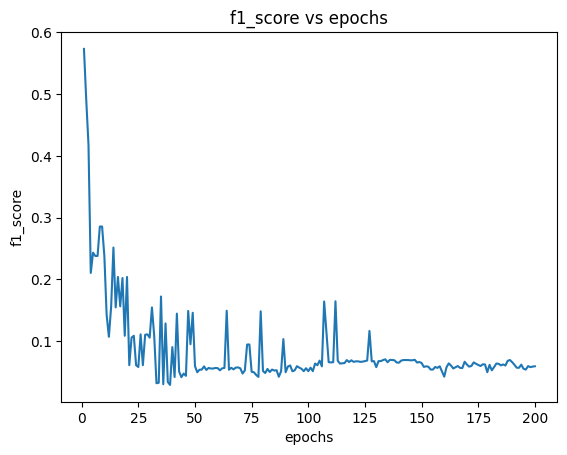

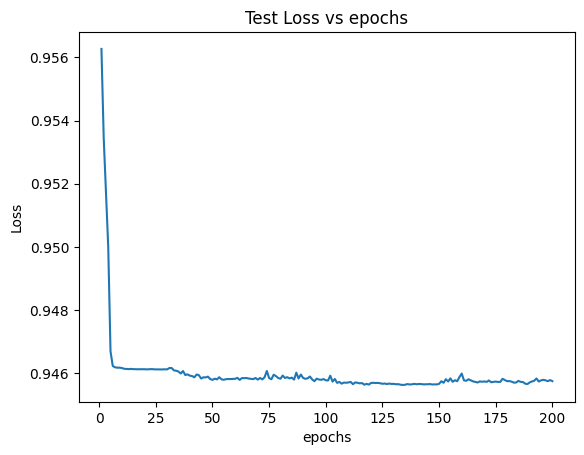

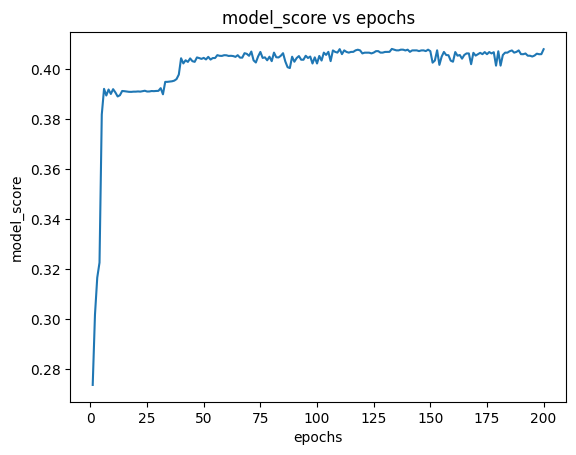

In [8]:
print(max_ms)   
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

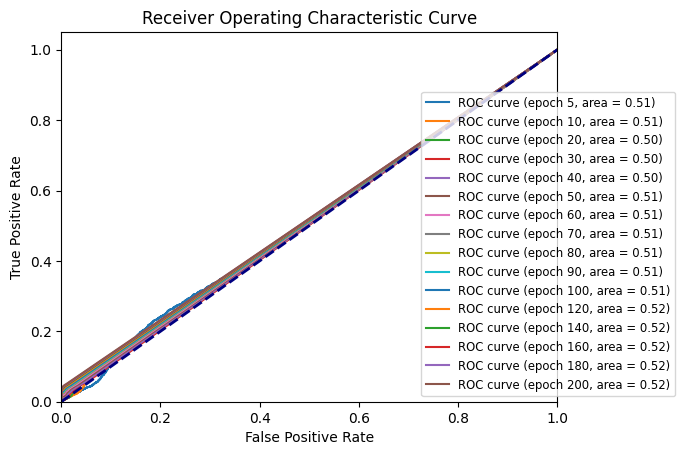

In [9]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [10]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# Assuming val_preds is a numpy array with shape (n_samples, 21)
thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]

  Label    Precision    Recall    F1    AUC
-------  -----------  --------  ----  -----
      0       0.5238       0.5     0    0.5
      1       0.5238       0.5     0    0.5
      2       0.5238       0.5     0    0.5
      3       0.5238       0.5     0    0.5
      4       0.5238       0.5     0    0.5
      5       0.5238       0.5     0    0.5
      6       0.5238       0.5     0    0.5
      7       0.5238       0.5     0    0.5
      8       0.5238       0.5     0    0.5
      9       0.5238       0.5     0    0.5
     10       0.5238       0.5     0    0.5
     11       0.5238       0.5     0    0.5
     12       0.5238       0.5     0    0.5
     13       0.5476       0.5     0    0.5
     14       0.5238       0.5     0    0.5
     15       0.5238       0.5     0    0.5
     16       0.5238       0.5     0    0.5
     17       0.5238       0.5     0    0.5
     18       0.5238       0.5     0    0.5
     19       0.5238       0.5     0    0.5
     20       0.5238       0.5  

In [11]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 